# Terms and Relations extractions on wireless computer networks Patents
 
Jauroyon Maxime, Becquet Gabriel

Information retrieval 

# Introduction

In this project, we focus on the extraction of terms and relationships from a corpus of patents related to wireless computer networks. Wireless computer networks have grown significantly in recent years, with advancements in technology and an increase in connected devices. The goal of this project is to identify and analyze key terms and their relationships within the context of the wireless computer network domain.

To achieve this, we employ Rule based methods, Natural Language Processing (NLP) techniques and machine learning algorithms. The main steps involved in our project include:

1. **Data exploration**: Do some work to explore the data and know it better before doing the extractions
2. **Entity extraction**: Extract relevant entities from the text, such as wireless technologies, network components, devices, and algorithms.
3. **Relationship extraction**: Identify relationships between the extracted entities, which can provide insights into how different components and technologies interact in the wireless computer network domain.

By analyzing the extracted terms and relationships, we aim to gain a deeper understanding of the wireless computer network domain, which can help drive future research and development in the field.


In [1]:
%%time

!pip uninstall -q neuralcoref -y > /dev/null
!pip install -q neuralcoref --no-binary neuralcoref > /dev/null

!pip uninstall -q spacy -y > /dev/null
!pip install -q -U spacy==2.0.12 > /dev/null
!python -m spacy download en > /dev/null

DEPRECATION: --no-binary currently disables reading from the cache of locally built wheels. In the future --no-binary will not influence the wheel cache. pip 23.1 will enforce this behaviour change. A possible replacement is to use the --no-cache-dir option. You can use the flag --use-feature=no-binary-enable-wheel-cache to test the upcoming behaviour. Discussion can be found at https://github.com/pypa/pip/issues/11453
  DEPRECATION: neuralcoref is being installed using the legacy 'setup.py install' method, because the '--no-binary' option was enabled for it and this currently disables local wheel building for projects that don't have a 'pyproject.toml' file. pip 23.1 will enforce this behaviour change. A possible replacement is to enable the '--use-pep517' option. Discussion can be found at https://github.com/pypa/pip/issues/11451
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dep

In [2]:
import re, regex, timeit, gzip, random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from tqdm.notebook import tqdm
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import spacy
#from sense2vec import Sense2Vec
from collections import Counter
from nltk.tokenize import MWETokenizer
from nltk.util import Trie
tqdm.pandas()
spacy.__version__ 
# !pip install jupyterlab-prodigy
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
import re
from tqdm import tqdm

In [3]:
# download prodigy for your system: https://gerdes.fr/saclay/informationRetrieval/prodigy/
# put the files in a subfolder
# try what works. for me it's:
# !pip install ./prodigy-linux/prodigy-1.11.11-cp310-cp310-linux_x86_64.whl

In [4]:
# !prodigy

In [5]:
# this turns on the autotimer, so that every cell has a timing information below
try:
    %load_ext autotime
except:
    !pip install ipython-autotime
    %load_ext autotime
# stop using:
# %unload_ext autotime

time: 657 µs (started: 2023-05-05 22:09:28 +00:00)


### are frequent n-grams terms for the patent domain?

In [6]:
# if you've already unzipped the file
h04w=open('/kaggle/input/d/gabrielbecquet/h04w-patent-file/H04W.txt').read().strip()

time: 1.59 s (started: 2023-05-05 22:09:28 +00:00)


In [7]:
# if you've already unzipped the file
h04w=open('/kaggle/input/d/gabrielbecquet/h04w-patent-file/H04W.txt').read().strip()
# otherwise try something like this:
# h04w = gzip.open('H04W.tar.gz', mode="rt").read().strip()

cvectorizer = CountVectorizer()
patent_lines = h04w.split('\n')
print(len(patent_lines),'lines of patent text')
X=cvectorizer.fit_transform(patent_lines)
X

395421 lines of patent text


<395421x78930 sparse matrix of type '<class 'numpy.int64'>'
	with 14173816 stored elements in Compressed Sparse Row format>

time: 22.8 s (started: 2023-05-05 22:09:30 +00:00)


In [8]:
np.sum(X, axis=0).shape

(1, 78930)

time: 53.3 ms (started: 2023-05-05 22:09:53 +00:00)


In [9]:
Xdf = pd.DataFrame(np.sum(X, axis=0), columns=cvectorizer.get_feature_names()).T.sort_values(by = 0, ascending = False)
Xdf.head(25)

/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


0
the           3053116
of             975030
to             860119
and            653891
in             637847
is             535015
or             341806
for            313543
may            310007
information    295558
be             292859
device         277623
an             276803
first          254626
by             249422
that           221228
data           184208
second         173915
on             168709
as             165488
network        163409
terminal       157721
one            157374
with           141611
transmission   136566

time: 180 ms (started: 2023-05-05 22:09:53 +00:00)


In [10]:
# here are the potential terms
mwes = open('/kaggle/input/ir-week-4-dataset/manyterms.lower.txt').read().strip().split('\n')
print(mwes[33333:33338])
print(len(mwes),'mwes')

['alpha-numeric code', 'alpha-particle emission', 'alpha-particle scattering experiment', 'alpha-particle spectroscopy', 'alpha-to-beta transition temperature']
743274 mwes
time: 607 ms (started: 2023-05-05 22:09:53 +00:00)


In [11]:
# not working: already crazy slow for 500 terms. Why?
n = 500
termlist = [re.escape(t) for t in mwes[:n]]
termregex = re.compile(r'\b'+r'\b|\b'.join(termlist), re.I)
termfreqs = Counter()
for i,li in tqdm(enumerate(h04w.split('\n'))):
    for m in termregex.finditer(li):
        termfreqs[m.group(0)]=termfreqs.get(m.group(0),0)+1
print(termfreqs.most_common(3))

395421it [03:12, 2051.20it/s]

[('10 seconds', 68), ('10 minutes', 37), ('10 billion', 5)]
time: 3min 13s (started: 2023-05-05 22:09:54 +00:00)


In [12]:
# a trie, working better:


class FreqMWETokenizer(MWETokenizer):
    """A tokenizer that processes tokenized text and merges multi-word expressions
    into single tokens.
    """

    def __init__(self, mwes=None, separator="_"):
        super().__init__(mwes, separator)
        # call parent constructor with the vocab and separator parameters
        # that way we will have acces to the Trie created based on our vocab

    def freqs(self, text):
        """
        :param text: A list containing tokenized text
        :type text: list(str)
        :return: A frequency dictionary with multi-words merged together as keys
        :rtype: dict
        :Example:
        >>> tokenizer = FreqMWETokenizer([ mw.split() for mw in ['multilayer ceramic', 'multilayer ceramic capacitor', 'ceramic capacitor']], separator=' ')
        >>> tokenizer.freqs("Gimme that multilayer ceramic capacitor please!".split())
        {'multilayer ceramic': 1, 'multilayer ceramic capacitor': 1, 'ceramic capacitor': 1}
        """
        i = 0 # basic iterator 
        n = len(text) # number of words we got
        result = Counter() # counter to save the frequency

        while i < n: # we are going to check every word given
            if text[i] in self._mwes:
                # possible MWE match
                j = i
                # iterator that will increase to extend the number of words of the potential match
                # start by the word which we know is in the Trie
                trie = self._mwes
                # get the trie and will navigate trought it
                while j < n and text[j] in trie: # we are going to see if we match by adding more words that follow the one we start with
                    if Trie.LEAF in trie:
                        # success!
                        mw = self._separator.join(text[i:j]) # get the term from our vocab
                        result[mw]=result.get(mw,0)+1 # update the frequency by 1
                    trie = trie[text[j]] # diving one step deeper into the trie
                    j = j + 1 # adding another word to see if we have a bigger match after that one
                else: # executed if while did not break
                    if Trie.LEAF in trie:
                        # success!
                        mw = self._separator.join(text[i:j]) # get the term from our vocab
                        result[mw]=result.get(mw,0)+1 # update the frequency by 1
                    i += 1 # once we have finish searching the Trie for word i, we continue for the rest of the given word list
            else:
                i += 1 # if word i not in the Trie, then we continue for the rest of the given word list 

        return result
tokenizer = FreqMWETokenizer([ mw.split() for mw in ['multilayer ceramic','multilayer ceramic capacitor', 'ceramic capacitor']], separator=' ')
tokenizer.freqs("Gimme that multilayer ceramic capacitor please!".split())
#{'multilayer ceramic': 1, 'multilayer ceramic capacitor': 1, 'ceramic capacitor': 1}

Counter({'multilayer ceramic': 1,
         'multilayer ceramic capacitor': 1,
         'ceramic capacitor': 1})

time: 7.23 ms (started: 2023-05-05 22:13:08 +00:00)


In [13]:
splimwes = [ mw.split() for mw in mwes]
tokenizer = FreqMWETokenizer(splimwes, separator=' ')
tokenizer.freqs("Gimme that multilayer ceramic capacitor please!".split())

Counter({'multilayer ceramic': 1,
         'multilayer ceramic capacitor': 1,
         'ceramic capacitor': 1})

time: 5.42 s (started: 2023-05-05 22:13:08 +00:00)


In [14]:
start = timeit.default_timer()
counter = tokenizer.freqs(h04w.split())
secs = timeit.default_timer()-start
print('it took', secs, 'seconds,', secs/len(mwes),'per term')


it took 40.947538302999874 seconds, 5.509077177864405e-05 per term
time: 40.9 s (started: 2023-05-05 22:13:14 +00:00)


In [15]:
h04wdf = pd.DataFrame.from_dict(counter, orient='index').sort_values(by = 0, ascending = False)
h04wdf

0
the present          68536
base station         66177
number of            28848
user equipment       24982
network device       23051
...                    ...
single car               1
domain expert            1
validation set           1
similarity learning      1
wave method              1

[9793 rows x 1 columns]

time: 13.1 ms (started: 2023-05-05 22:13:55 +00:00)


In [16]:
vectorizernb = CountVectorizer(vocabulary=mwes, binary=False, min_df=1, lowercase=True, ngram_range=(1,4))
Xnb = vectorizernb.fit_transform(patent_lines)

/opt/conda/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:1323: UserWarning: Upper case characters found in vocabulary while 'lowercase' is True. These entries will not be matched with any documents
  "Upper case characters found in"


time: 1min 32s (started: 2023-05-05 22:13:56 +00:00)


In [17]:
Xnb

<395421x743274 sparse matrix of type '<class 'numpy.int64'>'
	with 831569 stored elements in Compressed Sparse Row format>

time: 2.87 ms (started: 2023-05-05 22:15:29 +00:00)


In [18]:
Xnb.sum(axis=0).shape

(1, 743274)

time: 12.5 ms (started: 2023-05-05 22:15:29 +00:00)


In [19]:
vectorizernb.get_feature_names()[Xnb.sum(axis=0).argmax()]

/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


'base station'

time: 244 ms (started: 2023-05-05 22:15:29 +00:00)


In [20]:
np.argpartition(Xnb.sum(axis=0).flat,-10)[-10:].shape

(10,)

time: 17.9 ms (started: 2023-05-05 22:15:30 +00:00)


In [21]:

#     - find the terms from the lexicon with the 10 highest match in the patent texts
for i in np.argpartition(Xnb.sum(axis=0).flat,-10)[-10:]:
    print(vectorizernb.get_feature_names()[i])

reference signal
control channel
electronic device
the following
number of
the present
network device
base station
user equipment
wireless communication
time: 2.31 s (started: 2023-05-05 22:15:30 +00:00)


## preparing a Gold corpus

- sort the patents of the h04w corpus into those that have reference numerals R and those that don't N
- count how many we have of each type
- for each patent of the R corpus, extract a list of numbered terms, verify manually for a few patents
- compare these terms with the ones detected using the previous methods
- later, in the spacy section: visualize the annotations using Spacy


In [22]:
n = 3 # number of words to look for (before the potential reference numeral)
R = [] # R corpus list
N = [] # N corpus lsit

patent_texts = h04w.split('\n\n') # divide the text into each patent text (got this from the spacy part)

for t in patent_texts: # we will look at each patent
    numerals = dict() # keeping the record for each number what terms we have stored in the counter
    result = Counter() # the counter for the frequencies
    words = [word for line in t.split('\n') for word in line.split()] # list of all the words in the patent text
    for i,word in enumerate(words): # we will look at all of them in the correct order
        if i>n and (word.isdigit() or (word[1:-1].isdigit() and word[0] == "(" and word[-1] == ")")): # make sure to not go overbound and that we have found a number
            key = words[i] # get the number
            result[key]=result.get(key,0)+1 # update the frequency by 1
            for j in range(1,n+1): # we will look at the words before the number
                term = '_'.join(words[i-j:i+1]) # get the term
                result[term]=result.get(term,0)+1 # update the frequency by 1
                try: # and add the term to the set of terms related to the number
                    numerals[key].add(term)
                except KeyError:
                    numerals[key] = {term}
                    
    # counting potential reference numerals
    cpt = 0
    listPotentialReferenceTerms = [] # to keep the potential terms
    for nb,setT in numerals.items(): # we will look at all the numbers we have found in the patent text and their set of terms
        maxIteration = result.get(nb) # number of time we have seen this number
        maxTF = 0 # store the max frequency
        maxTL = 0 # store the max length
        maxT = None # store the term with the max frequency
        for s in setT: # we look at all the terms for this number
            if result.get(s) > maxTF : # update the max
                maxTF = result.get(s)
                maxT = s
                maxTL = len(s.split('_'))
            elif result.get(s) == maxTF and len(s.split('_')) > maxTL:
                maxTF = result.get(s)
                maxT = s
                maxTL = len(s.split('_'))
        if maxIteration > 1 and maxTF > (maxIteration*80/100): 
        # numbers that appear 1 time doesn't provide enough statistical information 
        # and we want the term to have appeared at least 80% from the time we saw the number            
            cpt += 1
            listPotentialReferenceTerms.append((maxT,maxTF)) # store the potential terms for this patent
#             print(nb," : ",maxIteration," | ",maxT," : ",maxTF)
    
    if cpt > (len(numerals.keys())*50/100): # if more than 50% of numerals are potential reference than we store the corpus in R
        R.append((t,listPotentialReferenceTerms))
    else :
        N.append((t,listPotentialReferenceTerms))
#     print(cpt,' vs ',len(numerals.keys()))
#     print(result.most_common(10))
#     print(numerals)
    
print("R : ",len(R)," N : ",len(N))      

R :  373  N :  1628
time: 18.6 s (started: 2023-05-05 22:15:33 +00:00)


In [23]:
R[100][1] # of the 100th patent of R

[('Personal_authentication_device_300', 2),
 ('unit_31', 5),
 ('Observation_unit_32', 2),
 ('Calculation_unit_33', 2),
 ('Extraction_unit_34', 2),
 ('Storage_control_unit_35', 2),
 ('unit_36', 6),
 ('unit_37', 3),
 ('authentication_device_100', 8),
 ('unit_11', 6),
 ('unit_12', 3),
 ('unit_14', 8),
 ('control_unit_15', 6),
 ('unit_17', 12),
 ('unit_16', 9),
 ('control_unit_18', 10),
 ('earphone_4', 13),
 ('authentication_device_200', 7),
 ('control_unit_21', 6),
 ('control_unit_22', 6),
 ('service_control_unit_28', 2),
 ('device_505', 2),
 ('device_507', 2),
 ('CPU_501', 4)]

time: 4.4 ms (started: 2023-05-05 22:15:52 +00:00)


## Spacy
https://spacy.io/usage/rule-based-matching#phrasematcher

In [24]:
import spacy
from spacy.matcher import PhraseMatcher

# load vocab
nlp = spacy.load("en_core_web_sm")
# init matcher with the vocab
matcher = PhraseMatcher(nlp.vocab)
terms = ["Barack Obama", "Angela Merkel", "Washington, D.C."]
# [doc] If you only need the tokenization and lexical attributes, you can run nlp.make_doc
patterns = [nlp.make_doc(text) for text in terms]
# add patterns to the matcher
matcher.add("TerminologyList", patterns)

# init string to be matched
doc = nlp("German Chancellor Angela Merkel and US President Barack Obama "
          "converse in the Oval Office inside the White House in Washington, D.C.")

# get matches
matches = matcher(doc)

# iterate over the matches and print the span text
for match_id, start, end in matches:
    span = doc[start:end]
    print(span.text)

time: 754 ms (started: 2023-05-05 22:15:53 +00:00)


In [25]:
from spacy import displacy
displacy.render(doc, style="ent")

'<div class="entities" style="line-height: 2.5">\n<mark class="entity" style="background: #c887fb; padding: 0.45em 0.6em; margin: 0 0.25em; line-height: 1; border-radius: 0.35em; box-decoration-break: clone; -webkit-box-decoration-break: clone">\n    German\n    <span style="font-size: 0.8em; font-weight: bold; line-height: 1; border-radius: 0.35em; text-transform: uppercase; vertical-align: middle; margin-left: 0.5rem">NORP</span>\n</mark>\n Chancellor \n<mark class="entity" style="background: #aa9cfc; padding: 0.45em 0.6em; margin: 0 0.25em; line-height: 1; border-radius: 0.35em; box-decoration-break: clone; -webkit-box-decoration-break: clone">\n    Angela Merkel\n    <span style="font-size: 0.8em; font-weight: bold; line-height: 1; border-radius: 0.35em; text-transform: uppercase; vertical-align: middle; margin-left: 0.5rem">PERSON</span>\n</mark>\n and \n<mark class="entity" style="background: #feca74; padding: 0.45em 0.6em; margin: 0 0.25em; line-height: 1; border-radius: 0.35em;

time: 3.73 ms (started: 2023-05-05 22:15:54 +00:00)


In SpaCy, the pretrained default pipeline may consist of various componenets. If we want to train specific pipeline, it can be initiated as a blank and we can add only necessary elements.

In [26]:
nlp.pipeline

[('tagger', <spacy.pipeline.Tagger at 0x70ba64319690>),
 ('parser', <spacy.pipeline.DependencyParser at 0x70ba63a602f0>),
 ('ner', <spacy.pipeline.EntityRecognizer at 0x70ba63a60830>)]

time: 3.48 ms (started: 2023-05-05 22:15:55 +00:00)


In [27]:
# !python -m spacy download en_core_web_lg
h04w=open('/kaggle/input/d/gabrielbecquet/h04w-patent-file/H04W.txt').read().strip()

# from spacy.util import filter_spans
from spacy import displacy
# from spacy.tokens import DocBin
from spacy.tokens import Span

patent_texts = h04w.split('\n\n')
patent_lines = h04w.split('\n')

# nlp = spacy.load("en_core_web_lg")
nlp = spacy.load("en_core_web_sm")
doc = nlp(patent_texts[0][18000:20000]) # 
displacy.render(doc, style="ent", jupyter = True)

time: 1.97 s (started: 2023-05-05 22:15:55 +00:00)


In [28]:
# if restarting here: (17 secs)
from spacy.matcher import PhraseMatcher

h04w_lines = h04w.split('\n')
print(len(h04w_lines),'lines of patent text')
cvectorizer = CountVectorizer(ngram_range=(2, 3), stop_words='english', min_df=500,) # , stop_words='english'  max_features
X=cvectorizer.fit_transform(h04w_lines)
Xdf = pd.DataFrame(np.sum(X, axis=0), columns=cvectorizer.get_feature_names_out()).T.sort_values(by = 0, ascending = False)


395421 lines of patent text
time: 1min (started: 2023-05-05 22:15:58 +00:00)


In [29]:
matcher = PhraseMatcher(nlp.vocab) #, attr="LOWER")
patterns = [nlp.make_doc(text) for text in Xdf.index]
matcher.add("Tech", patterns)

time: 177 ms (started: 2023-05-05 22:16:59 +00:00)


adding all the ngrams found by CountVectorizer as patterns in the matcher object (they will all be put in lower case)

In [30]:
from sklearn.model_selection import train_test_split
train_lines, test_lines = train_test_split(patent_lines, test_size=0.3, random_state=42)


time: 148 ms (started: 2023-05-05 22:17:00 +00:00)


In [31]:
len(train_lines),len(test_lines)

(276794, 118627)

time: 3.19 ms (started: 2023-05-05 22:17:00 +00:00)


splitting the lines of the patent for training and testing (only 30% of them for training)

## Using spacy and prodigy

For the next part the goal was to use spacy then prodigy to generate the best model for term extraction, since it's very long to compute and we already have the spacy and prodigy output ( in the input data) with thousands of annotated terms, it is commented, if you want you can use the testing cells to test it.

In [32]:
# LABEL = "TT"
# doc_bin_train = DocBin() # create a DocBin object

# # nlp.max_length = 2000000
# for training_example  in tqdm(train_lines[:30000]): #~50 patents
#     doc = nlp.make_doc(training_example) 
#     ents = []
    
#     for match_id, start, end in matcher(doc):
#         #print(i,"Matched based on lowercase token text:", doc[:10], '::::::::',doc[start:end],start, end)
#         span = Span(doc, start, end, label=LABEL)
#         #print(span, span.label_)
#         if span is None:
#             print("Skipping entity")
#         else:
#             ents.append(span)

#     filtered_ents = filter_spans(ents)
#     # print(filtered_ents[:3])
#     doc.ents = filtered_ents 
#     doc_bin_train.add(doc)

time: 639 µs (started: 2023-05-05 22:17:02 +00:00)


In [33]:
# LABEL = "TT"
# doc_bin_valid = DocBin() # create a DocBin object
# nlp = spacy.blank("en")
# # nlp.max_length = 2000000
# for training_example  in tqdm(test_lines[:10000]): #~15 patents
#     doc = nlp.make_doc(training_example) 
#     ents = []
    
#     for match_id, start, end in matcher(doc):
#         #print(i,"Matched based on lowercase token text:", doc[:10], '::::::::',doc[start:end],start, end)
#         span = Span(doc, start, end, label=LABEL)
#         #print(span, span.label_)
#         if span is None:
#             print("Skipping entity")
#         else:
#             ents.append(span)

#     filtered_ents = filter_spans(ents)
#     # print(filtered_ents[:3])
#     doc.ents = filtered_ents 
#     doc_bin_valid.add(doc)

time: 849 µs (started: 2023-05-05 22:17:02 +00:00)


In [34]:
# LABEL = "TT"
# doc_bin_test = DocBin() # create a DocBin object
# nlp = spacy.blank("en")
# # nlp.max_length = 2000000
# for training_example  in tqdm(test_lines[10000:12000]): #~5 patents
#     doc = nlp.make_doc(training_example) 
#     ents = []
    
#     for match_id, start, end in matcher(doc):
#         #print(i,"Matched based on lowercase token text:", doc[:10], '::::::::',doc[start:end],start, end)
#         span = Span(doc, start, end, label=LABEL)
#         #print(span, span.label_)
#         if span is None:
#             print("Skipping entity")
#         else:
#             ents.append(span)

#     filtered_ents = filter_spans(ents)
#     # print(filtered_ents[:3])
#     doc.ents = filtered_ents 
#     doc_bin_test.add(doc)

time: 680 µs (started: 2023-05-05 22:17:02 +00:00)


In [35]:
# doc_bin_train.to_disk("training_data.spacy") # save the docbin object
# doc_bin_valid.to_disk("valid_data.spacy") # save the docbin object
# doc_bin_test.to_disk("test_data.spacy") # save the docbin object

# # save train_lines to txt file
# with open('train_lines.txt', 'w') as f:
#     for line in train_lines:
#         f.write(line)
#         f.write('\n')
# f.close()

# # save train_lines to txt file
# with open('valid_lines.txt', 'w') as f:
#     for line in test_lines[:10000]:
#         f.write(line)
#         f.write('\n')
# f.close()

# # save test_lines to txt file
# with open('test_lines.txt', 'w') as f:
#     for line in test_lines[10000:12000]:
#         f.write(line)
#         f.write('\n')
# f.close()

time: 651 µs (started: 2023-05-05 22:17:03 +00:00)


save all the lines that have been computed for the doc_bins and save the doc_bins object too

Donwnload __base_config.cfg__ for your system at https://spacy.io/usage/training#quickstart

In [36]:
# # Run to generate full training config
# !python -m spacy init fill-config /kaggle/input/ir-spacy-config/base_config.cfg config.cfg

time: 383 µs (started: 2023-05-05 22:17:04 +00:00)


#### Training
Run training. All results are stored into __./spacy_output__ 

In [37]:
# # takes some time!
# # if it crashes VS Code you may want to try to run this line directly in the command line
# !python -m spacy train config.cfg --output ./spacy_output --paths.train ./training_data.spacy --paths.dev ./valid_data.spacy

time: 433 µs (started: 2023-05-05 22:17:05 +00:00)


### Testing

In [38]:
# # Load best model
# nlp_ner = spacy.load("./spacy_output/model-best")

# # Just text snippet
# doc = nlp_ner("An audio circuit 960, a speaker 961, and a microphone 962 may provide an audio interface between a user and a mobile phone. The audio circuit 960 may transmit the received audio data converted electrical signal to the speaker 961, and convert the audio signal from the speaker 961 to a sound signal for playback. On the other hand, the microphone 962 converts the collected sound signal into an electrical signal, receives it by the audio circuit 960, converts it into audio data, processes it by the audio data playback processor 980, transmits it to another mobile phone, for example, via the RF circuit 910, or plays the audio data to the memory 920 for further processing. \
# WiFi belongs to a short-range wireless transmission technology, and the mobile phone can help the user receive and send e-mail, browse web pages, access streaming media, and the like through the WiFi module 970, which provides the user with wireless broadband Internet access. Although FIG. 7 shows the WiFi module 970, it is understood that it does not belong to the mandatory structure of the mobile phone and may be omitted as necessary without changing the essence of the disclosure. \
# The processor 980 is the control center of the mobile phone, connecting the parts of the entire mobile phone using various interfaces and lines, performing various functions and processing data of the mobile phone by running or executing a software program and/or module stored in the memory 920, and invoking data stored in the memory 920, thereby performing overall monitoring of the mobile phone. Optionally, processor 980 may include one or more processing units. Preferably, the processor 980 may integrate an application processor and a modem processor, wherein the application processor mainly processes an operating system, a user interface, an application program, and the like, and the modem processor mainly processes wireless communications. It is understood that the above-described modem processor may also not be integrated into the processor 980.")

# # Show NER results
# spacy.displacy.render(doc, style="ent", jupyter=True)

time: 1.47 ms (started: 2023-05-05 22:17:05 +00:00)


We are getting rigth term with TT label so now Let's try with our terms 

In [39]:
# ours_term = [ ' '.join(a.lower().split('_')[:-1]) for n in range(len(R)) for a,b in R[n][1] ]

time: 485 µs (started: 2023-05-05 22:17:06 +00:00)


In [40]:
# ours_term[:10]

time: 296 µs (started: 2023-05-05 22:17:06 +00:00)


In [41]:
# ours_matcher = PhraseMatcher(nlp.vocab, attr="LOWER")
# ours_patterns = [nlp.make_doc(text) for text in ours_term]
# ours_matcher.add("Tech", ours_patterns)

time: 378 µs (started: 2023-05-05 22:17:07 +00:00)


In [42]:
# LABEL = "FF"
# ours_doc_bin_train = DocBin() # create a DocBin object

# # nlp.max_length = 2000000
# for training_example  in tqdm(train_lines[:30000]): #~50 patents
#     doc = nlp.make_doc(training_example) 
#     ents = []
    
#     for match_id, start, end in matcher(doc):
#         #print(i,"Matched based on lowercase token text:", doc[:10], '::::::::',doc[start:end],start, end)
#         span = Span(doc, start, end, label=LABEL)
#         #print(span, span.label_)
#         if span is None:
#             print("Skipping entity")
#         else:
#             ents.append(span)

#     filtered_ents = filter_spans(ents)
# #     print(filtered_ents[:3])
#     doc.ents = filtered_ents 
#     ours_doc_bin_train.add(doc)

time: 675 µs (started: 2023-05-05 22:17:07 +00:00)


In [43]:
# LABEL = "FF"
# ours_doc_bin_test = DocBin() # create a DocBin object
# nlp = spacy.blank("en")
# # nlp.max_length = 2000000
# for training_example  in tqdm(test_lines[10000:12000]): #~5 patents
#     doc = nlp.make_doc(training_example) 
#     ents = []
    
#     for match_id, start, end in matcher(doc):
#         #print(i,"Matched based on lowercase token text:", doc[:10], '::::::::',doc[start:end],start, end)
#         span = Span(doc, start, end, label=LABEL)
#         #print(span, span.label_)
#         if span is None:
#             print("Skipping entity")
#         else:
#             ents.append(span)

#     filtered_ents = filter_spans(ents)
# #     print(filtered_ents[:3])
#     doc.ents = filtered_ents 
#     ours_doc_bin_test.add(doc)

time: 682 µs (started: 2023-05-05 22:17:07 +00:00)


In [44]:
# LABEL = "FF"
# ours_doc_bin_valid = DocBin() # create a DocBin object
# nlp = spacy.blank("en")
# # nlp.max_length = 2000000
# for training_example  in tqdm(test_lines[:10000]): #~15 patents
#     doc = nlp.make_doc(training_example) 
#     ents = []
    
#     for match_id, start, end in matcher(doc):
#         #print(i,"Matched based on lowercase token text:", doc[:10], '::::::::',doc[start:end],start, end)
#         span = Span(doc, start, end, label=LABEL)
#         #print(span, span.label_)
#         if span is None:
#             print("Skipping entity")
#         else:
#             ents.append(span)

#     filtered_ents = filter_spans(ents)
# #     print(filtered_ents[:3])
#     doc.ents = filtered_ents 
#     ours_doc_bin_valid.add(doc)

time: 671 µs (started: 2023-05-05 22:17:08 +00:00)


In [45]:
# ours_doc_bin_train.to_disk("ours_training_data.spacy") # save the docbin object
# ours_doc_bin_valid.to_disk("ours_valid_data.spacy") # save the docbin object
# ours_doc_bin_test.to_disk("ours_test_data.spacy") # save the docbin object

# # # save train_lines to txt file
# # with open('ours_train_lines.txt', 'w') as f:
# #     for line in train_lines:
# #         f.write(line)
# #         f.write('\n')
# # f.close()

# # # save train_lines to txt file
# # with open('ours_valid_lines.txt', 'w') as f:
# #     for line in test_lines[:10000]:
# #         f.write(line)
# #         f.write('\n')
# # f.close()

# # # save test_lines to txt file
# # with open('ours_test_lines.txt', 'w') as f:
# #     for line in test_lines[10000:12000]:
# #         f.write(line)
# #         f.write('\n')
# # f.close()

time: 720 µs (started: 2023-05-05 22:17:08 +00:00)


In [46]:
# # Run to generate full training config
# !python -m spacy init fill-config /kaggle/input/ir-spacy-config/base_config.cfg config.cfg

time: 379 µs (started: 2023-05-05 22:17:09 +00:00)


In [47]:
# # takes some time!
# # if it crashes VS Code you may want to try to run this line directly in the command line
# !python -m spacy train config.cfg --output ./ours_spacy_output --paths.train ./ours_training_data.spacy --paths.dev ./ours_valid_data.spacy

time: 444 µs (started: 2023-05-05 22:17:09 +00:00)


In [48]:
# # Load best model
# nlp_ner = spacy.load("./ours_spacy_output/model-best")

# # Just text snippet
# doc = nlp_ner("An audio circuit 960, a speaker 961, and a microphone 962 may provide an audio interface between a user and a mobile phone. The audio circuit 960 may transmit the received audio data converted electrical signal to the speaker 961, and convert the audio signal from the speaker 961 to a sound signal for playback. On the other hand, the microphone 962 converts the collected sound signal into an electrical signal, receives it by the audio circuit 960, converts it into audio data, processes it by the audio data playback processor 980, transmits it to another mobile phone, for example, via the RF circuit 910, or plays the audio data to the memory 920 for further processing. \
# WiFi belongs to a short-range wireless transmission technology, and the mobile phone can help the user receive and send e-mail, browse web pages, access streaming media, and the like through the WiFi module 970, which provides the user with wireless broadband Internet access. Although FIG. 7 shows the WiFi module 970, it is understood that it does not belong to the mandatory structure of the mobile phone and may be omitted as necessary without changing the essence of the disclosure. \
# The processor 980 is the control center of the mobile phone, connecting the parts of the entire mobile phone using various interfaces and lines, performing various functions and processing data of the mobile phone by running or executing a software program and/or module stored in the memory 920, and invoking data stored in the memory 920, thereby performing overall monitoring of the mobile phone. Optionally, processor 980 may include one or more processing units. Preferably, the processor 980 may integrate an application processor and a modem processor, wherein the application processor mainly processes an operating system, a user interface, an application program, and the like, and the modem processor mainly processes wireless communications. It is understood that the above-described modem processor may also not be integrated into the processor 980.")
# # Show NER results
# spacy.displacy.render(doc, style="ent", jupyter=True)

time: 1.32 ms (started: 2023-05-05 22:17:09 +00:00)


## 🦄 Prodigy: Make it even better

check this tutorial: https://newscatcherapi.com/blog/train-custom-named-entity-recognition-ner-model-with-spacy-v3  
and the official documentation: https://spacy.io/usage/training#custom-ner-model

One of the besst feature of Prodigy is that you can focus annotation on the most uncertain enitties.  
For this one we use __ner.teach__

As a dataset, used valid_data.txt, since model is already fitter on the training data

In [49]:
# !prodigy ner.teach ner_tech  ./spacy_output/model-best  valid_lines.txt --label TT

time: 349 µs (started: 2023-05-05 22:17:10 +00:00)


Also, instead of binary judging, we can correct model prediction manualy by using __ner.correct__

In [50]:
# !prodigy ner.correct gold_tech  ./spacy_output/model-best  valid_lines.txt --label TECH

time: 361 µs (started: 2023-05-05 22:17:11 +00:00)


### Merge it
Now, we need to merge our binary annotation into the __gold dataset__  
This means that we are fixing annotation manually in the text which we had rejected during __ner.teach__  

Those annotation can be directly merged into already created dataset(by ner.correct)

In [51]:
# !prodigy ner.silver-to-gold gold_tech ner_tech ./spacy_output/model-best --label TT 

time: 350 µs (started: 2023-05-05 22:17:12 +00:00)


We can export this dataset to train the model with    __`spacy -m train ...`__

In [52]:
# !prodigy data-to-spacy ./prodigy_output --ner gold_tech --eval-split 0.3

time: 328 µs (started: 2023-05-05 22:17:12 +00:00)


We can finetune\ train our existing SpaCy model(pipeline) inside prodigy  

Here we train existing `/model_best` and output our finte-tuned model into `spacy_output`

In [53]:
# !prodigy train ./prodigy_output --ner gold_tech --eval-split 0.3 --base-model ./spacy_output/model-best 

time: 344 µs (started: 2023-05-05 22:17:13 +00:00)


In [54]:
# nlp_ner = spacy.load("./prodigy_output/model-best")

# # Just text snippet
# doc = nlp_ner("An audio circuit 960, a speaker 961, and a microphone 962 may provide an audio interface between a user and a mobile phone. The audio circuit 960 may transmit the received audio data converted electrical signal to the speaker 961, and convert the audio signal from the speaker 961 to a sound signal for playback. On the other hand, the microphone 962 converts the collected sound signal into an electrical signal, receives it by the audio circuit 960, converts it into audio data, processes it by the audio data playback processor 980, transmits it to another mobile phone, for example, via the RF circuit 910, or plays the audio data to the memory 920 for further processing. \
# WiFi belongs to a short-range wireless transmission technology, and the mobile phone can help the user receive and send e-mail, browse web pages, access streaming media, and the like through the WiFi module 970, which provides the user with wireless broadband Internet access. Although FIG. 7 shows the WiFi module 970, it is understood that it does not belong to the mandatory structure of the mobile phone and may be omitted as necessary without changing the essence of the disclosure. \
# The processor 980 is the control center of the mobile phone, connecting the parts of the entire mobile phone using various interfaces and lines, performing various functions and processing data of the mobile phone by running or executing a software program and/or module stored in the memory 920, and invoking data stored in the memory 920, thereby performing overall monitoring of the mobile phone. Optionally, processor 980 may include one or more processing units. Preferably, the processor 980 may integrate an application processor and a modem processor, wherein the application processor mainly processes an operating system, a user interface, an application program, and the like, and the modem processor mainly processes wireless communications. It is understood that the above-described modem processor may also not be integrated into the processor 980.")
# # Show NER results
# spacy.displacy.render(doc, style="ent", jupyter=True)

time: 1.31 ms (started: 2023-05-05 22:17:14 +00:00)


### Terms extractions and relations extractions

Now we use another method to do the terms extraction that will allow us to do relations extractions.


In [55]:
# !python -m spacy download en_core_web_lg
import spacy
from spacy.tokens import Span
# from spacy.tokens import DocBin
from spacy import displacy
# from spacy.util import filter_spans
from spacy.matcher import PhraseMatcher
import pandas as pd 
import networkx as nx
import matplotlib.pyplot as plt


time: 711 ms (started: 2023-05-05 22:17:14 +00:00)


- let's run it out of the box:

In [56]:
h04w = open('/kaggle/input/d/gabrielbecquet/h04w-patent-file/H04W.txt').read().strip()
h04w_lines = h04w.split('\n')

print(len(h04w_lines), 'paragraphs of patent text')

patent_texts = h04w.split('\n\n')
patent_lines = h04w.split('\n')

# nlp = spacy.load("en_core_web_lg")
nlp = spacy.load("en_core_web_sm")
shorttext = patent_texts[0][18000:20000]
# open('shorttext.txt','w').write(shorttext)
doc = nlp(shorttext)
displacy.render(doc, style="ent", jupyter=True)

395421 paragraphs of patent text


time: 2.16 s (started: 2023-05-05 22:17:16 +00:00)


In [57]:
for ch in doc.noun_chunks:
    print(ch.text)

ception processing
The signal
output
the second processing unit
example
a higher-layer apparatus
the wireless base station
The second processing unit
example
transmission processing
the second signal processing
a signal
input
a higher-layer apparatus
the wireless base station
the wireless control apparatus
the signal
the transmission processing
the IF processing unit
the configuration information
output
the IF processing unit
the control unit
123 sets processing
the second processing unit
the second signal processing
an example
the control unit
123 specifies processing
the first signal processing
the wireless apparatus
the base station signal processing
the configuration information
the specified processing
the base station signal processing
the second signal processing
the second processing unit
Distribution
the base station signal processing
the first signal processing
the second signal processing
The base station signal processing
the wireless base station
the first signal processin

- let's visualize:

In [58]:
noun_chunks = [{
    'start': chunk.start_char,
    'end': chunk.end_char,
    'label': 'NC',
    'text': chunk.text
} 
    for chunk in doc.noun_chunks
]
funkycolor = "linear-gradient(90deg, #aa9cfc, #fc9ce7)"
displacy.render({'text': shorttext, 'ents': noun_chunks, 'title': None},
                style='ent', options={'colors': {"NC": funkycolor}}, manual=True, jupyter=True)



time: 4.79 ms (started: 2023-05-05 22:17:19 +00:00)


- the system seems to get confused by the numbers in the text. let's remove them using our function from last time:

In [59]:
import re


def combineFreqDics(freq_dic):
    """
    function that combines entries of the freq_dic if they only differ in case into the most frequent case version
    """
    combined_dict = {}

    for key, value in freq_dic.items():
        normalized_key = key.lower()
        if normalized_key not in combined_dict:
            combined_dict[normalized_key] = (key, value)
        else:
            orig_key, orig_value = combined_dict[normalized_key]
            combined_dict[normalized_key] = (
                key if value > orig_value else orig_key, orig_value + value)

    return {key: value for key, value in combined_dict.values()}


def is_plural(singular, plural):
    return singular + 's' == plural or singular == plural + 's'


def rawExtractRefs(text, allnums=True, multipleResults=True):
    """
    text: the text potentially containing reference numerals
    NO: termjson: json as send back to the frontend
    allnums: if true also terms without parentheses
    """
    if allnums:
        renum = re.compile(r'[ (]\d+[) .,]')
    else:
        renum = re.compile(r'\(\d+\)')
    num2term = {}
    # print(111,'a\ba',222,r'\b|\b'.join('the a an to for under behind above least on which and or Figure \W*\d+\W*'.split()),333,'\b'+'\b|\b'.join('the a an to for under behind above least on which and or Figure \W*\d+\W*'.split())+r'\b')
    excluders = '''the a an 
    to for of under behind above least on which and or more all 
    Claim Claims Figure Figures Fig Figs'''
    noterms = re.compile(r'\b'+r'\b|\b'.join((excluders +
                         ' \W*\d+\W* \W*[,."()]+\W*').split())+r'\b'+r'|\W*[:;,?*%$=+()]+\W*', re.I)
    for m in renum.finditer(text):  # all number mathes
        i = int(m.group(0)[1:-1])

        potwords = text[0:m.start(0)].split()[-4:]
        # print(222,potwords)
        for j in range(len(potwords)):
            tu = ' '.join(potwords[j:])
            if not noterms.search(tu):
                num2term[i] = num2term.get(i, {})
                num2term[i][tu] = num2term[i].get(tu, 0)+1
        # print(333, [tuple(potwords[j:]) for j in range(len(potwords))], i)
    # print(444, num2term)
    num2termlist = {}
    for num, td in num2term.items():
        ctd = combineFreqDics(td)
        # print("555 ctd:",ctd)
        ma = max(ctd.values())
        mas = [(k, v) for k, v in ctd.items() if v == ma]
        # print('mas',mas)
        filtered_list = []
        for t, j in mas:
            add_to_list = True
            for s, i in mas:
                # is subset the right thing here?
                if t != s and set(t).issubset(set(s)):
                    add_to_list = False
                    break
            if add_to_list:
                filtered_list.append(t)
                # Check for less frequent terms that just differ in number
                for key, value in ctd.items():
                    if is_plural(t, key) and key not in filtered_list:
                        filtered_list.append(key)
                    elif is_plural(key, t) and t not in filtered_list:
                        filtered_list.append(t)

        # print('--->',filtered_list)
        num2termlist[num] = filtered_list
    return num2termlist


num2termlist = rawExtractRefs(shorttext)
display(num2termlist)

def removeNumbers(text, num2termlist):
    terms = [val for sublist in num2termlist.values() for val in sublist]
    numterms = re.compile(r'(\b'+r'\b|\b'.join(terms) +
                          r'\b) *[ (]\d+([) ]|([.,:]*)) *()', re.I)
    clean_text = numterms.sub(r'\1\3 ',text)
    return clean_text


cleanNshort = removeNumbers(shorttext, num2termlist)
print(cleanNshort)

{122: ['second processing unit'],
 100: [],
 120: ['wireless control apparatus'],
 121: ['IF processing unit'],
 123: ['control unit'],
 110: ['wireless apparatus'],
 111: ['first processing unit']}

ception processing is performed. The signal that is output from the second processing unit, for example, is transmitted to a higher-layer apparatus in the wireless base station 100. The second processing unit, for example, performs transmission processing that is included in the second signal processing, on a signal that is input from a higher-layer apparatus in the wireless base station 100 into the wireless control apparatus, and outputs the signal on which the transmission processing is performed, to the IF processing unit. 
Based on the configuration information that is output from the IF processing unit, the control unit sets processing that is included in the second processing unit by the second signal processing. As an example, the control unit specifies processing that is included in the first signal processing by the wireless apparatus, which is in the base station signal processing, based on the configuration information, and sets processing that results from excluding the sp

In [60]:
doc = nlp(cleanNshort)

noun_chunks = [{
    'start': chunk.start_char,
    'end': chunk.end_char,
    'label': 'NC',
    'text': chunk.text
}
    for chunk in doc.noun_chunks
]
displacy.render({'text': cleanNshort, 'ents': noun_chunks, 'title': None},
                style='ent', manual=True, jupyter=True)
				



time: 115 ms (started: 2023-05-05 22:17:20 +00:00)


- let's improve this by removing the determiners:

In [61]:
def get_noun_chunks(doc):
    noun_chunks = []
    for chunk in doc.noun_chunks:
        # Remove determiners from the noun chunk
        chunk_text = ' '.join([token.text for i, token in enumerate(
            chunk) if not (i == 0 and token.pos_ == 'DET')])

        # Get the start and end character positions of the modified noun chunk
        start_char = doc[chunk.start].idx if doc[chunk.start].pos_ != 'DET' else doc[chunk.start].nbor(
        ).idx
        end_char = start_char + len(chunk_text)

        noun_chunks.append({
            'start': start_char,
            'end': end_char,
            'label': 'NC',
            'text': chunk_text
        })
    return noun_chunks


noun_chunks = get_noun_chunks(doc)

displacy.render({'text': cleanNshort, 'ents': noun_chunks, 'title': None},
                style='ent', manual=True, jupyter=True)

time: 8.37 ms (started: 2023-05-05 22:17:21 +00:00)


In [62]:
def get_noun_chunks(doc, remove_list=[], exclude_list=[]):
    noun_chunks = []
    for chunk in doc.noun_chunks:
        exclude_list += ['that', 'which']
        if any(token.text in exclude_list for token in chunk):
            continue

        filtered_tokens = [
            token for token in chunk
            if token.dep_ != "relcl" and token.text not in remove_list and token.pos_ != 'DET' and not token.is_punct
        ]

        if not filtered_tokens:
            continue

        chunk_text = ' '.join(token.text for token in filtered_tokens)
        chunk_text = chunk_text.replace('"', '').replace("'", "")

        start_char = filtered_tokens[0].idx
        end_char = start_char + len(chunk_text)

        noun_chunks.append({
            'start': start_char,
            'end': end_char,
            'label': 'NC',
            'text': chunk_text
        })

    return noun_chunks


remove_list = ['said', 'simply']
exclude_list = ['FIG', 'FIGS']

noun_chunks = get_noun_chunks(doc, remove_list, exclude_list)

displacy.render({'text': cleanNshort, 'ents': noun_chunks, 'title': None},
                style='ent', manual=True, jupyter=True)




time: 7.77 ms (started: 2023-05-05 22:17:21 +00:00)


### adding the predicates

In [63]:
def get_predicates_between_noun_chunks(doc, noun_chunks):
    predicates = []
    sources = []
    targets = []

    for i in range(len(noun_chunks) - 1):
        start_chunk_token = doc.char_span(
            noun_chunks[i]['start'], noun_chunks[i]['end'])
        end_chunk_token = doc.char_span(
            noun_chunks[i + 1]['start'], noun_chunks[i + 1]['end'])
        
        if start_chunk_token is None or end_chunk_token is None or start_chunk_token.sent != end_chunk_token.sent:
            continue

        # Find the shortest path between the root tokens of the neighboring noun chunks
        start_token = start_chunk_token.root
        end_token = end_chunk_token.root

        # not ideal, can possibly be shortened:
        predicate_tokens = []
        if start_token in end_token.ancestors:
            ancs = end_token.ancestors
            stop = start_token
        elif end_token in start_token.ancestors:
            ancs = start_token.ancestors
            stop = end_token
        else:
            for token in end_token.ancestors:
                predicate_tokens.append(token)
                if token in end_token.ancestors:
                    break
            ancs = end_token.ancestors
            stop = token
        for tok in ancs:
            if tok == stop:
                break
            predicate_tokens += [tok]
    

        if not predicate_tokens:
            continue
        predicate_tokens = sorted(
            predicate_tokens, key=lambda token: token.i)
        predicate_text = ' '.join(token.text for token in predicate_tokens)
        start_char = predicate_tokens[0].idx
        end_char = start_char + len(predicate_text)
        
        predicates.append({
            'start': start_char,
            'end': end_char,
            'label': 'PRED',
            'text': predicate_text
        })
        sources += [start_chunk_token]
        targets += [end_chunk_token]
        # print(
        #     f'{predicate_text} :: {start_chunk_token} _______ { end_chunk_token}')

    return predicates, sources, targets


text = "The model that is presented in FIGS 1 and 2 shows a data center cooling configuration that can include a chilled water system app with ice that must not include strawberries. The strawberries choke the said chilled water system app that is included in the model."
# text = "the said data center cooling configuration that is included in the model."
doc = nlp(text)
# displacy.render(doc, style="dep")
noun_chunks = get_noun_chunks(doc, remove_list, exclude_list)
predicates, sources, targets = get_predicates_between_noun_chunks(
    doc, noun_chunks)

displacy.render({'text': text, 'ents': noun_chunks + predicates,
                'title': None}, style='ent', manual=True, jupyter=True, options={'colors': {"PRED": funkycolor}})

time: 35 ms (started: 2023-05-05 22:17:22 +00:00)


### a representation of the semantic graph

inspired by https://www.kaggle.com/code/cananserper/knowledge-graph-spacy  

In [64]:
df = pd.DataFrame({'source': [str(s) for s in sources], 'target': [str(t) for t in targets], 'edge': [r['text'] for r in predicates]})
df  

source                             target  \
0                              model  data center cooling configuration   
1  data center cooling configuration           chilled water system app   
2           chilled water system app                                ice   
3                                ice                       strawberries   
4                       strawberries                   water system app   
5                   water system app                              model   

          edge  
0        shows  
1      include  
2         with  
3      include  
4      chilled  
5  included in

time: 14.9 ms (started: 2023-05-05 22:17:23 +00:00)


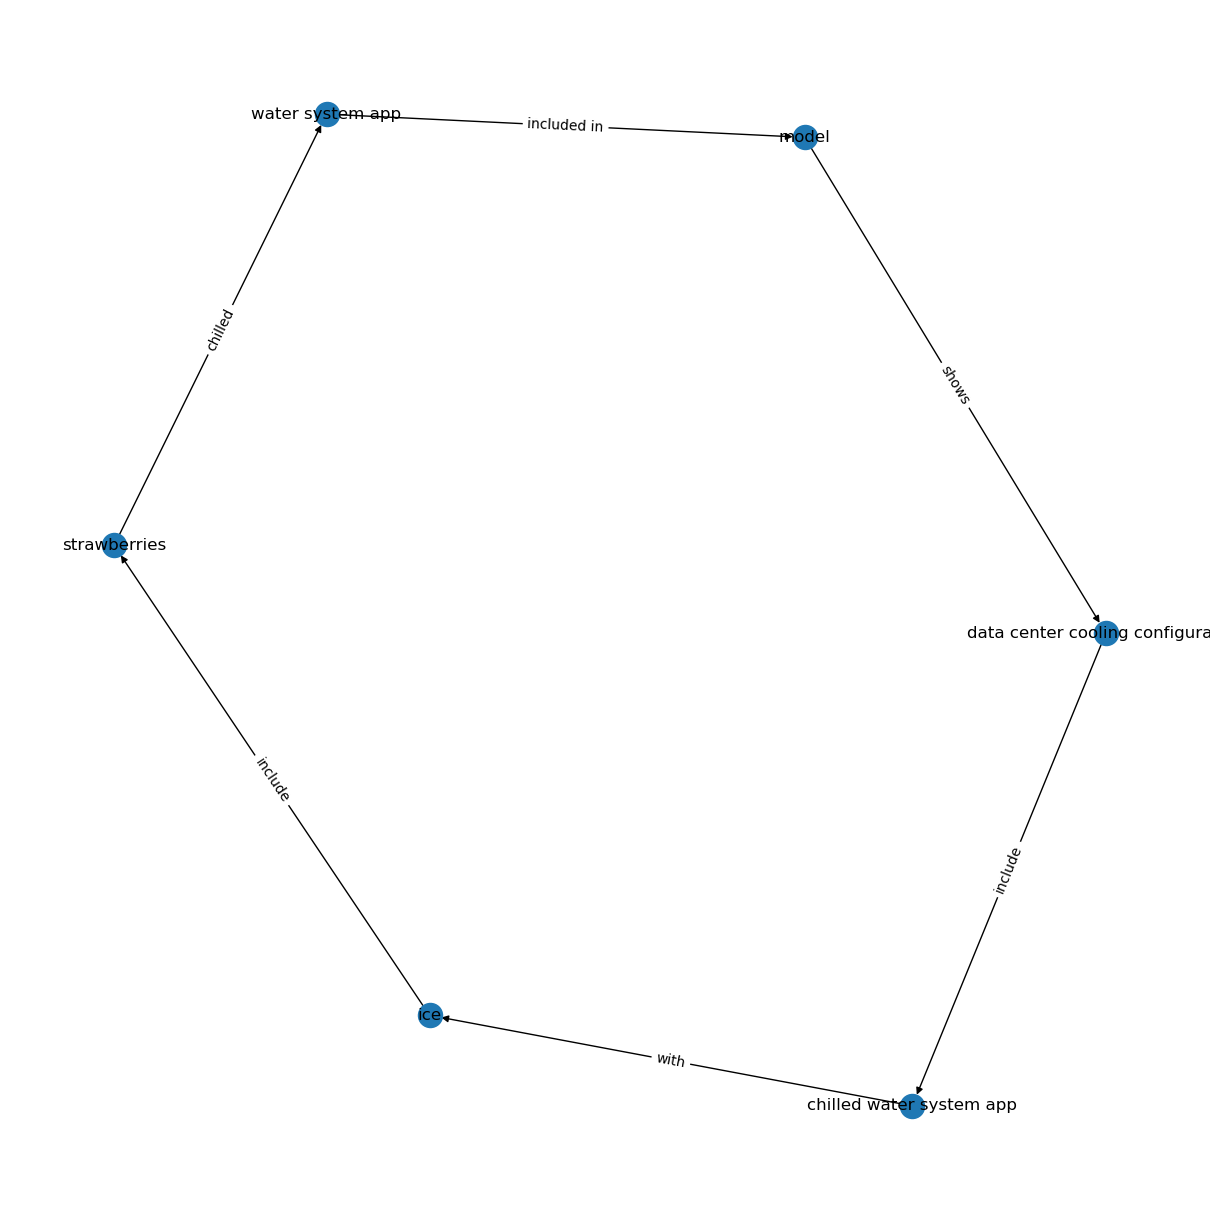

time: 418 ms (started: 2023-05-05 22:17:23 +00:00)


In [65]:
G = nx.from_pandas_edgelist(df, "source", "target",
                            edge_attr=True, create_using=nx.MultiDiGraph())
plt.figure(figsize=(12, 12))

pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, pos=pos)

# Add edge labels
edge_labels = {(row['source'], row['target']): row['edge']
               for _, row in df.iterrows()}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

plt.show()

In [66]:
print(cleanNshort)
doc=nlp(cleanNshort)
# displacy.render(doc, style="dep")
noun_chunks = get_noun_chunks(doc, remove_list, exclude_list)
predicates, sources, targets = get_predicates_between_noun_chunks(
    doc, noun_chunks)

displacy.render({'text': cleanNshort, 'ents': noun_chunks + predicates,
                'title': None}, style='ent', manual=True, jupyter=True, options={'colors': {"PRED": funkycolor}})

ception processing is performed. The signal that is output from the second processing unit, for example, is transmitted to a higher-layer apparatus in the wireless base station 100. The second processing unit, for example, performs transmission processing that is included in the second signal processing, on a signal that is input from a higher-layer apparatus in the wireless base station 100 into the wireless control apparatus, and outputs the signal on which the transmission processing is performed, to the IF processing unit. 
Based on the configuration information that is output from the IF processing unit, the control unit sets processing that is included in the second processing unit by the second signal processing. As an example, the control unit specifies processing that is included in the first signal processing by the wireless apparatus, which is in the base station signal processing, based on the configuration information, and sets processing that results from excluding the sp

time: 115 ms (started: 2023-05-05 22:17:24 +00:00)


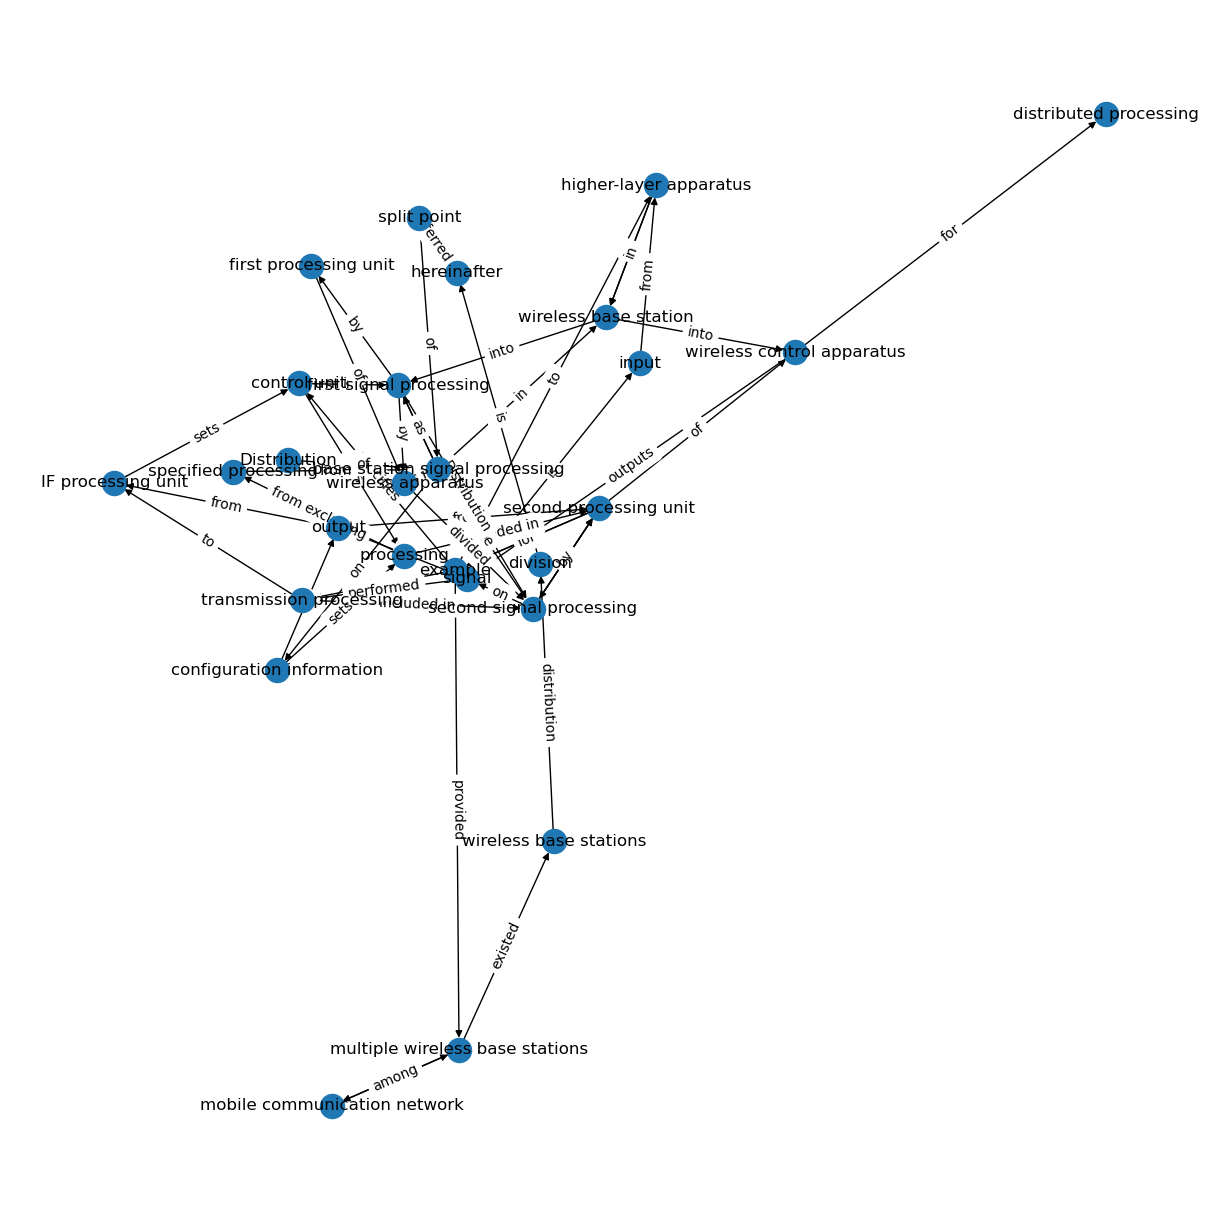

time: 1.03 s (started: 2023-05-05 22:17:25 +00:00)


In [67]:
df = pd.DataFrame({'source': [str(s) for s in sources], 
                    'target': [str(t) for t in targets], 
                    'edge': [r['text'] for r in predicates]})

G = nx.from_pandas_edgelist(df, "source", "target",
                            edge_attr=True, create_using=nx.MultiDiGraph())
plt.figure(figsize=(12, 12))

pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, pos=pos)

# Add edge labels
edge_labels = {(row['source'], row['target']): row['edge']
               for _, row in df.iterrows()}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

plt.show()

### Work with Prodigy

(the code here are just example of our work, we tried so many things to make it and this is only one example that wasn't on kaggle, so don't run it)

We tried to use prodigy to do Relation extraction but it was way harder than expected, the results without it with the rule based system was so good that we wanted to try to work only with spacy and prodigy to compare the results.


First we wanted to use prodigy to annotate relations using the prodigy model for the terms extractions as a base. So we converted our data into a JSONL file that have the text and the spans of our model because according to our research it's what we have to do.

In [68]:
# import spacy
# import json
# import re

# def split_patents(file_path):
#     with open(file_path, 'r') as file:
#         data = file.read()
#         # Split patents based on exactly two empty lines
#         patents = data.split("\n\n")
#     return patents

# def process_patent(patent, nlp):
#     doc = nlp(patent)
#     spans = []
#     tokens = []
#     for ent in doc.ents:
#         spans.append({
#             "start": ent.start_char,
#             "end": ent.end_char,
#             "label": ent.label_,
#             "token_start": ent.start,
#             "token_end": ent.end - 1
#         })
    
#     for token in doc:
#         tokens.append({
#             "text": token.text,
#             "start": token.idx,
#             "end": token.idx + len(token),
#             "id": token.i
#         })

#     return {"text": patent, "spans": spans if spans else [], "tokens": tokens}


# def main():
#     file_path = 'H04W.txt'
#     model_path = "./prodigy_output/model-best"
#     patents = split_patents(file_path)
#     nlp = spacy.load(model_path)

#     processed_data = []
#     for patent in patents:
#         processed_patent = process_patent(patent, nlp)
#         processed_data.append(processed_patent)

#     with open('processed_patents.jsonl', 'w') as outfile:
#         for patent in processed_data:
#             json.dump(patent, outfile)
#             outfile.write('\n')

# if __name__ == "__main__":
#     main()

time: 1.03 ms (started: 2023-05-05 22:17:27 +00:00)


You have an example of a processed patents in the data.

Then we created a recipe for relations annotations on it.

In [69]:
# import spacy
# import prodigy
# from prodigy.components.loaders import JSONL

# MAX_SENTENCE_LENGTH = 1500
# model_path = "./prodigy_output/model-best"
# nlp = spacy.load(model_path)
# nlp.add_pipe("sentencizer", before="ner")
# nlp.max_length = 3000000

# @prodigy.recipe("relation-annotation")
# def relation_annotation(dataset: str, source: str):
#     stream = JSONL(source)
    
#     def sentence_stream():
#         for eg in stream:
#             doc = nlp(eg["text"])
#             for sent in doc.sents:
#                 sent_doc = nlp(sent.text)
#                 spans = [ent for ent in sent_doc.ents]
                
#                 if len(sent.text) <= MAX_SENTENCE_LENGTH and spans:
#                     tokens = [
#                         {"text": token.text, "start": token.idx, "end": token.idx + len(token.text), "id": i}
#                         for i, token in enumerate(sent)
#                     ]
#                     spans_output = [{"start": span.start_char, "end": span.end_char, "label": span.label_, "token_start": span.start, "token_end": span.end} for span in spans]
#                     yield {
#                         "text": sent.text,
#                         "spans": spans_output,
#                         "tokens": tokens
#                     }

#     return {
#         "dataset": dataset,
#         "stream": sentence_stream(),
#         "view_id": "relations",
#         "config": {
#             "labels": ["USES_TECHNOLOGY", "PART_OF", "CONNECTS_TO", "IMPLEMENTS_PROTOCOL", "HAS_PROPERTY", "INVENTED_BY","SHOW","IS","SEND","RECEIVE"],
#             "span_labels": ["TECH", "TT"],
#         },
#     }


time: 1.16 ms (started: 2023-05-05 22:17:28 +00:00)


In [70]:
#!python -m prodigy relation-annotation prodigy-relation-test ./processed_patents.jsonl -F relation_annotation_recipe.py


time: 352 µs (started: 2023-05-05 22:17:28 +00:00)


We had a lot of problems trying to do this method, but in the end it was impossible to work on it because even when running it, prodigy was always buggy, slow and most of the time didn't even display the sentences completely or not at all. 

So we tried to start from 0 to make our model. 

We tried to start from scratch by applying the en_core_web_sm on our patents, while transforming them into JSONL and annotating the labels that seemed relevant only.

In order to create a relationship annotation environment for prodigy.

In [71]:
# import spacy
# import prodigy
# from prodigy.components.loaders import TXT
# from prodigy.util import write_jsonl
# from prodigy.components.loaders import TXT
# from prodigy.util import write_jsonl

# with open("H04W.txt", "r") as f:
#     raw_patents = f.read()
    
    
# import spacy

# nlp = spacy.load("en_core_web_sm")

# nlp.max_length = 2000000  


# def split_patents(text):
#     return text.split("\n\n")

# def split_paragraphs(patent):
#     return patent.split("\n")


# # Load the raw text from the file
# with open("H04W.txt", "r") as file:
#     raw_text = file.read()

# # Split the raw text into separate patents
# patents = split_patents(raw_text)  

# max_length = 1000000

# # Process each patent separately and extract relevant entities
# annotated_terms = []
# for patent in patents:
#     patent_terms = []
#     paragraphs = split_paragraphs(patent)
#     for paragraph in paragraphs:
#         doc = nlp(paragraph)
#         terms = [(ent.text, ent.start_char, ent.end_char, ent.label_) for ent in doc.ents if ent.label_ in {'ORG', 'PRODUCT', 'GPE','FAC','LOC','EVENT','WORK_OF_ART'}]
#         patent_terms.extend(terms)
#     annotated_terms.append(patent_terms)

time: 905 µs (started: 2023-05-05 22:17:29 +00:00)


In [72]:
# import json

# def create_prodigy_entry(text, terms):
#     spans = []
#     for term_text, start_char, end_char, label in terms:
#         spans.append({"start": start_char, "end": end_char, "label": label})
#     return {"text": text, "spans": spans}

# with open("pre_annotated_terms.jsonl", "w") as outfile:
#     for patent, terms in zip(patents, annotated_terms):
#         entry = create_prodigy_entry(patent, terms)
#         outfile.write(json.dumps(entry) + "\n")

time: 585 µs (started: 2023-05-05 22:17:30 +00:00)


In [73]:
#!python -m prodigy db-in wireless_comm_terms-test pre_annotated_terms.jsonl

time: 348 µs (started: 2023-05-05 22:17:30 +00:00)


In [74]:
#!python -m prodigy ner.manual wireless_comm_terms-test en_core_web_sm ./pre_annotated_terms.jsonl --label WIRELESS_TECH,NETWORK_COMPONENT,DEVICE,ALGORITHM

time: 350 µs (started: 2023-05-05 22:17:31 +00:00)


But in the end we didn't manage to do it, for example in this example a patent seems to be too big according to the error, that's why we tried to separate by paragraphs or by chunk of the maximum size, but it still didn't work and we decided to move on to something else not to waste too much time.

# Relation Extraction using Trankit and Spacy

## If running the notebook from here

### we downgrade spacy because neuralcoref doesn't work with spacy version 3.0.0 or above

In [75]:
# %%time

# !pip uninstall -q neuralcoref -y > /dev/null
# !pip install -q neuralcoref --no-binary neuralcoref > /dev/null

# !pip uninstall -q spacy -y > /dev/null
# !pip install -q -U spacy==2.0.12 > /dev/null
# !python -m spacy download en > /dev/null

time: 425 µs (started: 2023-05-05 22:17:33 +00:00)


### Import libraries

In [76]:
MODEL_URL = "https://github.com/huggingface/neuralcoref-models/releases/" \
            "download/en_coref_md-3.0.0/en_coref_md-3.0.0.tar.gz"

time: 482 µs (started: 2023-05-05 22:17:33 +00:00)


In [77]:
!pip install {MODEL_URL}

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.3/161.3 MB 7.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
  Created wheel for en-coref-md: filename=en_coref_md-3.0.0-cp37-cp37m-linux_x86_64.whl size=163902849 sha256=8f439eb863658a35107a860655152a1d93520838499000ae34334c828ce8388b
  Stored in directory: /root/.cache/pip/wheels/6b/f1/27/e43139d35a8a048aa96fcc2506ef03240f95e714ab40792ceb
Successfully built en-coref-md
time: 1min 12s (started: 2023-05-05 22:17:34 +00:00)


In [78]:
!python -m spacy download en_core_web_md

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 120.8/120.8 MB 62.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
  Created wheel for en_core_web_md: filename=en_core_web_md-2.0.0-py3-none-any.whl size=122523221 sha256=4aec7a1b2d8f2a8c7df15d70203b4442d34cfc3297a8383ca0862a545c572634
  Stored in directory: /tmp/pip-ephem-wheel-cache-1yjwcw1g/wheels/8f/51/ba/ba8005d45add03824093cb1029ec5cafdbd9bdf84f58612d0a
Successfully built en_core_web_md

    Linking successful
    /opt/conda/lib/python3.7/site-packages/en_core_web_md -->
    /opt/conda/lib/python3.7/site-packages/spacy/data/en_core_web_md

    You can now load the model via spacy.load('en_core_web_md')

time: 28.4 s (started: 2023-05-05 22:18:47 +00:00)


In [79]:
import re, regex, timeit, gzip, random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from tqdm.notebook import tqdm
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import spacy
#from sense2vec import Sense2Vec
from collections import Counter
from nltk.tokenize import MWETokenizer
from nltk.util import Trie
tqdm.pandas()
spacy.__version__ 
# !pip install jupyterlab-prodigy
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
import re
from tqdm import tqdm

time: 3.96 ms (started: 2023-05-05 22:19:15 +00:00)


In [80]:
# if you've already unzipped the file
h04w=open('/kaggle/input/d/gabrielbecquet/h04w-patent-file/H04W.txt').read().strip()

time: 506 ms (started: 2023-05-05 22:19:16 +00:00)


In [81]:
n = 3 # number of words to look for (before the potential reference numeral)
R = [] # R corpus list
N = [] # N corpus lsit

patent_texts = h04w.split('\n\n') # divide the text into each patent text (got this from the spacy part)

for t in patent_texts: # we will look at each patent
    numerals = dict() # keeping the record for each number what terms we have stored in the counter
    result = Counter() # the counter for the frequencies
    words = [word for line in t.split('\n') for word in line.split()] # list of all the words in the patent text
    for i,word in enumerate(words): # we will look at all of them in the correct order
        if i>n and (word.isdigit() or (word[1:-1].isdigit() and word[0] == "(" and word[-1] == ")")): # make sure to not go overbound and that we have found a number
            key = words[i] # get the number
            result[key]=result.get(key,0)+1 # update the frequency by 1
            for j in range(1,n+1): # we will look at the words before the number
                term = '_'.join(words[i-j:i+1]) # get the term
                result[term]=result.get(term,0)+1 # update the frequency by 1
                try: # and add the term to the set of terms related to the number
                    numerals[key].add(term)
                except KeyError:
                    numerals[key] = {term}
                    
    # counting potential reference numerals
    cpt = 0
    listPotentialReferenceTerms = [] # to keep the potential terms
    for nb,setT in numerals.items(): # we will look at all the numbers we have found in the patent text and their set of terms
        maxIteration = result.get(nb) # number of time we have seen this number
        maxTF = 0 # store the max frequency
        maxTL = 0 # store the max length
        maxT = None # store the term with the max frequency
        for s in setT: # we look at all the terms for this number
            if result.get(s) > maxTF : # update the max
                maxTF = result.get(s)
                maxT = s
                maxTL = len(s.split('_'))
            elif result.get(s) == maxTF and len(s.split('_')) > maxTL:
                maxTF = result.get(s)
                maxT = s
                maxTL = len(s.split('_'))
        if maxIteration > 1 and maxTF > (maxIteration*80/100): 
        # numbers that appear 1 time doesn't provide enough statistical information 
        # and we want the term to have appeared at least 80% from the time we saw the number            
            cpt += 1
            listPotentialReferenceTerms.append((maxT,maxTF)) # store the potential terms for this patent
#             print(nb," : ",maxIteration," | ",maxT," : ",maxTF)
    
    if cpt > (len(numerals.keys())*50/100): # if more than 50% of numerals are potential reference than we store the corpus in R
        R.append((t,listPotentialReferenceTerms))
    else :
        N.append((t,listPotentialReferenceTerms))
#     print(cpt,' vs ',len(numerals.keys()))
#     print(result.most_common(10))
#     print(numerals)
    
print("R : ",len(R)," N : ",len(N))      

R :  373  N :  1628
time: 21.6 s (started: 2023-05-05 22:19:17 +00:00)


## Trying Trankit to build the noun chunks and then Spacy to extract relations

* Paper : https://arxiv.org/pdf/2101.03289.pdf
* Documentation : https://trankit.readthedocs.io/en/latest/
* Github repo : https://github.com/nlp-uoregon/trankit
* Demo website : http://nlp.uoregon.edu/trankit

### Let's install trankit first

In [82]:
!pip install trankit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 773.4/773.4 kB 20.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 880.6/880.6 kB 36.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895260 sha256=83428ce8e16cf4ace95e153aff3b45c33b3c758ce1180240d86443df241e0141
  Stored in directory: /root/.cache/pip/wheels/5b/e0/77/05245143a5b31f65af6a21f7afd3219e9fa4896f918af45677
Successfully built sacremoses
time: 15.5 s (started: 2023-05-05 22:19:40 +00:00)


### Import libraries

In [83]:
import trankit
from trankit import Pipeline
from collections import Counter
# !python -m spacy download en_core_web_lg
# import spacy
from spacy.matcher import PhraseMatcher
from spacy import displacy
from spacy.tokens import Span
import pandas as pd 
import networkx as nx
import matplotlib.pyplot as plt

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


time: 16.4 s (started: 2023-05-05 22:19:56 +00:00)


### Import nlp with Spacy [used later for Relation Extraction]

In [84]:
# load vocab
nlp = spacy.load("en_core_web_sm")

time: 777 ms (started: 2023-05-05 22:20:14 +00:00)


### Import the Trankit pipeline using XLM-Roberta

In [85]:
# initialize a multilingual pipeline
p = Pipeline(lang='english', gpu=True, cache_dir='./cache')

Downloading:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

http://nlp.uoregon.edu/download/trankit/v1.0.0/xlm-roberta-base/english.zip


Downloading: 100%|██████████| 47.9M/47.9M [00:03<00:00, 12.5MiB/s]


Loading pretrained XLM-Roberta, this may take a while...


Downloading:   0%|          | 0.00/512 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Loading tokenizer for english
Loading tagger for english
Loading lemmatizer for english
Loading NER tagger for english
Active language: english
time: 45.6 s (started: 2023-05-05 22:20:15 +00:00)


### Let's discover a bit this tool

In [86]:
text = '''Hello! This is Trankit.'''

# perform all tasks on the input
all = p(text)

# OR only the one we need
sents = p.ssplit(text)
tokens = p.tokenize(text)
posdeps = p.posdep(text)
ners = p.ner(text)
lemmas = p.lemmatize(text)

time: 5.78 s (started: 2023-05-05 22:21:02 +00:00)


In [87]:
print(sents)

{'text': 'Hello! This is Trankit.', 'sentences': [{'id': 1, 'text': 'Hello!', 'dspan': (0, 6)}, {'id': 2, 'text': 'This is Trankit.', 'dspan': (7, 23)}], 'lang': 'english'}
time: 839 µs (started: 2023-05-05 22:21:08 +00:00)


In [88]:
print(tokens)

{'text': 'Hello! This is Trankit.', 'sentences': [{'id': 1, 'text': 'Hello!', 'tokens': [{'id': 1, 'text': 'Hello', 'dspan': (0, 5), 'span': (0, 5)}, {'id': 2, 'text': '!', 'dspan': (5, 6), 'span': (5, 6)}], 'dspan': (0, 6)}, {'id': 2, 'text': 'This is Trankit.', 'tokens': [{'id': 1, 'text': 'This', 'dspan': (7, 11), 'span': (0, 4)}, {'id': 2, 'text': 'is', 'dspan': (12, 14), 'span': (5, 7)}, {'id': 3, 'text': 'Trankit', 'dspan': (15, 22), 'span': (8, 15)}, {'id': 4, 'text': '.', 'dspan': (22, 23), 'span': (15, 16)}], 'dspan': (7, 23)}], 'lang': 'english'}
time: 500 µs (started: 2023-05-05 22:21:08 +00:00)


In [89]:
print(posdeps)

{'text': 'Hello! This is Trankit.', 'sentences': [{'id': 1, 'text': 'Hello!', 'tokens': [{'id': 1, 'text': 'Hello', 'upos': 'INTJ', 'xpos': 'UH', 'head': 0, 'deprel': 'root', 'dspan': (0, 5), 'span': (0, 5)}, {'id': 2, 'text': '!', 'upos': 'PUNCT', 'xpos': '.', 'head': 1, 'deprel': 'punct', 'dspan': (5, 6), 'span': (5, 6)}], 'dspan': (0, 6)}, {'id': 2, 'text': 'This is Trankit.', 'tokens': [{'id': 1, 'text': 'This', 'upos': 'PRON', 'xpos': 'DT', 'feats': 'Number=Sing|PronType=Dem', 'head': 3, 'deprel': 'nsubj', 'dspan': (7, 11), 'span': (0, 4)}, {'id': 2, 'text': 'is', 'upos': 'AUX', 'xpos': 'VBZ', 'feats': 'Mood=Ind|Number=Sing|Person=3|Tense=Pres|VerbForm=Fin', 'head': 3, 'deprel': 'cop', 'dspan': (12, 14), 'span': (5, 7)}, {'id': 3, 'text': 'Trankit', 'upos': 'PROPN', 'xpos': 'NNP', 'feats': 'Number=Sing', 'head': 0, 'deprel': 'root', 'dspan': (15, 22), 'span': (8, 15)}, {'id': 4, 'text': '.', 'upos': 'PUNCT', 'xpos': '.', 'head': 3, 'deprel': 'punct', 'dspan': (22, 23), 'span': (15

In [90]:
print(ners)

{'text': 'Hello! This is Trankit.', 'sentences': [{'id': 1, 'text': 'Hello!', 'tokens': [{'id': 1, 'text': 'Hello', 'dspan': (0, 5), 'span': (0, 5), 'ner': 'O'}, {'id': 2, 'text': '!', 'dspan': (5, 6), 'span': (5, 6), 'ner': 'O'}], 'dspan': (0, 6)}, {'id': 2, 'text': 'This is Trankit.', 'tokens': [{'id': 1, 'text': 'This', 'dspan': (7, 11), 'span': (0, 4), 'ner': 'O'}, {'id': 2, 'text': 'is', 'dspan': (12, 14), 'span': (5, 7), 'ner': 'O'}, {'id': 3, 'text': 'Trankit', 'dspan': (15, 22), 'span': (8, 15), 'ner': 'S-PER'}, {'id': 4, 'text': '.', 'dspan': (22, 23), 'span': (15, 16), 'ner': 'O'}], 'dspan': (7, 23)}], 'lang': 'english'}
time: 515 µs (started: 2023-05-05 22:21:09 +00:00)


In [91]:
print(lemmas)

{'text': 'Hello! This is Trankit.', 'sentences': [{'id': 1, 'text': 'Hello!', 'tokens': [{'id': 1, 'text': 'Hello', 'dspan': (0, 5), 'span': (0, 5), 'lemma': 'hello'}, {'id': 2, 'text': '!', 'dspan': (5, 6), 'span': (5, 6), 'lemma': '!'}], 'dspan': (0, 6)}, {'id': 2, 'text': 'This is Trankit.', 'tokens': [{'id': 1, 'text': 'This', 'dspan': (7, 11), 'span': (0, 4), 'lemma': 'this'}, {'id': 2, 'text': 'is', 'dspan': (12, 14), 'span': (5, 7), 'lemma': 'be'}, {'id': 3, 'text': 'Trankit', 'dspan': (15, 22), 'span': (8, 15), 'lemma': 'Trankit'}, {'id': 4, 'text': '.', 'dspan': (22, 23), 'span': (15, 16), 'lemma': '.'}], 'dspan': (7, 23)}], 'lang': 'english'}
time: 598 µs (started: 2023-05-05 22:21:10 +00:00)


### posdeps and ners seems promising for creating noun chunks !

In [92]:
text = '''An audio circuit 960, a speaker 961, and a microphone 962 may provide an audio interface between a user and a mobile phone.'''

time: 538 µs (started: 2023-05-05 22:21:10 +00:00)


In [93]:
def get_freq_posdep(text):
    posdeps = p.posdep(text)
    result = Counter() # the counter for the frequencies
    for s in posdeps['sentences']:
        start = False
        mwt = ""
        for i in range(len(s['tokens'])):
            if s['tokens'][i]['upos'] in ["ADJ","NOUN"]:
                if start:
                    mwt += s['tokens'][i]['text'] + " "
                else :
                    start = True
                    mwt += s['tokens'][i]['text'] + " "
            else :
                if start:
                    result[mwt[:-1]]=result.get(mwt[:-1],0)+1 # update the frequency by 1
                    start = False
                    mwt = ""
    return result

time: 2.17 ms (started: 2023-05-05 22:21:11 +00:00)


In [94]:
ct = get_freq_posdep(text)
print(ct.most_common(10))

[('audio circuit', 1), ('speaker', 1), ('microphone', 1), ('audio interface', 1), ('user', 1), ('mobile phone', 1)]
time: 915 ms (started: 2023-05-05 22:21:11 +00:00)


In [95]:
def get_freq_ner(text):
    ners = p.ner(text)
    result = Counter() # the counter for the frequencies
    for s in ners['sentences']:
        start = False
        mwt = ""
        for i in range(len(s['tokens'])):
            if s['tokens'][i]['ner'] not in ["O"]:
                if start:
                    mwt += s['tokens'][i]['text'] + " "
                else :
                    start = True
                    mwt += s['tokens'][i]['text'] + " "
            else :
                if start:
                    result[mwt[:-1]]=result.get(mwt[:-1],0)+1 # update the frequency by 1
                    start = False
                    mwt = ""
    return result

time: 1.32 ms (started: 2023-05-05 22:21:13 +00:00)


In [96]:
ct = get_freq_ner(text)
print(ct.most_common(10))

[]
time: 922 ms (started: 2023-05-05 22:21:13 +00:00)


### NER detection is bad !! we could train a ner pipeline but we will just stick to posdeps for simplicity

### But how does it work with list of list of string ? can we really just use raw text ?

In [97]:
text = '''An audio circuit 960, a speaker 961, and a microphone 962 may provide an audio interface between a user and a mobile phone.'''
tokens = p.tokenize(text)
text_list = [ [t['text'] for t in s['tokens']] for s in tokens['sentences'] ]
print(text_list)

[['An', 'audio', 'circuit', '960', ',', 'a', 'speaker', '961', ',', 'and', 'a', 'microphone', '962', 'may', 'provide', 'an', 'audio', 'interface', 'between', 'a', 'user', 'and', 'a', 'mobile', 'phone', '.']]
time: 755 ms (started: 2023-05-05 22:21:15 +00:00)


In [98]:
posdeps = p.posdep(text_list)
print(posdeps)

{'sentences': [{'id': 1, 'tokens': [{'id': 1, 'text': 'An', 'upos': 'DET', 'xpos': 'DT', 'feats': 'Definite=Ind|PronType=Art', 'head': 3, 'deprel': 'det'}, {'id': 2, 'text': 'audio', 'upos': 'NOUN', 'xpos': 'NN', 'feats': 'Number=Sing', 'head': 3, 'deprel': 'compound'}, {'id': 3, 'text': 'circuit', 'upos': 'NOUN', 'xpos': 'NN', 'feats': 'Number=Sing', 'head': 15, 'deprel': 'nsubj'}, {'id': 4, 'text': '960', 'upos': 'NUM', 'xpos': 'CD', 'feats': 'NumType=Card', 'head': 3, 'deprel': 'nummod'}, {'id': 5, 'text': ',', 'upos': 'PUNCT', 'xpos': ',', 'head': 7, 'deprel': 'punct'}, {'id': 6, 'text': 'a', 'upos': 'DET', 'xpos': 'DT', 'feats': 'Definite=Ind|PronType=Art', 'head': 7, 'deprel': 'det'}, {'id': 7, 'text': 'speaker', 'upos': 'NOUN', 'xpos': 'NN', 'feats': 'Number=Sing', 'head': 3, 'deprel': 'conj'}, {'id': 8, 'text': '961', 'upos': 'NUM', 'xpos': 'CD', 'feats': 'NumType=Card', 'head': 7, 'deprel': 'nummod'}, {'id': 9, 'text': ',', 'upos': 'PUNCT', 'xpos': ',', 'head': 12, 'deprel': '

### the only thing we missed is the whole text string :
 - instead of {text:...,sentences:....,lang:...}
 - we have {sentences:....,lang:...}

### so we might be able to use the raw text but what about the "\n" ?

In [99]:
text = '''Hello! This\n is Trankit.'''

tokens = p.tokenize(text)
print(tokens)

{'text': 'Hello! This\n is Trankit.', 'sentences': [{'id': 1, 'text': 'Hello!', 'tokens': [{'id': 1, 'text': 'Hello', 'dspan': (0, 5), 'span': (0, 5)}, {'id': 2, 'text': '!', 'dspan': (5, 6), 'span': (5, 6)}], 'dspan': (0, 6)}, {'id': 2, 'text': 'This\n is Trankit.', 'tokens': [{'id': 1, 'text': 'This', 'dspan': (7, 11), 'span': (0, 4)}, {'id': 2, 'text': 'is', 'dspan': (13, 15), 'span': (6, 8)}, {'id': 3, 'text': 'Trankit', 'dspan': (16, 23), 'span': (9, 16)}, {'id': 4, 'text': '.', 'dspan': (23, 24), 'span': (16, 17)}], 'dspan': (7, 24)}], 'lang': 'english'}
time: 743 ms (started: 2023-05-05 22:21:18 +00:00)


### The "\n" isn't tokenize and the sentence split works nicely

### Time to try on the patent texts !

In [100]:
h04w=open('/kaggle/input/d/gabrielbecquet/h04w-patent-file/H04W.txt').read().strip()

patent_texts = h04w.split('\n\n') # divide the text into each patent text


time: 828 ms (started: 2023-05-05 22:21:20 +00:00)


In [101]:
ct = get_freq_posdep(patent_texts[0])
print(ct.most_common(20))

[('example', 324), ('signal', 309), ('wireless control apparatus', 209), ('FIG.', 191), ('wireless apparatus', 163), ('wireless base station', 158), ('CU', 135), ('base station signal processing', 122), ('first signal processing', 120), ('DU', 119), ('configuration information', 116), ('transfer path', 115), ('IF processing unit', 104), ('wireless terminal', 102), ('split point', 97), ('second signal processing', 85), ('processing', 83), ('case', 64), ('Step', 63), ('identification information', 56)]
time: 3min 4s (started: 2023-05-05 22:21:21 +00:00)


### 'processing','FIG.','Step','case' all these are not terms !! We have to make it better

## Let's put everything into a function

### Every ADJ and NOUN tokens that follow each others are captured as noun chunks

In [102]:
def get_noun_chunks(t):
    noun_chunks = [] # list of all the noun chunks we will find
    posdeps = p.posdep(t) # trankit posdep
    for s in posdeps['sentences']: # for each sentence
        start = False # boolean to know if we are currently adding tokens to a noun chunk
        mwt = "" # noun chunk text
        chunk_start = 0 # index of the start of the noun chunk
        chunk_end = 0 # index of the end of the noun chunk
        for i in range(len(s['tokens'])): # we go throught all the tokens
            if s['tokens'][i]['upos'] in ["ADJ","NOUN"] or (s['tokens'][i]["text"] in ["-"] and start): # if can be a part of a noun chunk
                if start: # if it's in a noun chunk being creating
                    mwt += s['tokens'][i]['text'] + " "
                    chunk_end = s['tokens'][i]['dspan'][1]
                else : # first token of a new noun chunk we will create
                    start = True
                    mwt += s['tokens'][i]['text'] + " "
                    chunk_start = s['tokens'][i]['dspan'][0]
                    chunk_end = s['tokens'][i]['dspan'][1]
            else :
                if start: # if we have ended finding ADJ and NOUN for the noun chunk, we save it
                    noun_chunks.append({'start': chunk_start,
                                        'end': chunk_end,
                                        'label': 'NC',
                                        'text': mwt[:-1]
                                        })
                    start = False # reset
                    mwt = "" # reset
    return noun_chunks

time: 2.22 ms (started: 2023-05-05 22:24:27 +00:00)


In [103]:
noun_chunks = get_noun_chunks(patent_texts[0][:2000])
funkycolor = "linear-gradient(90deg, #aa9cfc, #fc9ce7)"
displacy.render({'text': patent_texts[0][:2000], 'ents': noun_chunks, 'title': None,"settings": {}},style='ent', options={'colors': {"NC": funkycolor}}, manual=True, jupyter=True)

time: 4.25 s (started: 2023-05-05 22:24:28 +00:00)


### let's create a function to remove undesired words from the noun chunks

In [104]:
def clean_noun_chunks(noun_chunks, remove_list=[], exclude_list=[]):
    new_noun_chunks = [] # new list of noun chunks filtered
    for chunk in noun_chunks: # we go throught all the noun chunks
        # get rid if it have an exclude word
        exclude_list += ['that', 'which','FIG', 'FIGS','FIG.','such']
        if any(token in exclude_list for token in chunk["text"].split()):
            continue
        # or have a fully upper case word   
        if any(token.isupper() for token in chunk["text"].split()):
            continue
        # delete the remove words from the noun chunk    
        filtered_tokens = [
            token for token in chunk["text"].split()
            if token not in remove_list ]
        # if it ended up being empty
        if not filtered_tokens:
            continue
        # the noun chunk filtered
        chunk_text = ' '.join(token for token in filtered_tokens)
        # chunk_text = chunk_text.replace('"', '').replace("'", "")
        
        # to get the distance from the new start index
        distance = 0
        for token in chunk["text"].split():
            if token in remove_list:
                distance += len(token)+1
            else :
                break
        
            
        start_char = chunk["start"] + distance
        end_char = start_char + len(chunk_text)

        new_noun_chunks.append({
            'start': start_char,
            'end': end_char,
            'label': chunk["label"],
            'text': chunk_text
        })

    return new_noun_chunks

time: 2.04 ms (started: 2023-05-05 22:24:33 +00:00)


In [105]:
remove_list = []
exclude_list = ['Split','Step','case']

new_noun_chunks = clean_noun_chunks(noun_chunks, remove_list, exclude_list)

displacy.render({'text': patent_texts[0][:2000], 'ents': new_noun_chunks, 'title': None,"settings": {}},
                style='ent', manual=True, jupyter=True)

time: 5.43 ms (started: 2023-05-05 22:24:33 +00:00)


### seems nice even though there is minor issue with the noun chunks like "4-th generation mobile etc..." but not capturing "3.9-th generation mobile etc...."

### Here is another case where it's trankit fault

In [106]:
t = "The model that is presented in FIGS 1 and 2 shows a data center cooling configuration that can include a chilled water system app with ice that must not include strawberries. The strawberries choke the said chilled water system app that is included in the model."


noun_chunks = get_noun_chunks(t)
new_noun_chunks = clean_noun_chunks(noun_chunks, remove_list, exclude_list)

displacy.render({'text': t, 'ents': new_noun_chunks, 'title': None,"settings": {}},
                style='ent', manual=True, jupyter=True)

time: 1.01 s (started: 2023-05-05 22:24:34 +00:00)


In [107]:
t = "The model that is presented in FIGS 1 and 2 shows a data center cooling configuration that can include a chilled water system app with ice that must not include strawberries. The strawberries choke the said chilled water system app that is included in the model."
tmp = p.posdep(t)
for s in tmp['sentences']:
    for i in range(len(s['tokens'])):
        if s['tokens'][i]['text'] in ["chilled"]:
            print(s['tokens'][i]['upos'])

VERB
ADJ
time: 995 ms (started: 2023-05-05 22:24:36 +00:00)


### it's not our fault :( , we can't possibly add VERB to our noun chunks

### but we better focus on our patent texts 

In [108]:
doc = "An audio circuit 960, a speaker 961, and a microphone 962 may provide an audio interface between a user and a mobile phone. The audio circuit 960 may transmit the received audio data converted electrical signal to the speaker 961, and convert the audio signal from the speaker 961 to a sound signal for playback. On the other hand, the microphone 962 converts the collected sound signal into an electrical signal, receives it by the audio circuit 960, converts it into audio data, processes it by the audio data playback processor 980, transmits it to another mobile phone, for example, via the RF circuit 910, or plays the audio data to the memory 920 for further processing. \
WiFi belongs to a short-range wireless transmission technology, and the mobile phone can help the user receive and send e-mail, browse web pages, access streaming media, and the like through the WiFi module 970, which provides the user with wireless broadband Internet access. Although FIG. 7 shows the WiFi module 970, it is understood that it does not belong to the mandatory structure of the mobile phone and may be omitted as necessary without changing the essence of the disclosure. \
The processor 980 is the control center of the mobile phone, connecting the parts of the entire mobile phone using various interfaces and lines, performing various functions and processing data of the mobile phone by running or executing a software program and/or module stored in the memory 920, and invoking data stored in the memory 920, thereby performing overall monitoring of the mobile phone. Optionally, processor 980 may include one or more processing units. Preferably, the processor 980 may integrate an application processor and a modem processor, wherein the application processor mainly processes an operating system, a user interface, an application program, and the like, and the modem processor mainly processes wireless communications. It is understood that the above-described modem processor may also not be integrated into the processor 980."


noun_chunks = get_noun_chunks(doc)
exclude_list += ['necessary','like']
remove_list += ['more','further','overall']
new_noun_chunks = clean_noun_chunks(noun_chunks, remove_list, exclude_list)

displacy.render({'text': doc, 'ents': new_noun_chunks, 'title': None,"settings": {}},
                style='ent', manual=True, jupyter=True)

time: 2.7 s (started: 2023-05-05 22:24:38 +00:00)


### Looks good enough to start the Relations Extraction with Spacy !

In [109]:
# function from the TP5 
def get_predicates_between_noun_chunks(doc, noun_chunks):
    predicates = []
    sources = []
    targets = []

    for i in range(len(noun_chunks) - 1):
        start_chunk_token = doc.char_span(
            noun_chunks[i]['start'], noun_chunks[i]['end'])
        end_chunk_token = doc.char_span(
            noun_chunks[i + 1]['start'], noun_chunks[i + 1]['end'])
        
        if start_chunk_token is None or end_chunk_token is None or start_chunk_token.sent != end_chunk_token.sent:
            continue

        # Find the shortest path between the root tokens of the neighboring noun chunks
        start_token = start_chunk_token.root
        end_token = end_chunk_token.root

        # not ideal, can possibly be shortened:
        predicate_tokens = []
        if start_token in end_token.ancestors:
            ancs = end_token.ancestors
            stop = start_token
        elif end_token in start_token.ancestors:
            ancs = start_token.ancestors
            stop = end_token
        else:
            for token in end_token.ancestors:
                predicate_tokens.append(token)
                if token in end_token.ancestors:
                    break
            ancs = end_token.ancestors
            stop = token
        for tok in ancs:
            if tok == stop:
                break
            predicate_tokens += [tok]
    

        if not predicate_tokens:
            continue
        predicate_tokens = sorted(
            predicate_tokens, key=lambda token: token.i)
        predicate_text = ' '.join(token.text for token in predicate_tokens)
        start_char = predicate_tokens[0].idx
        end_char = start_char + len(predicate_text)
        
        predicates.append({
            'start': start_char,
            'end': end_char,
            'label': 'PRED',
            'text': predicate_text
        })
        sources += [start_chunk_token]
        targets += [end_chunk_token]
        # print(
        #     f'{predicate_text} :: {start_chunk_token} _______ { end_chunk_token}')

    return predicates, sources, targets

time: 2.56 ms (started: 2023-05-05 22:24:42 +00:00)


### let's first take a quick look at the "easy" sentence

In [110]:
text = "The model that is presented in FIGS 1 and 2 shows a data center cooling configuration that can include a chilled water system app with ice that must not include strawberries. The strawberries choke the said chilled water system app that is included in the model."
# text = "the said data center cooling configuration that is included in the model."
doc = nlp(text)
# displacy.render(doc, style="dep")
noun_chunks = get_noun_chunks(text)
new_noun_chunks = clean_noun_chunks(noun_chunks, remove_list, exclude_list)
predicates, sources, targets = get_predicates_between_noun_chunks(
    doc, new_noun_chunks)

# the sorting of 2 list is necessary since we use an old version of spacy
# concatenate the two lists
combined_list = new_noun_chunks + predicates

# sort the combined list based on the 'start' attribute
sorted_list = sorted(combined_list, key=lambda x: x['start'])

displacy.render({'text': text, 'ents': sorted_list,
                'title': None,"settings": {}}, style='ent', manual=True, jupyter=True, options={'colors': {"PRED": funkycolor}})

time: 1.11 s (started: 2023-05-05 22:24:43 +00:00)


### we got a pretty bad one predicate

In [111]:
text = "An audio circuit 960, a speaker 961, and a microphone 962 may provide an audio interface between a user and a mobile phone. The audio circuit 960 may transmit the received audio data converted electrical signal to the speaker 961, and convert the audio signal from the speaker 961 to a sound signal for playback. On the other hand, the microphone 962 converts the collected sound signal into an electrical signal, receives it by the audio circuit 960, converts it into audio data, processes it by the audio data playback processor 980, transmits it to another mobile phone, for example, via the RF circuit 910, or plays the audio data to the memory 920 for further processing. \
WiFi belongs to a short-range wireless transmission technology, and the mobile phone can help the user receive and send e-mail, browse web pages, access streaming media, and the like through the WiFi module 970, which provides the user with wireless broadband Internet access. Although FIG. 7 shows the WiFi module 970, it is understood that it does not belong to the mandatory structure of the mobile phone and may be omitted as necessary without changing the essence of the disclosure. \
The processor 980 is the control center of the mobile phone, connecting the parts of the entire mobile phone using various interfaces and lines, performing various functions and processing data of the mobile phone by running or executing a software program and/or module stored in the memory 920, and invoking data stored in the memory 920, thereby performing overall monitoring of the mobile phone. Optionally, processor 980 may include one or more processing units. Preferably, the processor 980 may integrate an application processor and a modem processor, wherein the application processor mainly processes an operating system, a user interface, an application program, and the like, and the modem processor mainly processes wireless communications. It is understood that the above-described modem processor may also not be integrated into the processor 980."
# text = "the said data center cooling configuration that is included in the model."
doc = nlp(text)
# displacy.render(doc, style="dep")
noun_chunks = get_noun_chunks(text)
new_noun_chunks = clean_noun_chunks(noun_chunks, remove_list, exclude_list)
predicates, sources, targets = get_predicates_between_noun_chunks(
    doc, new_noun_chunks)

# concatenate the two lists
combined_list = new_noun_chunks + predicates

# sort the combined list based on the 'start' attribute
sorted_list = sorted(combined_list, key=lambda x: x['start'])

displacy.render({'text': text, 'ents': sorted_list,
                'title': None,"settings": {}}, style='ent', manual=True, jupyter=True, options={'colors': {"PRED": funkycolor}})

time: 2.88 s (started: 2023-05-05 22:24:45 +00:00)


### even worse ! we have multiple identical PRED and don't know between what !!

In [112]:
text = "An audio circuit 960, a speaker 961, and a microphone 962 may provide an audio interface between a user and a mobile phone."
doc = nlp(text)
# displacy.render(doc, style="dep")
noun_chunks = get_noun_chunks(text)
new_noun_chunks = clean_noun_chunks(noun_chunks, remove_list, exclude_list)
predicates, sources, targets = get_predicates_between_noun_chunks(
    doc, new_noun_chunks)

# concatenate the two lists
combined_list = new_noun_chunks + predicates

# sort the combined list based on the 'start' attribute
sorted_list = sorted(combined_list, key=lambda x: x['start'])

displacy.render({'text': text, 'ents': sorted_list,
                'title': None,"settings": {}}, style='ent', manual=True, jupyter=True, options={'colors': {"PRED": funkycolor}})

time: 1.04 s (started: 2023-05-05 22:24:48 +00:00)


### A nice exemple to work on and dive into these predicates

###  Let's create a visualization to make the changes easier

In [113]:
def show(sources,targets,predicates):
    df = pd.DataFrame({'source': [str(s) for s in sources], 
                        'target': [str(t) for t in targets], 
                        'edge': [r['text'] for r in predicates]})

    G = nx.from_pandas_edgelist(df, "source", "target",
                                edge_attr=True, create_using=nx.MultiDiGraph())
    plt.figure(figsize=(12, 12))

    pos = nx.spring_layout(G)
    nx.draw(G, with_labels=True, pos=pos)

    # Add edge labels
    edge_labels = {(row['source'], row['target']): row['edge']
                   for _, row in df.iterrows()}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

    plt.show()

time: 1.4 ms (started: 2023-05-05 22:24:51 +00:00)


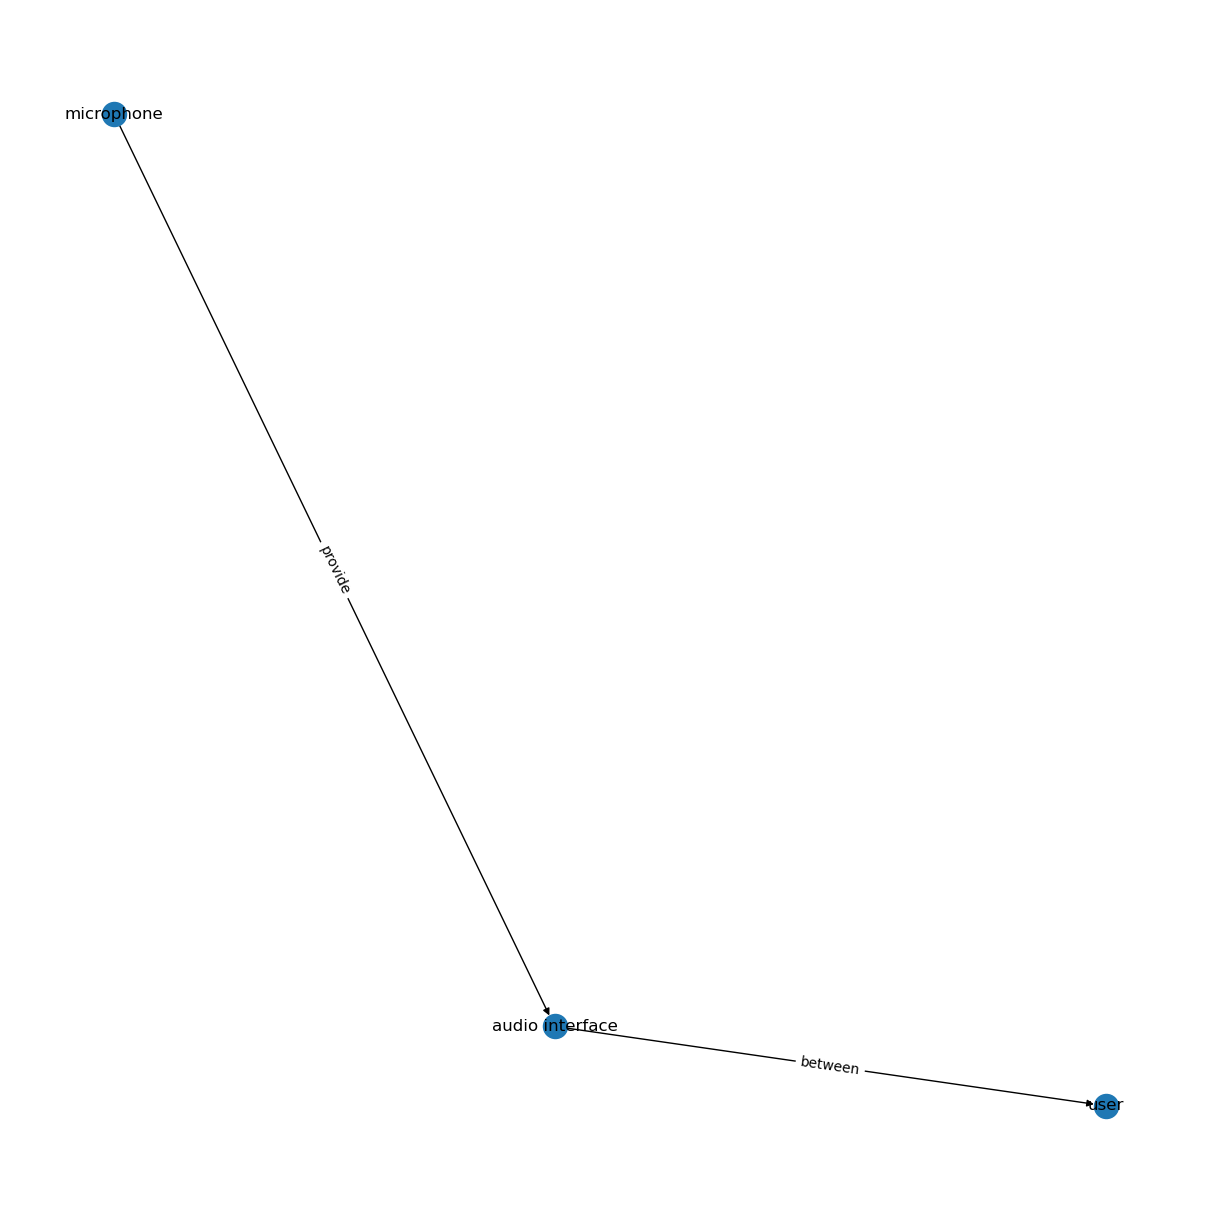

time: 323 ms (started: 2023-05-05 22:24:51 +00:00)


In [114]:
show(sources,targets,predicates)

### not working at all but the sentence is quite hard too so we will have to implement group relations
### but before doing so can we check that binary relation are correct at least ?

In [115]:
text = "The processor 980 is the control center of the mobile phone, connecting the parts of the entire mobile phone using various interfaces and lines, performing various functions and processing data of the mobile phone by running or executing a software program and/or module stored in the memory 920, and invoking data stored in the memory 920, thereby performing overall monitoring of the mobile phone."
doc = nlp(text)
# displacy.render(doc, style="dep")
noun_chunks = get_noun_chunks(text)
new_noun_chunks = clean_noun_chunks(noun_chunks, remove_list, exclude_list)
predicates, sources, targets = get_predicates_between_noun_chunks(
    doc, new_noun_chunks)

# concatenate the two lists
combined_list = new_noun_chunks + predicates

# sort the combined list based on the 'start' attribute
sorted_list = sorted(combined_list, key=lambda x: x['start'])

displacy.render({'text': text, 'ents': sorted_list,
                'title': None,"settings": {}}, style='ent', manual=True, jupyter=True, options={'colors': {"PRED": funkycolor}})

time: 1.11 s (started: 2023-05-05 22:24:52 +00:00)


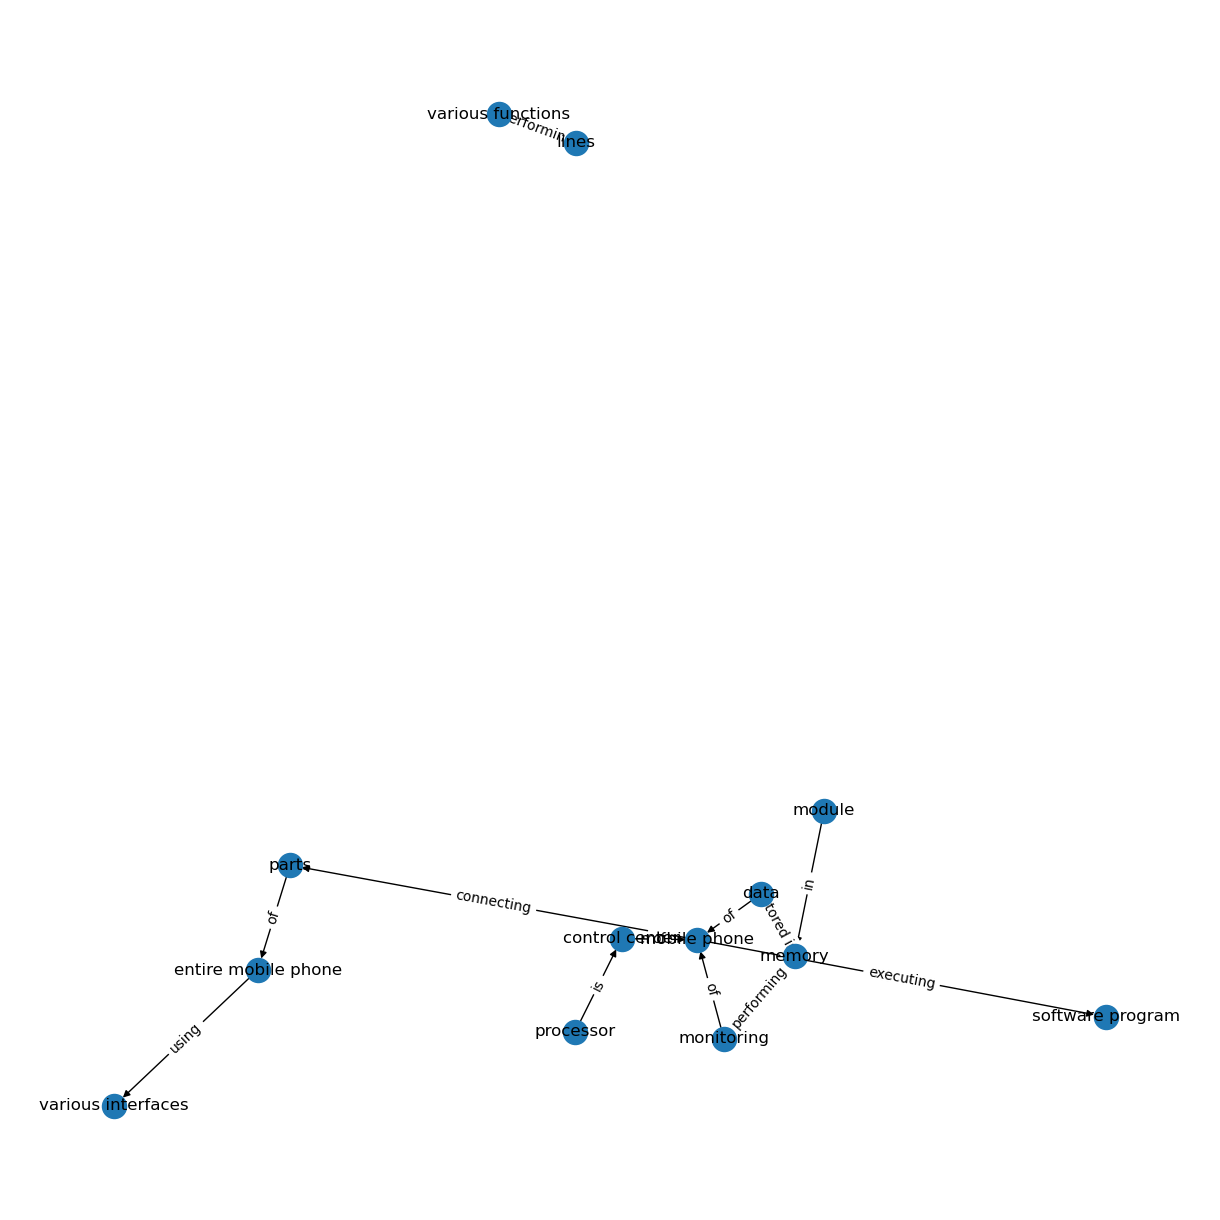

time: 474 ms (started: 2023-05-05 22:24:54 +00:00)


In [116]:
show(sources,targets,predicates)

### not that bad !

## Let's make another version of all our functions but by grouping the noun chunks together when they should !

In [117]:
def get_noun_chunks_v2(t):
    noun_chunks = [] # list of all the noun chunks (for display)
    noun_chunks_groups = [] # list of all the groups of noun chunks (for relation extraction)
    posdeps = p.posdep(t)
    for s in posdeps['sentences']:
        noun_chunks_group = []
        start = False
        mwt = ""
        chunk_start = 0
        chunk_end = 0
        for i in range(len(s['tokens'])):
            if (s['tokens'][i]['upos'] in ["ADJ","NOUN"] or (s['tokens'][i]["text"] in ["-"] and start)) and not s['tokens'][i]["text"].isnumeric(): # we also exclude numericals from being in a noun chunk
                if start:
                    mwt += s['tokens'][i]['text'] + " "
                    chunk_end = s['tokens'][i]['dspan'][1]
                else :
                    start = True
                    mwt += s['tokens'][i]['text'] + " "
                    chunk_start = s['tokens'][i]['dspan'][0]
                    chunk_end = s['tokens'][i]['dspan'][1]
            else :
                if start:
                    noun_chunks.append({'start': chunk_start,
                                        'end': chunk_end,
                                        'label': 'NC',
                                        'text': mwt[:-1]
                                        })
                    noun_chunks_group.append({'start': chunk_start, # we save it in the current group of noun chunk
                                        'end': chunk_end,
                                        'label': 'NC',
                                        'text': mwt[:-1]
                                        })
                    start = False
                    mwt = ""
                if s['tokens'][i]['deprel'] in ["root","case","cop","advcl"] or s['tokens'][i]['upos'] in ["VERB"] or s['tokens'][i]["text"] in ["where"]: # got these by diving into posdep tokens to see where we could end the groups
                    # when we need to end the group of noun chunk
                    noun_chunks_groups.append(noun_chunks_group)
                    noun_chunks_group = []
        # when we finished the sentence we append the last group
        noun_chunks_groups.append(noun_chunks_group)
    
    # clear the empty groups
    new_noun_chunks_groups = [c for c in noun_chunks_groups if c != []]
    
    return noun_chunks, new_noun_chunks_groups

time: 2.77 ms (started: 2023-05-05 22:24:56 +00:00)


In [118]:
noun_chunks, noun_chunks_groups = get_noun_chunks_v2(text)
for c in noun_chunks_groups:
    print([n["text"] for n in c])
    print("\n")

['processor']


['control center']


['mobile phone']


['parts']


['entire mobile phone']


['various interfaces', 'lines']


['various functions']


['data']


['mobile phone']


['software program', 'module']


['memory']


['data']


['memory']


['overall monitoring']


['mobile phone']


time: 1.01 s (started: 2023-05-05 22:24:56 +00:00)


In [119]:
def clean_noun_chunks_v2(noun_chunks_groups, remove_list=[], exclude_list=[]):
    new_noun_chunks = []  # list of all the new noun chunks (for display)
    new_noun_chunks_groups = [] # list of all the new groups of noun chunks (for relation extraction)
    for i in range(len(noun_chunks_groups)):
        new_noun_chunks_group = [] # new group of noun chunks
        for chunk in noun_chunks_groups[i]: # get rid of the noun_chunks
            # who have an exclude word
            exclude_list += ['that', 'which','FIG', 'FIGS','FIG.','such']
            if any(token in exclude_list for token in chunk["text"].split()):
                continue
            # who have a fully upper case word   
            if any(token.isupper() for token in chunk["text"].split()):
                continue

            filtered_tokens = [
                token for token in chunk["text"].split()
                if token not in remove_list ]

            if not filtered_tokens:
                continue

            chunk_text = ' '.join(token for token in filtered_tokens)
            # chunk_text = chunk_text.replace('"', '').replace("'", "")

            distance = 0
            for token in chunk["text"].split():
                if token in remove_list:
                    distance += len(token)+1
                else :
                    break


            start_char = chunk["start"] + distance
            end_char = start_char + len(chunk_text)

            new_noun_chunks.append({
                'start': start_char,
                'end': end_char,
                'label': chunk["label"],
                'text': chunk_text
            })
            new_noun_chunks_group.append({ # add the filtered noun chunk to it's group
                'start': start_char,
                'end': end_char,
                'label': chunk["label"],
                'text': chunk_text
            })
        
        new_noun_chunks_groups.append(new_noun_chunks_group) # append the filtered group of noun chunks
        
    # clear the empty groups
    new_noun_chunks_groups = [c for c in new_noun_chunks_groups if c != []]
    
    return new_noun_chunks, new_noun_chunks_groups

time: 2.57 ms (started: 2023-05-05 22:24:57 +00:00)


In [120]:
new_noun_chunks, new_noun_chunks_groups = clean_noun_chunks_v2(noun_chunks_groups, remove_list, exclude_list)
for c in new_noun_chunks_groups:
    print([n["text"] for n in c])
    print("\n")

['processor']


['control center']


['mobile phone']


['parts']


['entire mobile phone']


['various interfaces', 'lines']


['various functions']


['data']


['mobile phone']


['software program', 'module']


['memory']


['data']


['memory']


['monitoring']


['mobile phone']


time: 2.31 ms (started: 2023-05-05 22:24:58 +00:00)


In [121]:
def get_predicates_between_noun_chunks_v2(doc, noun_chunks_groups):
    predicates = []
    sources = []
    targets = []
    
    for i in range(len(noun_chunks_groups) - 1):
        for x in range(len(noun_chunks_groups[i]) ): # for each noun chunk in the group
            for y in range(len(noun_chunks_groups[i+1])): # for each noun chunk in the following group
                follow_up = False # boolean in case we do not find a predicate we use the last one find in our group
                start_chunk_token = doc.char_span(
                    noun_chunks_groups[i][x]['start'], noun_chunks_groups[i][x]['end'])
                end_chunk_token = doc.char_span(
                    noun_chunks_groups[i + 1][y]['start'], noun_chunks_groups[i + 1][y]['end'])
                
                if start_chunk_token is None or end_chunk_token is None or start_chunk_token.sent != end_chunk_token.sent:
                    continue

                # Find the shortest path between the root tokens of the neighboring noun chunks
                start_token = start_chunk_token.root
                end_token = end_chunk_token.root

                # not ideal, can possibly be shortened:
                predicate_tokens = []
                if start_token in end_token.ancestors:
                    ancs = end_token.ancestors
                    stop = start_token
                elif end_token in start_token.ancestors:
                    ancs = start_token.ancestors
                    stop = end_token
                else:
                    for token in end_token.ancestors:   
                        if token.text not in [w for token in noun_chunks_groups[i + 1] for w in token["text"].split()] and (not token.text.isnumeric()): # to not have a predicate which is a word in the group of noun chunks
                            predicate_tokens.append(token)
                        else : # if it was then we use the follow up rule
                            follow_up = True
                        if token in end_token.ancestors :
                            break
                    ancs = end_token.ancestors
                    stop = token
#                     print(stop,"  ",cpt)
                for tok in ancs:
                    if tok == stop :
                        break
                    if tok.text not in [w for token in noun_chunks_groups[i + 1] for w in token["text"].split()] and (not tok.text.isnumeric()):
                        predicate_tokens += [tok]


                if not predicate_tokens and not follow_up:
                    continue
                if follow_up and y != 0: # if follow up we use the last predicate found by this group
                    predicate_text = predicates[-1]["text"]
                    start_char = predicates[-1]["start"]
                    end_char = predicates[-1]["end"]
                elif follow_up and y == 0: # if there wasn't any predicate found for this group we skip it 
                    # print(start_token,"  ",end_token)
                    continue
                else:
                    predicate_tokens = sorted(
                        predicate_tokens, key=lambda token: token.i)
                    predicate_text = ' '.join(token.text for token in predicate_tokens)
                    start_char = predicate_tokens[0].idx
                    end_char = start_char + len(predicate_text)

                predicates.append({
                    'start': start_char,
                    'end': end_char,
                    'label': 'PRED',
                    'text': predicate_text
                })
                sources += [start_chunk_token]
                targets += [end_chunk_token]
                # print(
                #     f'{predicate_text} :: {start_chunk_token} _______ { end_chunk_token}')

    return predicates, sources, targets

time: 4.19 ms (started: 2023-05-05 22:24:58 +00:00)


### let's see what it gives now

In [122]:
text = "An audio circuit 960, a speaker 961, and a microphone 962 may provide an audio interface between a user and a mobile phone."
doc = nlp(text)
# displacy.render(doc, style="dep")
noun_chunks,  noun_chunks_groups = get_noun_chunks_v2(text)
new_noun_chunks, new_noun_chunks_groups = clean_noun_chunks_v2(noun_chunks_groups, remove_list, exclude_list)
predicates, sources, targets = get_predicates_between_noun_chunks_v2(doc, new_noun_chunks_groups)

# concatenate the two lists
combined_list = new_noun_chunks + predicates

# sort the combined list based on the 'start' attribute
sorted_list = sorted(combined_list, key=lambda x: x['start'])

displacy.render({'text': text, 'ents': sorted_list,
                'title': None,"settings": {}}, style='ent', manual=True, jupyter=True, options={'colors': {"PRED": funkycolor}})

time: 1.02 s (started: 2023-05-05 22:24:59 +00:00)


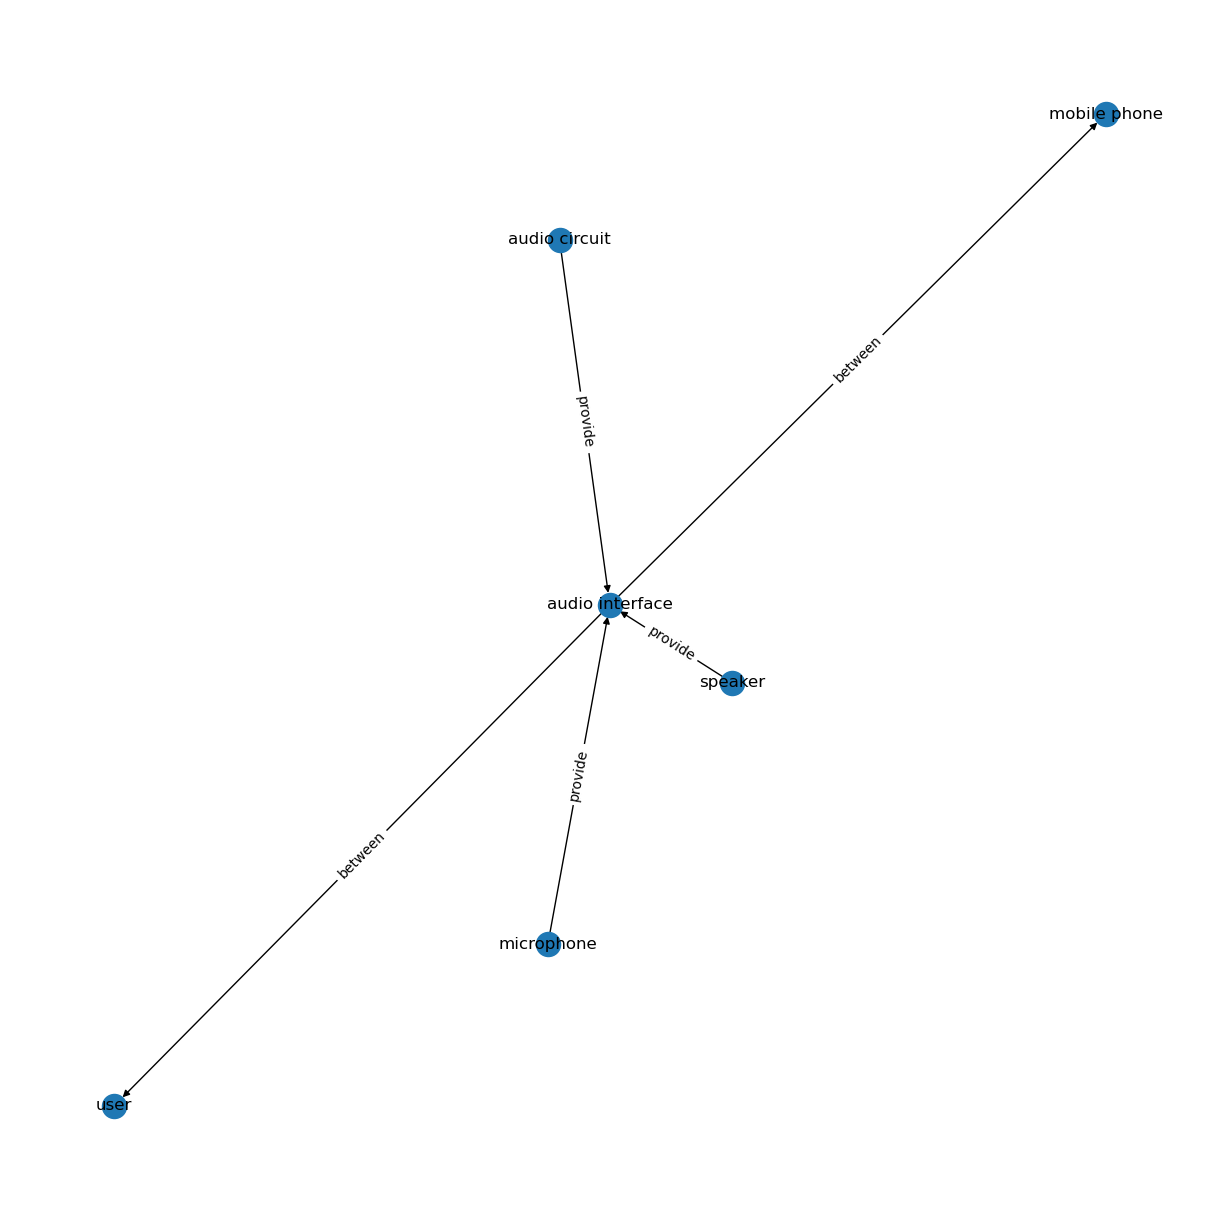

time: 281 ms (started: 2023-05-05 22:25:01 +00:00)


In [123]:
show(sources,targets,predicates)

### Perfect !

### And what about the one that was almost good ?

In [124]:
text = "The processor 980 is the control center of the mobile phone, connecting the parts of the entire mobile phone using various interfaces and lines, performing various functions and processing data of the mobile phone by running or executing a software program and/or module stored in the memory 920, and invoking data stored in the memory 920, thereby performing overall monitoring of the mobile phone."
doc = nlp(text)
# displacy.render(doc, style="dep")
noun_chunks,  noun_chunks_groups = get_noun_chunks_v2(text)
new_noun_chunks, new_noun_chunks_groups = clean_noun_chunks_v2(noun_chunks_groups, remove_list, exclude_list)
predicates, sources, targets = get_predicates_between_noun_chunks_v2(doc, new_noun_chunks_groups)

# concatenate the two lists
combined_list = new_noun_chunks + predicates

# sort the combined list based on the 'start' attribute
sorted_list = sorted(combined_list, key=lambda x: x['start'])

displacy.render({'text': text, 'ents': sorted_list,
                'title': None,"settings": {}}, style='ent', manual=True, jupyter=True, options={'colors': {"PRED": funkycolor}})

time: 1.3 s (started: 2023-05-05 22:25:02 +00:00)


In [125]:
for c in new_noun_chunks_groups:
    print([n["text"] for n in c])
    print("\n")

['processor']


['control center']


['mobile phone']


['parts']


['entire mobile phone']


['various interfaces', 'lines']


['various functions']


['data']


['mobile phone']


['software program', 'module']


['memory']


['data']


['memory']


['monitoring']


['mobile phone']


time: 1.13 ms (started: 2023-05-05 22:25:04 +00:00)


In [126]:
for pr,s,t in zip(predicates,sources,targets):
    print(s," | ",pr["text"]," | ",t)

processor  |  is  |  control center
control center  |  of  |  mobile phone
mobile phone  |  connecting  |  parts
parts  |  of  |  entire mobile phone
entire mobile phone  |  using  |  various interfaces
entire mobile phone  |  using  |  lines
various interfaces  |  performing  |  various functions
lines  |  performing  |  various functions
data  |  of  |  mobile phone
mobile phone  |  executing  |  software program
mobile phone  |  executing  |  module
software program  |  in  |  memory
module  |  in  |  memory
memory  |  invoking  |  data
data  |  stored in  |  memory
memory  |  performing  |  monitoring
monitoring  |  of  |  mobile phone
time: 1.76 ms (started: 2023-05-05 22:25:05 +00:00)


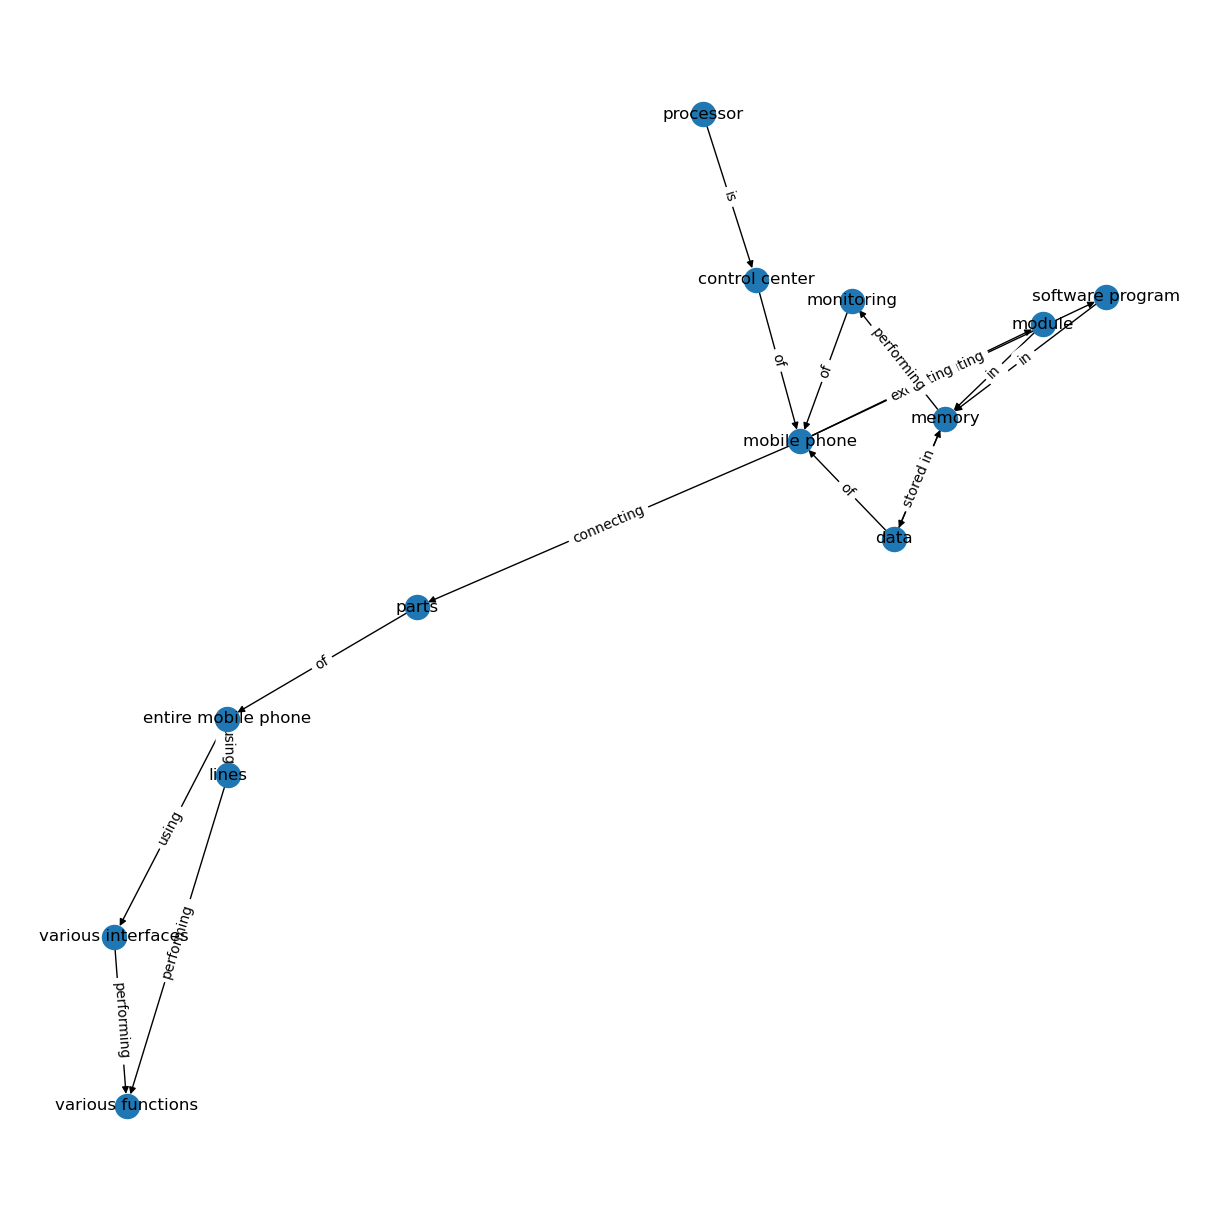

time: 434 ms (started: 2023-05-05 22:25:05 +00:00)


In [127]:
show(sources,targets,predicates)

### Looks perfect too !! Now time for the real challenge with the whole paragraph

In [128]:
text = "An audio circuit 960, a speaker 961, and a microphone 962 may provide an audio interface between a user and a mobile phone. The audio circuit 960 may transmit the received audio data converted electrical signal to the speaker 961, and convert the audio signal from the speaker 961 to a sound signal for playback. On the other hand, the microphone 962 converts the collected sound signal into an electrical signal, receives it by the audio circuit 960, converts it into audio data, processes it by the audio data playback processor 980, transmits it to another mobile phone, for example, via the RF circuit 910, or plays the audio data to the memory 920 for further processing. \
WiFi belongs to a short-range wireless transmission technology, and the mobile phone can help the user receive and send e-mail, browse web pages, access streaming media, and the like through the WiFi module 970, which provides the user with wireless broadband Internet access. Although FIG. 7 shows the WiFi module 970, it is understood that it does not belong to the mandatory structure of the mobile phone and may be omitted as necessary without changing the essence of the disclosure. \
The processor 980 is the control center of the mobile phone, connecting the parts of the entire mobile phone using various interfaces and lines, performing various functions and processing data of the mobile phone by running or executing a software program and/or module stored in the memory 920, and invoking data stored in the memory 920, thereby performing overall monitoring of the mobile phone. Optionally, processor 980 may include one or more processing units. Preferably, the processor 980 may integrate an application processor and a modem processor, where the application processor mainly processes an operating system, a user interface, an application program, and the like, and the modem processor mainly processes wireless communications. It is understood that the above-described modem processor may also not be integrated into the processor 980."
doc = nlp(text)
# displacy.render(doc, style="dep")
noun_chunks,  noun_chunks_groups = get_noun_chunks_v2(text)
exclude_list += ["other"]
new_noun_chunks, new_noun_chunks_groups = clean_noun_chunks_v2(noun_chunks_groups, remove_list, exclude_list)
predicates, sources, targets = get_predicates_between_noun_chunks_v2(doc, new_noun_chunks_groups)

# concatenate the two lists
combined_list = new_noun_chunks + predicates

# sort the combined list based on the 'start' attribute
sorted_list = sorted(combined_list, key=lambda x: x['start'])

displacy.render({'text': text, 'ents': sorted_list,
                'title': None,"settings": {}}, style='ent', manual=True, jupyter=True, options={'colors': {"PRED": funkycolor}})

time: 2.88 s (started: 2023-05-05 22:25:06 +00:00)


In [129]:
for c in new_noun_chunks_groups:
    print([n["text"] for n in c])
    print("\n")

['audio circuit', 'speaker', 'microphone']


['audio interface']


['user', 'mobile phone']


['audio circuit']


['audio data']


['electrical signal']


['speaker']


['audio signal']


['speaker']


['sound signal']


['playback']


['microphone']


['sound signal']


['electrical signal']


['audio circuit']


['audio data']


['audio data playback processor']


['mobile phone']


['example']


['audio data']


['memory']


['processing']


['WiFi']


['short - range wireless transmission technology', 'mobile phone']


['user']


['e-mail']


['web pages']


['media']


['WiFi module']


['user']


['wireless broadband Internet access']


['WiFi module']


['mandatory structure']


['mobile phone']


['essence']


['disclosure']


['processor']


['control center']


['mobile phone']


['parts']


['entire mobile phone']


['various interfaces', 'lines']


['various functions']


['data']


['mobile phone']


['software program', 'module']


['memory']


['data']


['memory']


['m

In [130]:
for pr,s,t in zip(predicates,sources,targets):
    print(s," | ",pr["text"]," | ",t)

audio circuit  |  provide  |  audio interface
speaker  |  provide  |  audio interface
microphone  |  provide  |  audio interface
audio interface  |  between  |  user
audio interface  |  between  |  mobile phone
audio circuit  |  converted  |  audio data
audio data  |  converted  |  electrical signal
electrical signal  |  to  |  speaker
speaker  |  convert  |  audio signal
audio signal  |  from  |  speaker
speaker  |  to  |  sound signal
sound signal  |  for  |  playback
microphone  |  converts  |  sound signal
sound signal  |  into  |  electrical signal
electrical signal  |  by  |  audio circuit
audio circuit  |  into  |  audio data
audio data  |  by  |  audio data playback processor
audio data playback processor  |  to  |  mobile phone
mobile phone  |  for  |  example
example  |  plays  |  audio data
audio data  |  to  |  memory
memory  |  for  |  processing
WiFi  |  help  |  mobile phone
mobile phone  |  receive  |  user
user  |  send  |  e-mail
web pages  |  access  |  media
media  

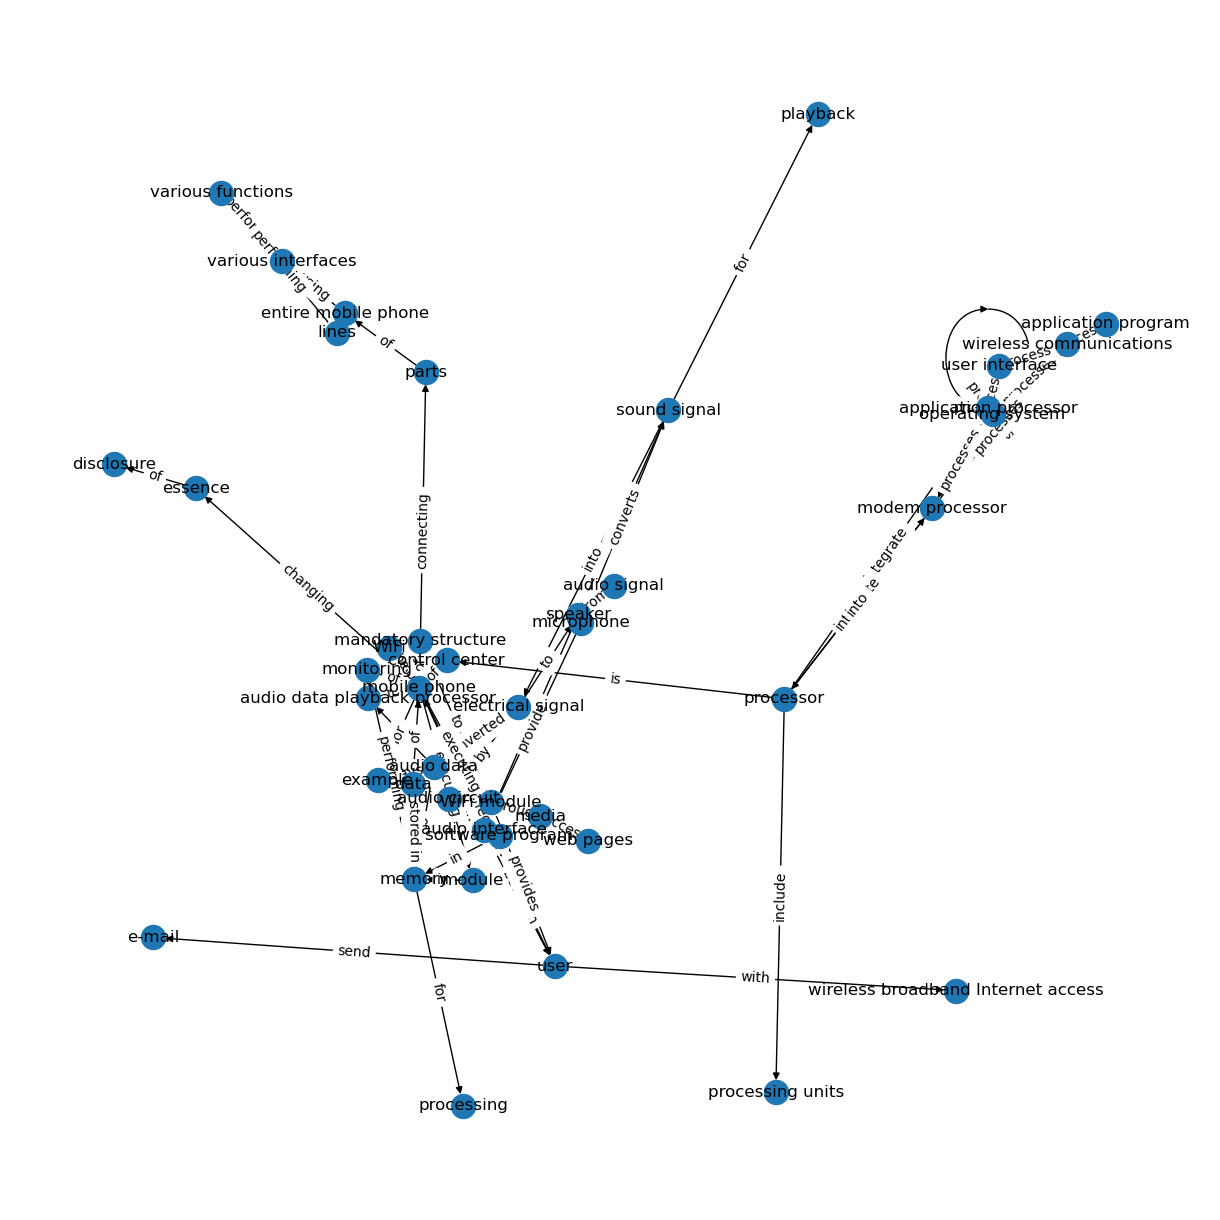

time: 1.26 s (started: 2023-05-05 22:25:11 +00:00)


In [131]:
show(sources,targets,predicates)

### a bit hard to see everything but looks very good too !!

### We might want to have a better look at who are the technical terms for the noun chunks

### creating a set of all the referenced term we found

In [132]:
ours_term = { w for n in range(len(R)) for a,b in R[n][1] for w in a.lower().split('_')[:-1]}

time: 13.5 ms (started: 2023-05-05 22:25:14 +00:00)


In [133]:
print("essence" in ours_term)

False
time: 693 µs (started: 2023-05-05 22:25:14 +00:00)


### Doing another version where we separete technical from general noun chunks

In [134]:
def get_noun_chunks_v3(t,technical_set):
    noun_chunks = []
    noun_chunks_groups = []
    posdeps = p.posdep(t)
    for s in posdeps['sentences']:
        noun_chunks_group = []
        start = False
        mwt = ""
        chunk_start = 0
        chunk_end = 0
        for i in range(len(s['tokens'])):
            if (s['tokens'][i]['upos'] in ["ADJ","NOUN"] or (s['tokens'][i]["text"] in ["-"] and start)) and not s['tokens'][i]["text"].isnumeric():
                if start:
                    mwt += s['tokens'][i]['text'] + " "
                    chunk_end = s['tokens'][i]['dspan'][1]
                else :
                    start = True
                    mwt += s['tokens'][i]['text'] + " "
                    chunk_start = s['tokens'][i]['dspan'][0]
                    chunk_end = s['tokens'][i]['dspan'][1]
            else :
                if start:
                    if any(w.lower() in technical_set for w in mwt[:-1].split()): # if any word in the noun chunk is a technical term then the whole noun chunk is a technical term
                        label = "TT" # technical term
                    else :
                        label = "NC" # noun chunk (general)
                    noun_chunks.append({'start': chunk_start,
                                        'end': chunk_end,
                                        'label': label,
                                        'text': mwt[:-1]
                                        })
                    noun_chunks_group.append({'start': chunk_start,
                                        'end': chunk_end,
                                        'label': label,
                                        'text': mwt[:-1]
                                        })
                    start = False
                    mwt = ""
                if s['tokens'][i]['deprel'] in ["root","case","cop","advcl"] or s['tokens'][i]['upos'] in ["VERB"] or s['tokens'][i]["text"] in ["where"]:
                    noun_chunks_groups.append(noun_chunks_group)
                    noun_chunks_group = []
        noun_chunks_groups.append(noun_chunks_group)
    
    # clear the empty groups
    new_noun_chunks_groups = [c for c in noun_chunks_groups if c != []]
    
    return noun_chunks, new_noun_chunks_groups

time: 3.08 ms (started: 2023-05-05 22:25:15 +00:00)


In [135]:
text = "An audio circuit 960, a speaker 961, and a microphone 962 may provide an audio interface between a user and a mobile phone. The audio circuit 960 may transmit the received audio data converted electrical signal to the speaker 961, and convert the audio signal from the speaker 961 to a sound signal for playback. On the other hand, the microphone 962 converts the collected sound signal into an electrical signal, receives it by the audio circuit 960, converts it into audio data, processes it by the audio data playback processor 980, transmits it to another mobile phone, for example, via the RF circuit 910, or plays the audio data to the memory 920 for further processing. \
WiFi belongs to a short-range wireless transmission technology, and the mobile phone can help the user receive and send e-mail, browse web pages, access streaming media, and the like through the WiFi module 970, which provides the user with wireless broadband Internet access. Although FIG. 7 shows the WiFi module 970, it is understood that it does not belong to the mandatory structure of the mobile phone and may be omitted as necessary without changing the essence of the disclosure. \
The processor 980 is the control center of the mobile phone, connecting the parts of the entire mobile phone using various interfaces and lines, performing various functions and processing data of the mobile phone by running or executing a software program and/or module stored in the memory 920, and invoking data stored in the memory 920, thereby performing overall monitoring of the mobile phone. Optionally, processor 980 may include one or more processing units. Preferably, the processor 980 may integrate an application processor and a modem processor, where the application processor mainly processes an operating system, a user interface, an application program, and the like, and the modem processor mainly processes wireless communications. It is understood that the above-described modem processor may also not be integrated into the processor 980."
doc = nlp(text)
# displacy.render(doc, style="dep")
noun_chunks,  noun_chunks_groups = get_noun_chunks_v3(text,ours_term)
exclude_list += ["other"]
new_noun_chunks, new_noun_chunks_groups = clean_noun_chunks_v2(noun_chunks_groups, remove_list, exclude_list)
predicates, sources, targets = get_predicates_between_noun_chunks_v2(doc, new_noun_chunks_groups)

# concatenate the two lists
combined_list = new_noun_chunks + predicates

# sort the combined list based on the 'start' attribute
sorted_list = sorted(combined_list, key=lambda x: x['start'])

displacy.render({'text': text, 'ents': sorted_list,
                'title': None,"settings": {}}, style='ent', manual=True, jupyter=True, options={'colors': {"PRED": funkycolor,"TT":"#85C1E9"}})

time: 2.9 s (started: 2023-05-05 22:25:16 +00:00)


### Looks beautiful isn't it ?

### Let's also adapt the graph

### used this : https://stackoverflow.com/questions/60919360/make-networkx-plot-look-nice

In [136]:
def show_v3(sources,targets,predicates,technical_set):
    df = pd.DataFrame({'source': [str(s) for s in sources], 
                        'target': [str(t) for t in targets], 
                        'edge': [r['text'] for r in predicates]})

    G = nx.from_pandas_edgelist(df, "source", "target",
                                edge_attr=True, create_using=nx.MultiDiGraph())
    plt.figure(figsize=(15, 15))
    
    colors = [['lightgrey', 'lightblue'][any(w in technical_set for w in node.split())] for node in G.nodes()]  
    d = dict(G.degree)
    pos = nx.spring_layout(G, scale=20, k=3/np.sqrt(G.order()))
    nx.draw(G, with_labels=True, pos=pos,edge_color='purple',node_color=colors,node_size=[d[k]*300 for k in d])
    
    # Add edge labels
    edge_labels = {(row['source'], row['target']): row['edge']
                   for _, row in df.iterrows()}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

    plt.show()

time: 2.34 ms (started: 2023-05-05 22:25:20 +00:00)


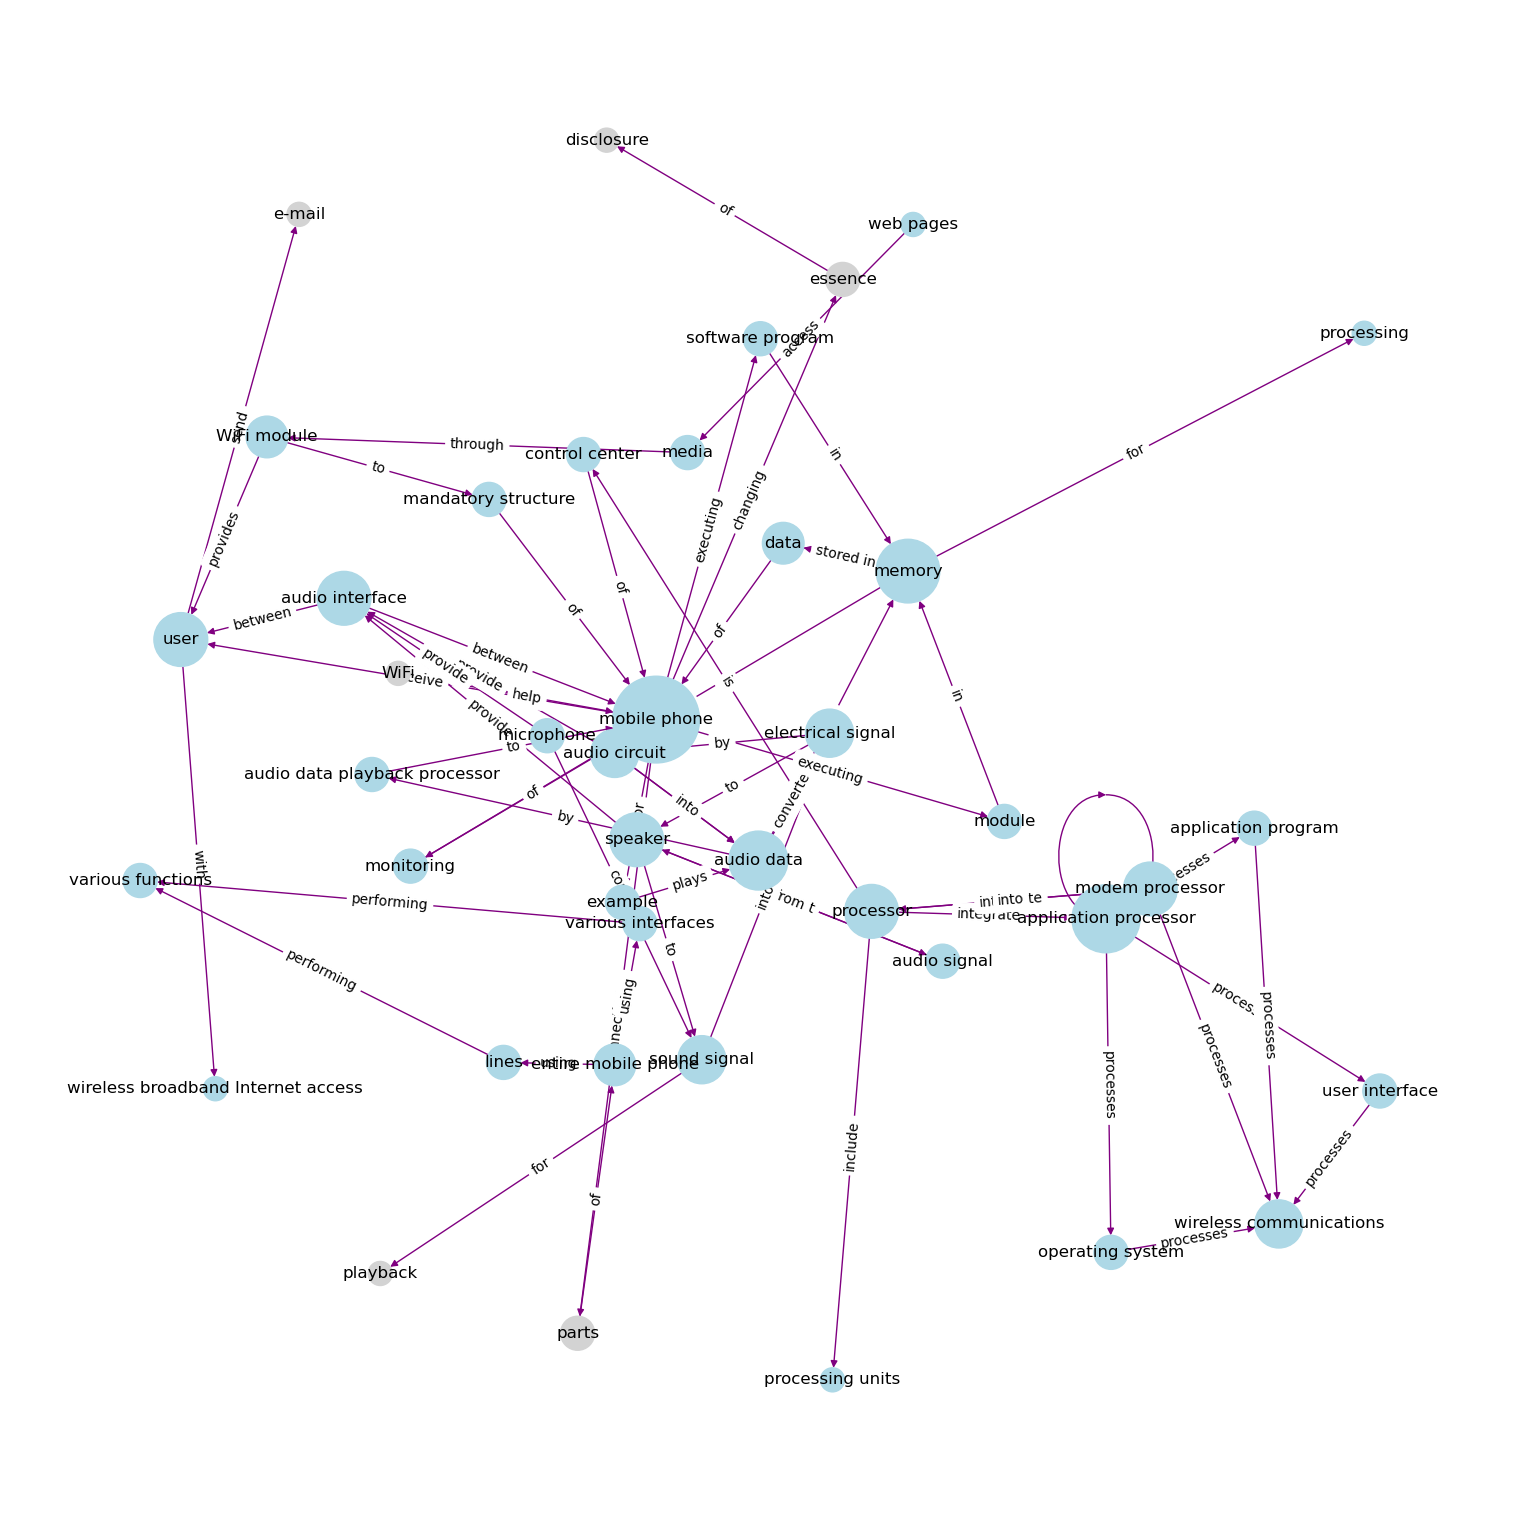

time: 1.25 s (started: 2023-05-05 22:25:21 +00:00)


In [137]:
show_v3(sources,targets,predicates,ours_term)

### What does it give for the first patent text ?

In [138]:
text = patent_texts[0]
doc = nlp(text)
nb_sentences = len(list(doc.sents))
noun_chunks,  noun_chunks_groups = get_noun_chunks_v3(text,ours_term)
new_noun_chunks, new_noun_chunks_groups = clean_noun_chunks_v2(noun_chunks_groups, remove_list, exclude_list)
predicates, sources, targets = get_predicates_between_noun_chunks_v2(doc, new_noun_chunks_groups)

time: 3min 15s (started: 2023-05-05 22:25:23 +00:00)


### seems like we still have some cases to solve (when activating the print for follow_up issues in get_predicates_between_noun_chunks_v2 function

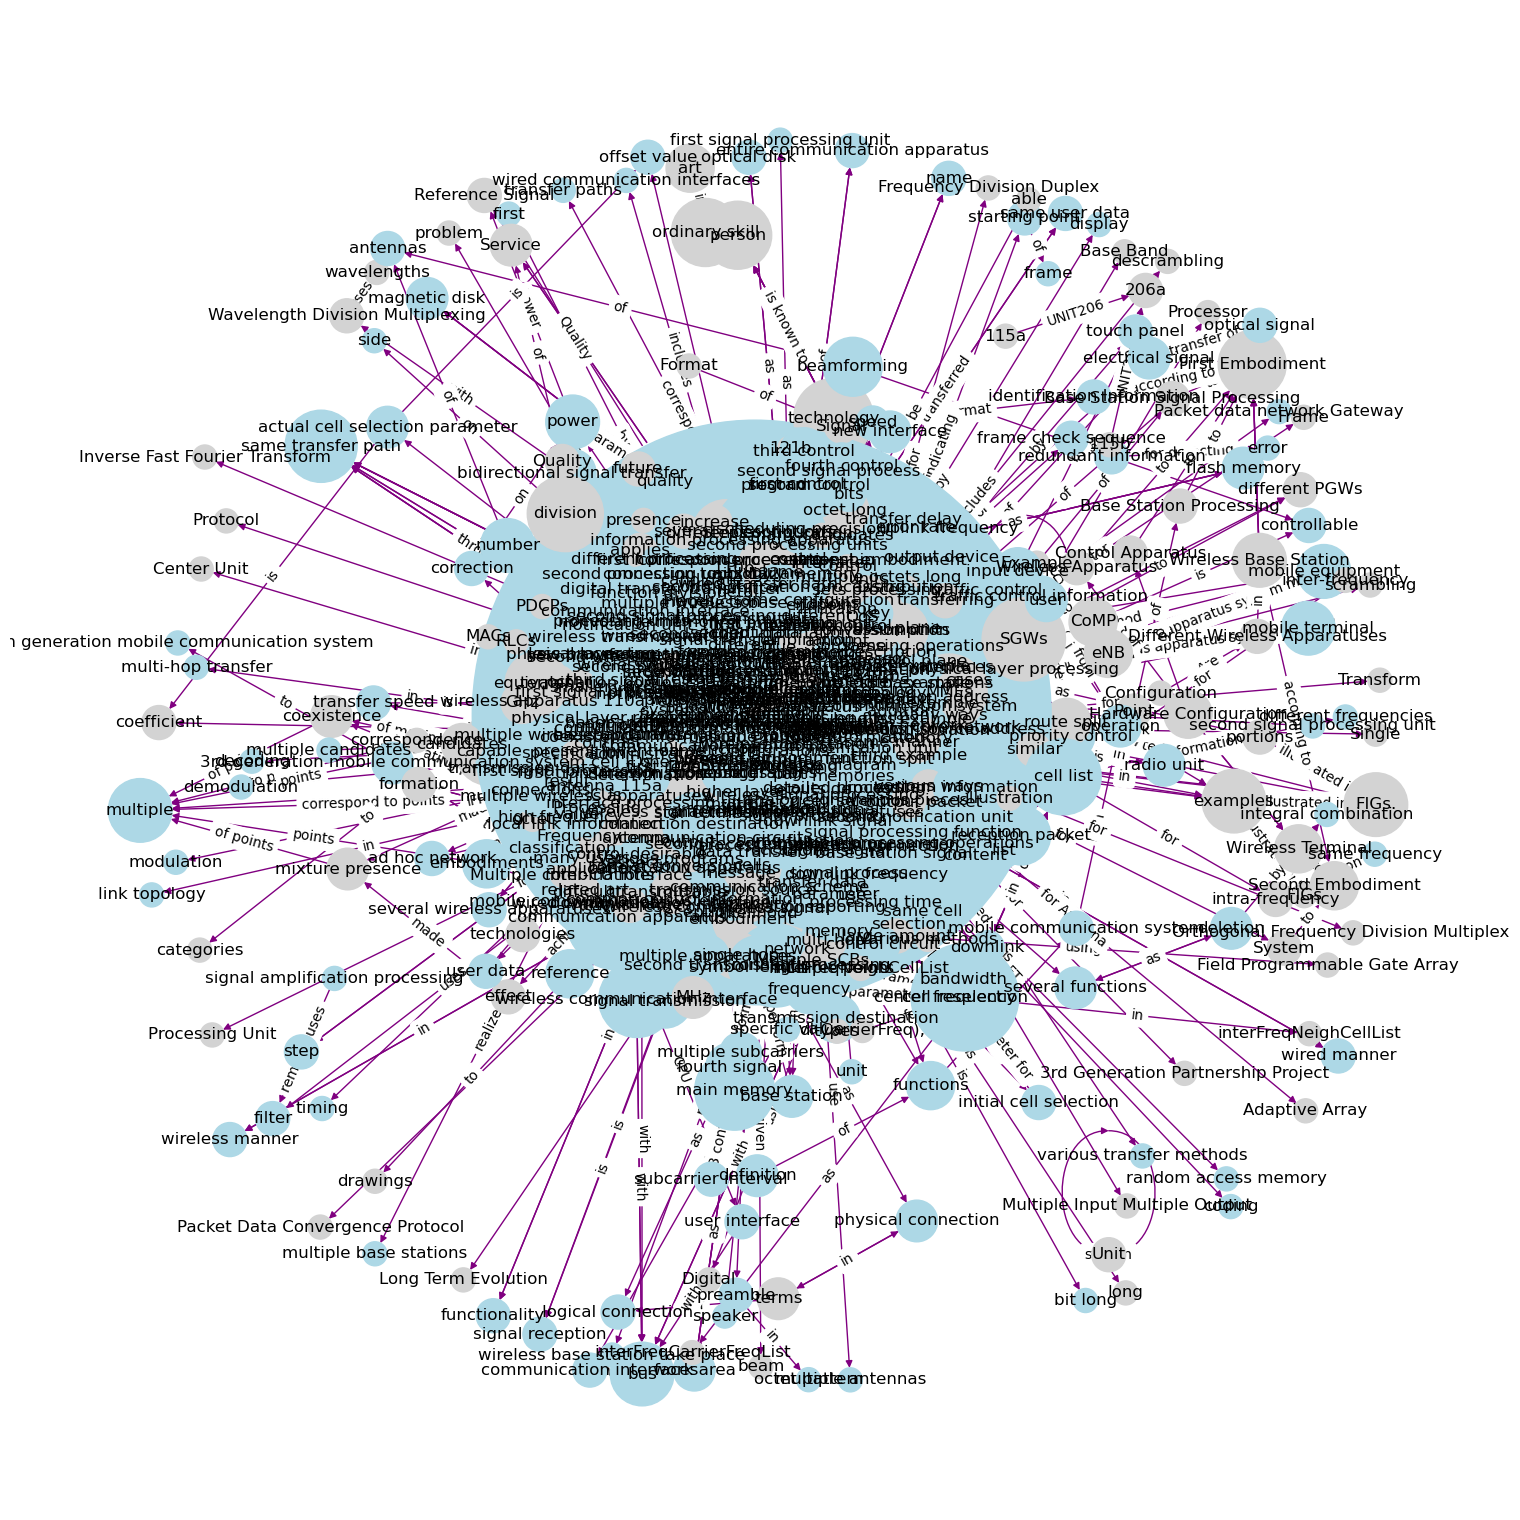

time: 37.9 s (started: 2023-05-05 22:28:39 +00:00)


In [139]:
show_v3(sources,targets,predicates,ours_term)

### when looking at the outside of the graph we can see a lot of improvment can still be made (excluding FIGs. , Packet Data Convergence Protocol not being a technical term while Bus is, etc...)

In [140]:
len(predicates)

4182

time: 2.58 ms (started: 2023-05-05 22:29:19 +00:00)


### +4K binary relations in the patent text

In [141]:
len(predicates)/len(list(doc.sents))

3.602067183462532

time: 4.9 ms (started: 2023-05-05 22:29:20 +00:00)


~4 binary relations per sentences

### But let's see the stat after running it for all the patent texts !!

In [142]:
len(patent_texts)

2001

time: 2.98 ms (started: 2023-05-05 22:29:21 +00:00)


### 4 minutes per patents would give ~67 hours of running time so let's take a sample of 100 patent texts

In [143]:
def run_stat(patent_texts):
    nb_patents = len(patent_texts)
    nb_sentences = 0
    nb_predicates = 0
    predicates_total = []
    sources_total = []
    targets_total = []
    for text in patent_texts:
        doc = nlp(text)
        nb_sentences += len(list(doc.sents))
        noun_chunks,  noun_chunks_groups = get_noun_chunks_v3(text,ours_term)
        new_noun_chunks, new_noun_chunks_groups = clean_noun_chunks_v2(noun_chunks_groups, remove_list, exclude_list)
        predicates, sources, targets = get_predicates_between_noun_chunks_v2(doc, new_noun_chunks_groups)
        nb_predicates += len(predicates)
        predicates_total += predicates
        sources_total += sources
        targets_total += targets
    return nb_predicates,nb_patents,nb_sentences,predicates_total,sources_total,targets_total

time: 1.27 ms (started: 2023-05-05 22:29:23 +00:00)


In [144]:
# nb_predicates,nb_patents,nb_sentences,predicates_total,sources_total,targets_total = run_stat(patent_texts[:100])

time: 353 µs (started: 2023-05-05 22:29:23 +00:00)


In [145]:
# print("global (100 patents):",nb_predicates)
# print("per patent :",nb_predicates/nb_patents)
# print("per sentence :",nb_predicates/nb_sentences)

time: 402 µs (started: 2023-05-05 22:29:24 +00:00)


In [146]:
# show_v3(sources_total,targets_total,predicates_total,ours_term)

time: 362 µs (started: 2023-05-05 22:29:24 +00:00)


### Plotting a graph for all these patents is useless but at least it seems to plot something so that nothing has gone wrong

## Time to make the negation enter in the predicates !

In [147]:
text = "the mobile phone and may be omitted as necessary without changing the essence of the disclosure."
doc = nlp(text)
# displacy.render(doc, style="dep")
noun_chunks,  noun_chunks_groups = get_noun_chunks_v3(text,ours_term)
exclude_list += ["other"]
new_noun_chunks, new_noun_chunks_groups = clean_noun_chunks_v2(noun_chunks_groups, remove_list, exclude_list)
predicates, sources, targets = get_predicates_between_noun_chunks_v2(doc, new_noun_chunks_groups)

# concatenate the two lists
combined_list = new_noun_chunks + predicates

# sort the combined list based on the 'start' attribute
sorted_list = sorted(combined_list, key=lambda x: x['start'])

displacy.render({'text': text, 'ents': sorted_list,
                'title': None,"settings": {}}, style='ent', manual=True, jupyter=True, options={'colors': {"PRED": funkycolor,"TT":"#85C1E9"}})

time: 1.02 s (started: 2023-05-05 22:29:26 +00:00)


### Since there is no "NEG" in trankit we decide to hard code a list of the negations terms

In [148]:
negation_terms_linked = ["not"] # "does not" for example
negation_terms = ["without","not"]

time: 624 µs (started: 2023-05-05 22:29:28 +00:00)


In [149]:
def get_predicates_between_noun_chunks_v3(doc, noun_chunks_groups):
    predicates = []
    sources = []
    targets = []
    
    for i in range(len(noun_chunks_groups) - 1):
        for x in range(len(noun_chunks_groups[i]) ):
            for y in range(len(noun_chunks_groups[i+1])):
                follow_up = False
                start_chunk_token = doc.char_span(
                    noun_chunks_groups[i][x]['start'], noun_chunks_groups[i][x]['end'])
                end_chunk_token = doc.char_span(
                    noun_chunks_groups[i + 1][y]['start'], noun_chunks_groups[i + 1][y]['end'])
                
                if start_chunk_token is None or end_chunk_token is None or start_chunk_token.sent != end_chunk_token.sent:
                    continue

                # Find the shortest path between the root tokens of the neighboring noun chunks
                start_token = start_chunk_token.root
                end_token = end_chunk_token.root

                # not ideal, can possibly be shortened:
                predicate_tokens = []
                third_case = False
                if start_token in end_token.ancestors:
                    ancs = end_token.ancestors
                    stop = start_token
                elif end_token in start_token.ancestors:
                    ancs = start_token.ancestors
                    stop = end_token
                else:
                    cpt = 0 # use a counter to not stop at the first token from ancestors
                    need_next_tok = False # if we have a negation term that need it's predecessor
                    for token in end_token.ancestors:    
                        if token.text in negation_terms_linked: # if we have a negation term that need it's predecessor
                            need_next_tok = True
                        if cpt > 0 and token.text not in negation_terms and not need_next_tok : # if we don't have a negation and it's not the first token from the ancestors, we stop
                            break
                        if token.text not in [w for token in noun_chunks_groups[i + 1] for w in token["text"].split()] and (not token.text.isnumeric()):
                            predicate_tokens.append(token)
                        else :
                            follow_up = True
                        cpt += 1
                        if need_next_tok and token.text not in negation_terms_linked: # if we got the needed token for the negation linked we stop
                            break
#                         if token in end_token.ancestors :
#                             break
                    ancs = end_token.ancestors
                    stop = token
#                     print(stop,"  ",cpt)
                    third_case = True # to not iterate the next for loop because we already have the whole predicate
                for tok in ancs:
                    if third_case:
                        break
                    if tok == stop :
                        break
                    if tok.text not in [w for token in noun_chunks_groups[i + 1] for w in token["text"].split()] and (not tok.text.isnumeric()):
                        predicate_tokens += [tok]


                if not predicate_tokens and not follow_up:
                    continue
                if follow_up and y != 0:
                    predicate_text = predicates[-1]["text"]
                    start_char = predicates[-1]["start"]
                    end_char = predicates[-1]["end"]
                elif follow_up and y == 0:
                    # print(start_token,"  ",end_token)
                    continue
                else:
                    predicate_tokens = sorted(
                        predicate_tokens, key=lambda token: token.i)
                    predicate_text = ' '.join(token.text for token in predicate_tokens)
                    start_char = predicate_tokens[0].idx
                    end_char = start_char + len(predicate_text)

                predicates.append({
                    'start': start_char,
                    'end': end_char,
                    'label': 'PRED',
                    'text': predicate_text
                })
                sources += [start_chunk_token]
                targets += [end_chunk_token]
                # print(
                #     f'{predicate_text} :: {start_chunk_token} _______ { end_chunk_token}')

    return predicates, sources, targets

time: 4.35 ms (started: 2023-05-05 22:29:29 +00:00)


In [150]:
text = "the mobile phone and may be omitted as necessary without changing the essence of the disclosure."
doc = nlp(text)
# displacy.render(doc, style="dep")
noun_chunks,  noun_chunks_groups = get_noun_chunks_v3(text,ours_term)
exclude_list += ["other"]
new_noun_chunks, new_noun_chunks_groups = clean_noun_chunks_v2(noun_chunks_groups, remove_list, exclude_list)
predicates, sources, targets = get_predicates_between_noun_chunks_v3(doc, new_noun_chunks_groups)

# concatenate the two lists
combined_list = new_noun_chunks + predicates

# sort the combined list based on the 'start' attribute
sorted_list = sorted(combined_list, key=lambda x: x['start'])

displacy.render({'text': text, 'ents': sorted_list,
                'title': None,"settings": {}}, style='ent', manual=True, jupyter=True, options={'colors': {"PRED": funkycolor,"TT":"#85C1E9"}})

time: 989 ms (started: 2023-05-05 22:29:29 +00:00)


In [151]:
for pr,s,t in zip(predicates,sources,targets):
    print(s," | ",pr["text"]," | ",t)

mobile phone  |  without changing  |  essence
essence  |  of  |  disclosure
time: 1.39 ms (started: 2023-05-05 22:29:31 +00:00)


In [152]:
# displacy.render(doc, style="dep") # do not work with the old version of spacy we use (for neuralcoref)

time: 499 µs (started: 2023-05-05 22:29:31 +00:00)


### It's working because as the ancestors of essence we have : [omitted,without,changing]

In [153]:
text = "the mobile phone does not belong to the essence of the disclosure."
doc = nlp(text)
# displacy.render(doc, style="dep")
noun_chunks,  noun_chunks_groups = get_noun_chunks_v3(text,ours_term)
exclude_list += ["other"]
new_noun_chunks, new_noun_chunks_groups = clean_noun_chunks_v2(noun_chunks_groups, remove_list, exclude_list)
predicates, sources, targets = get_predicates_between_noun_chunks_v3(doc, new_noun_chunks_groups)

# concatenate the two lists
combined_list = new_noun_chunks + predicates

# sort the combined list based on the 'start' attribute
sorted_list = sorted(combined_list, key=lambda x: x['start'])

displacy.render({'text': text, 'ents': sorted_list,
                'title': None,"settings": {}}, style='ent', manual=True, jupyter=True, options={'colors': {"PRED": funkycolor,"TT":"#85C1E9"}})

time: 981 ms (started: 2023-05-05 22:29:32 +00:00)


In [154]:
for pr,s,t in zip(predicates,sources,targets):
    print(s," | ",pr["text"]," | ",t)

mobile phone  |  to  |  essence
essence  |  of  |  disclosure
time: 1.03 ms (started: 2023-05-05 22:29:34 +00:00)


In [155]:
# displacy.render(doc, style="dep") # do not work with the old version of spacy we use (for neuralcoref)

time: 532 µs (started: 2023-05-05 22:29:34 +00:00)


### It's not working because as ancestors of essence we have : [belong,to] , the [does,not] isn't accessible via the ancestors

### So we do not have any means available to acces this negation with trankit :(

## Then let's dive into coreference resolution !

In [156]:
text = " On the other hand, the microphone 962 converts the collected sound signal into an electrical signal, receives it by the audio circuit 960, converts it into audio data, processes it by the audio data playback processor 980, transmits it to another mobile phone, for example, via the RF circuit 910, or plays the audio data to the memory 920 for further processing."
doc = nlp(text)
# displacy.render(doc, style="dep")
noun_chunks,  noun_chunks_groups = get_noun_chunks_v3(text,ours_term)
exclude_list += ["other"]
new_noun_chunks, new_noun_chunks_groups = clean_noun_chunks_v2(noun_chunks_groups, remove_list, exclude_list)
predicates, sources, targets = get_predicates_between_noun_chunks_v3(doc, new_noun_chunks_groups)

# concatenate the two lists
combined_list = new_noun_chunks + predicates

# sort the combined list based on the 'start' attribute
sorted_list = sorted(combined_list, key=lambda x: x['start'])

displacy.render({'text': text, 'ents': sorted_list,
                'title': None,"settings": {}}, style='ent', manual=True, jupyter=True, options={'colors': {"PRED": funkycolor,"TT":"#85C1E9"}})

time: 1.11 s (started: 2023-05-05 22:29:37 +00:00)


In [157]:
for pr,s,t in zip(predicates,sources,targets):
    print(s," | ",pr["text"]," | ",t)

microphone  |  converts  |  sound signal
sound signal  |  into  |  electrical signal
electrical signal  |  by  |  audio circuit
audio circuit  |  into  |  audio data
audio data  |  by  |  audio data playback processor
audio data playback processor  |  to  |  mobile phone
mobile phone  |  for  |  example
example  |  plays  |  audio data
audio data  |  to  |  memory
memory  |  for  |  processing
time: 1.6 ms (started: 2023-05-05 22:29:38 +00:00)


### Not good at all ! we have to find a way to treat the ", verb it" cases

### Let's try neuralcoref !!

used this notebook to understand how to use it on kaggle : https://www.kaggle.com/code/mamamot/resolving-coreference-with-neuralcoref

In [158]:
import en_coref_md

nlp_coref = en_coref_md.load()

time: 23.5 s (started: 2023-05-05 22:29:41 +00:00)


In [159]:
# You're done. You can now use NeuralCoref the same way you usually manipulate a SpaCy document and it's annotations.
doc_coref = nlp_coref(u' On the other hand, the microphone 962 converts the collected sound signal into an electrical signal, receives it by the audio circuit 960, converts it into audio data, processes it by the audio data playback processor 980, transmits it to another mobile phone, for example, via the RF circuit 910, or plays the audio data to the memory 920 for further processing.')

doc_coref._.has_coref
doc_coref._.coref_clusters

[an electrical signal: [an electrical signal, it, it, it, it]]

time: 72.4 ms (started: 2023-05-05 22:30:05 +00:00)


In [160]:
doc_coref._.coref_resolved

' On the other hand, the microphone 962 converts the collected sound signal into an electrical signal, receives an electrical signal by the audio circuit 960, converts an electrical signal into audio data, processes an electrical signal by the audio data playback processor 980, transmits an electrical signal to another mobile phone, for example, via the RF circuit 910, or plays the audio data to the memory 920 for further processing.'

time: 3.78 ms (started: 2023-05-05 22:30:05 +00:00)


### seems good ! even though "it" might not be referring to "an electrical signal"

In [161]:
text_coref = doc_coref._.coref_resolved
doc = nlp(text_coref)
# displacy.render(doc, style="dep")
noun_chunks,  noun_chunks_groups = get_noun_chunks_v3(text_coref,ours_term)
exclude_list += ["other"]
new_noun_chunks, new_noun_chunks_groups = clean_noun_chunks_v2(noun_chunks_groups, remove_list, exclude_list)
predicates, sources, targets = get_predicates_between_noun_chunks_v3(doc, new_noun_chunks_groups)

# concatenate the two lists
combined_list = new_noun_chunks + predicates

# sort the combined list based on the 'start' attribute
sorted_list = sorted(combined_list, key=lambda x: x['start'])

displacy.render({'text': text_coref, 'ents': sorted_list,
                'title': None, "settings": {}}, style='ent', manual=True, jupyter=True, options={'colors': {"PRED": funkycolor,"TT":"#85C1E9"}})

time: 1.25 s (started: 2023-05-05 22:30:06 +00:00)


In [162]:
for pr,s,t in zip(predicates,sources,targets):
    print(s," | ",pr["text"]," | ",t)

microphone  |  converts  |  sound signal
sound signal  |  into  |  electrical signal
electrical signal  |  receives  |  electrical signal
electrical signal  |  by  |  audio circuit
audio circuit  |  converts  |  electrical signal
electrical signal  |  into  |  audio data
audio data  |  processes  |  electrical signal
electrical signal  |  by  |  audio data playback processor
audio data playback processor  |  transmits  |  electrical signal
electrical signal  |  to  |  mobile phone
mobile phone  |  for  |  example
example  |  via  |  circuit
circuit  |  plays  |  audio data
audio data  |  to  |  memory
memory  |  for  |  processing
time: 2.19 ms (started: 2023-05-05 22:30:08 +00:00)


### but now the issue is that they should refer to microphone and not the noun chunk before the ","

### so let's see what are the noun chunks we get when we do not delete the empty ones, maybe we could work our way around

In [163]:
def get_noun_chunks_v4(t,technical_set):
    noun_chunks = []
    noun_chunks_groups = []
    posdeps = p.posdep(t)
    for s in posdeps['sentences']:
        noun_chunks_group = []
        start = False
        mwt = ""
        chunk_start = 0
        chunk_end = 0
        for i in range(len(s['tokens'])):
            if (s['tokens'][i]['upos'] in ["ADJ","NOUN"] or (s['tokens'][i]["text"] in ["-"] and start)) and not s['tokens'][i]["text"].isnumeric():
                if start:
                    mwt += s['tokens'][i]['text'] + " "
                    chunk_end = s['tokens'][i]['dspan'][1]
                else :
                    start = True
                    mwt += s['tokens'][i]['text'] + " "
                    chunk_start = s['tokens'][i]['dspan'][0]
                    chunk_end = s['tokens'][i]['dspan'][1]
            else :
                if start:
                    if any(w.lower() in technical_set for w in mwt[:-1].split()):
                        label = "TT" # technical term
                    else :
                        label = "NC" # noun chunk (general)
                    noun_chunks.append({'start': chunk_start,
                                        'end': chunk_end,
                                        'label': label,
                                        'text': mwt[:-1]
                                        })
                    noun_chunks_group.append({'start': chunk_start,
                                        'end': chunk_end,
                                        'label': label,
                                        'text': mwt[:-1]
                                        })
                    start = False
                    mwt = ""
                if s['tokens'][i]['deprel'] in ["root","case","cop","advcl"] or s['tokens'][i]['upos'] in ["VERB"] or s['tokens'][i]["text"] in ["where"]:
                    noun_chunks_groups.append(noun_chunks_group)
                    if noun_chunks_group == []:
                        print(s['tokens'][i])
                    noun_chunks_group = []
        noun_chunks_groups.append(noun_chunks_group)
    
    # clear the empty groups
    # new_noun_chunks_groups = [c for c in noun_chunks_groups if c != []]
    
    return noun_chunks, noun_chunks_groups# new_noun_chunks_groups

time: 3.36 ms (started: 2023-05-05 22:30:10 +00:00)


In [164]:
text_coref = doc_coref._.coref_resolved
doc = nlp(text_coref)
# displacy.render(doc, style="dep")
noun_chunks,  noun_chunks_groups = get_noun_chunks_v4(text_coref,ours_term)
exclude_list += ["other"]
new_noun_chunks, new_noun_chunks_groups = clean_noun_chunks_v2(noun_chunks_groups, remove_list, exclude_list)
predicates, sources, targets = get_predicates_between_noun_chunks_v3(doc, new_noun_chunks_groups)

# concatenate the two lists
combined_list = new_noun_chunks + predicates

# sort the combined list based on the 'start' attribute
sorted_list = sorted(combined_list, key=lambda x: x['start'])

displacy.render({'text': text_coref, 'ents': sorted_list,
                'title': None, "settings": {}}, style='ent', manual=True, jupyter=True, options={'colors': {"PRED": funkycolor,"TT":"#85C1E9"}})

{'id': 1, 'text': 'On', 'upos': 'ADP', 'xpos': 'IN', 'head': 4, 'deprel': 'case', 'dspan': (1, 3), 'span': (0, 2)}
{'id': 11, 'text': 'collected', 'upos': 'VERB', 'xpos': 'VBN', 'feats': 'Tense=Past|VerbForm=Part', 'head': 13, 'deprel': 'amod', 'dspan': (52, 61), 'span': (51, 60)}


time: 1.17 s (started: 2023-05-05 22:30:11 +00:00)


In [165]:
for g in noun_chunks_groups:
    print(g)

[]
[{'start': 8, 'end': 18, 'label': 'TT', 'text': 'other hand'}, {'start': 24, 'end': 34, 'label': 'TT', 'text': 'microphone'}]
[]
[{'start': 62, 'end': 74, 'label': 'TT', 'text': 'sound signal'}]
[{'start': 83, 'end': 100, 'label': 'TT', 'text': 'electrical signal'}]
[{'start': 114, 'end': 131, 'label': 'TT', 'text': 'electrical signal'}]
[{'start': 139, 'end': 152, 'label': 'TT', 'text': 'audio circuit'}]
[{'start': 170, 'end': 187, 'label': 'TT', 'text': 'electrical signal'}]
[{'start': 193, 'end': 203, 'label': 'TT', 'text': 'audio data'}]
[{'start': 218, 'end': 235, 'label': 'TT', 'text': 'electrical signal'}]
[{'start': 243, 'end': 272, 'label': 'TT', 'text': 'audio data playback processor'}]
[{'start': 291, 'end': 308, 'label': 'TT', 'text': 'electrical signal'}]
[{'start': 320, 'end': 332, 'label': 'TT', 'text': 'mobile phone'}]
[{'start': 338, 'end': 345, 'label': 'TT', 'text': 'example'}]
[{'start': 358, 'end': 365, 'label': 'TT', 'text': 'circuit'}]
[{'start': 384, 'end': 3

### seems like it's not going to work so we might have to capture the cases where we have ',' followed by a verb without a noun chunk between them

## first let's see if when we manually add a reference when needed between "," and verbs, is neuralcoref capable of detecting both coref clusters ?

In [166]:
text = " On the other hand, the microphone 962 converts the collected sound signal into an electrical signal, it receives it by the audio circuit 960, it converts it into audio data, it processes it by the audio data playback processor 980, it transmits it to another mobile phone, for example, via the RF circuit 910, or it plays the audio data to the memory 920 for further processing."


time: 686 µs (started: 2023-05-05 22:30:14 +00:00)


In [167]:
doc_coref = nlp_coref(text)
doc_coref._.has_coref
doc_coref._.coref_clusters

[the microphone 962: [the microphone 962, it, it, it, it, it, it, it, it, it]]

time: 73.4 ms (started: 2023-05-05 22:30:15 +00:00)


### "it" isn't working :( and since it would describe most of our technical terms we have to found something else

In [168]:
text = " On the other hand, the microphone 962 converts the collected sound signal into an electrical signal, he receives it by the audio circuit 960, he converts it into audio data, he processes it by the audio data playback processor 980, he transmits it to another mobile phone, for example, via the RF circuit 910, or he plays the audio data to the memory 920 for further processing."


time: 630 µs (started: 2023-05-05 22:30:16 +00:00)


In [169]:
doc_coref = nlp_coref(text)
doc_coref._.has_coref
doc_coref._.coref_clusters

[the collected sound signal: [the collected sound signal, it, it, it, it],
 he: [he, he, he, he, he]]

time: 74.3 ms (started: 2023-05-05 22:30:16 +00:00)


### This time he found the right reference of "it" !! but unfortunatly "he" doesn't work to refer "the microphone" :(

### this solution doesn't seem to work even if we were to implement it so we will try a last trick with trankit

## The idea is that we will recall the first group of nc in the sentence when we found "," followed by a verb and use empty group of nc on purpose for the relation extraction.
### So "microphone use process, converts signals" will be [microphone],[process],[],[microphone][signals]

In [170]:
def get_noun_chunks_v5(t,technical_set):
    noun_chunks = []
    noun_chunks_groups = []
    posdeps = p.posdep(t)
    for s in posdeps['sentences']:
        noun_chunks_groups_sentence =[]
        noun_chunks_group = []
        start = False
        coma_and_no_nc = False # boolean when we have seen a coma and no noun chunk until now
        mwt = ""
        chunk_start = 0
        chunk_end = 0
        for i in range(len(s['tokens'])):
            if (s['tokens'][i]['upos'] in ["ADJ","NOUN"] or (s['tokens'][i]["text"] in ["-"] and start)) and not s['tokens'][i]["text"].isnumeric():
                if start:
                    mwt += s['tokens'][i]['text'] + " "
                    chunk_end = s['tokens'][i]['dspan'][1]
                else :
                    start = True
                    mwt += s['tokens'][i]['text'] + " "
                    chunk_start = s['tokens'][i]['dspan'][0]
                    chunk_end = s['tokens'][i]['dspan'][1]
            else :
                if start:
                    if any(w.lower() in technical_set for w in mwt[:-1].split()):
                        label = "TT" # technical term
                    else :
                        label = "NC" # noun chunk (general)
                    noun_chunks.append({'start': chunk_start,
                                        'end': chunk_end,
                                        'label': label,
                                        'text': mwt[:-1]
                                        })
                    noun_chunks_group.append({'start': chunk_start,
                                        'end': chunk_end,
                                        'label': label,
                                        'text': mwt[:-1]
                                        })
                    start = False
                    coma_and_no_nc = False # we just created a noun chunk so we reset
                    mwt = ""
                if s['tokens'][i]["text"] in [","]: # we just saw an "," (always after any noun chunk in this case)
                    coma_and_no_nc = True
                if s['tokens'][i]['deprel'] in ["root","case","cop","advcl"] or s['tokens'][i]['upos'] in ["VERB"] or s['tokens'][i]["text"] in ["where"]:
                    if noun_chunks_group != []:
                        noun_chunks_groups.append(noun_chunks_group)
                        noun_chunks_groups_sentence.append(noun_chunks_group)
                    noun_chunks_group = []
                    if coma_and_no_nc and s['tokens'][i]['upos'] in ["VERB"]: # if group of nc then "," followed by a verb 
                        noun_chunks_groups.append([]) # empty on purpose to make a separation
                        noun_chunks_groups_sentence.append([])
                        noun_chunks_groups.append(noun_chunks_groups_sentence[0]) # the group of nc the verb refer to is the first in the sentence
                        noun_chunks_groups_sentence.append(noun_chunks_groups_sentence[0])
                    
        if noun_chunks_group != []:
            noun_chunks_groups.append(noun_chunks_group)
            noun_chunks_groups_sentence.append(noun_chunks_group)
    
    # clear the empty groups
    # new_noun_chunks_groups = [c for c in noun_chunks_groups if c != []] # we don't do that here since we use empty list on purpose
    
    return noun_chunks, noun_chunks_groups# new_noun_chunks_groups

time: 3.61 ms (started: 2023-05-05 22:30:19 +00:00)


In [171]:
def clean_noun_chunks_v3(noun_chunks_groups, remove_list=[], exclude_list=[]):
    new_noun_chunks = []
    new_noun_chunks_groups = []
    for i in range(len(noun_chunks_groups)):
        new_noun_chunks_group = []
        for chunk in noun_chunks_groups[i]: # get rid of the noun_chunks
            # who have an exclude word
            exclude_list += ['that', 'which','FIG', 'FIGS','FIG.','such']
            if any(token in exclude_list for token in chunk["text"].split()):
                continue
            # who have a fully upper case word   
            if any(token.isupper() for token in chunk["text"].split()):
                continue

            filtered_tokens = [
                token for token in chunk["text"].split()
                if token not in remove_list ]

            if not filtered_tokens:
                continue

            chunk_text = ' '.join(token for token in filtered_tokens)
            # chunk_text = chunk_text.replace('"', '').replace("'", "")

            distance = 0
            for token in chunk["text"].split():
                if token in remove_list:
                    distance += len(token)+1
                else :
                    break


            start_char = chunk["start"] + distance
            end_char = start_char + len(chunk_text)

            new_noun_chunks.append({
                'start': start_char,
                'end': end_char,
                'label': chunk["label"],
                'text': chunk_text
            })
            new_noun_chunks_group.append({
                'start': start_char,
                'end': end_char,
                'label': chunk["label"],
                'text': chunk_text
            })
        if new_noun_chunks_group != [] or noun_chunks_groups[i] == []: # if the filtered group of noun chunks ended empty we do not append it EXCEPT IF it was already empty (so on purpose)
            new_noun_chunks_groups.append(new_noun_chunks_group)
        
    # clear the empty groups
    # new_noun_chunks_groups = [c for c in new_noun_chunks_groups if c != []] # we don't do that here since we use empty list on purpose
    
    return new_noun_chunks, new_noun_chunks_groups

time: 2.48 ms (started: 2023-05-05 22:30:19 +00:00)


In [172]:
doc_coref = nlp_coref(u' On the other hand, the microphone 962 converts the collected sound signal into an electrical signal, receives it by the audio circuit 960, converts it into audio data, processes it by the audio data playback processor 980, transmits it to another mobile phone, for example, via the RF circuit 910, or plays the audio data to the memory 920 for further processing.')

doc_coref._.has_coref
doc_coref._.coref_clusters

[an electrical signal: [an electrical signal, it, it, it, it]]

time: 70.7 ms (started: 2023-05-05 22:30:20 +00:00)


In [173]:
text_coref = doc_coref._.coref_resolved
doc = nlp(text_coref)
# displacy.render(doc, style="dep")
noun_chunks,  noun_chunks_groups = get_noun_chunks_v5(text_coref,ours_term)
exclude_list += ["other"]
new_noun_chunks, new_noun_chunks_groups = clean_noun_chunks_v3(noun_chunks_groups, remove_list, exclude_list)
predicates, sources, targets = get_predicates_between_noun_chunks_v3(doc, new_noun_chunks_groups)

# concatenate the two lists
combined_list = new_noun_chunks + predicates

# sort the combined list based on the 'start' attribute
sorted_list = sorted(combined_list, key=lambda x: x['start'])

displacy.render({'text': text_coref, 'ents': sorted_list,
                'title': None, "settings": {}}, style='ent', manual=True, jupyter=True, options={'colors': {"PRED": funkycolor,"TT":"#85C1E9"}})

time: 1.15 s (started: 2023-05-05 22:30:21 +00:00)


In [174]:
for g in new_noun_chunks_groups:
    print(g)

[{'start': 24, 'end': 34, 'label': 'TT', 'text': 'microphone'}]
[{'start': 62, 'end': 74, 'label': 'TT', 'text': 'sound signal'}]
[{'start': 83, 'end': 100, 'label': 'TT', 'text': 'electrical signal'}]
[]
[{'start': 24, 'end': 34, 'label': 'TT', 'text': 'microphone'}]
[{'start': 114, 'end': 131, 'label': 'TT', 'text': 'electrical signal'}]
[{'start': 139, 'end': 152, 'label': 'TT', 'text': 'audio circuit'}]
[]
[{'start': 24, 'end': 34, 'label': 'TT', 'text': 'microphone'}]
[{'start': 170, 'end': 187, 'label': 'TT', 'text': 'electrical signal'}]
[{'start': 193, 'end': 203, 'label': 'TT', 'text': 'audio data'}]
[]
[{'start': 24, 'end': 34, 'label': 'TT', 'text': 'microphone'}]
[{'start': 218, 'end': 235, 'label': 'TT', 'text': 'electrical signal'}]
[{'start': 243, 'end': 272, 'label': 'TT', 'text': 'audio data playback processor'}]
[]
[{'start': 24, 'end': 34, 'label': 'TT', 'text': 'microphone'}]
[{'start': 291, 'end': 308, 'label': 'TT', 'text': 'electrical signal'}]
[{'start': 320, 'e

In [175]:
for pr,s,t in zip(predicates,sources,targets):
    print(s," | ",pr["text"]," | ",t)

microphone  |  converts  |  sound signal
sound signal  |  into  |  electrical signal
microphone  |  receives  |  electrical signal
electrical signal  |  by  |  audio circuit
microphone  |  converts  |  electrical signal
electrical signal  |  into  |  audio data
microphone  |  processes  |  electrical signal
electrical signal  |  by  |  audio data playback processor
microphone  |  transmits  |  electrical signal
electrical signal  |  to  |  mobile phone
mobile phone  |  for  |  example
example  |  via  |  circuit
microphone  |  plays  |  audio data
audio data  |  to  |  memory
memory  |  for  |  processing
time: 1.34 ms (started: 2023-05-05 22:30:23 +00:00)


### seems to be almost exactly what the sentence means (the fact that "it" should be replaced by "sound signal" instead of "electrical signal" doesn't depend on us but on neuralcoref )

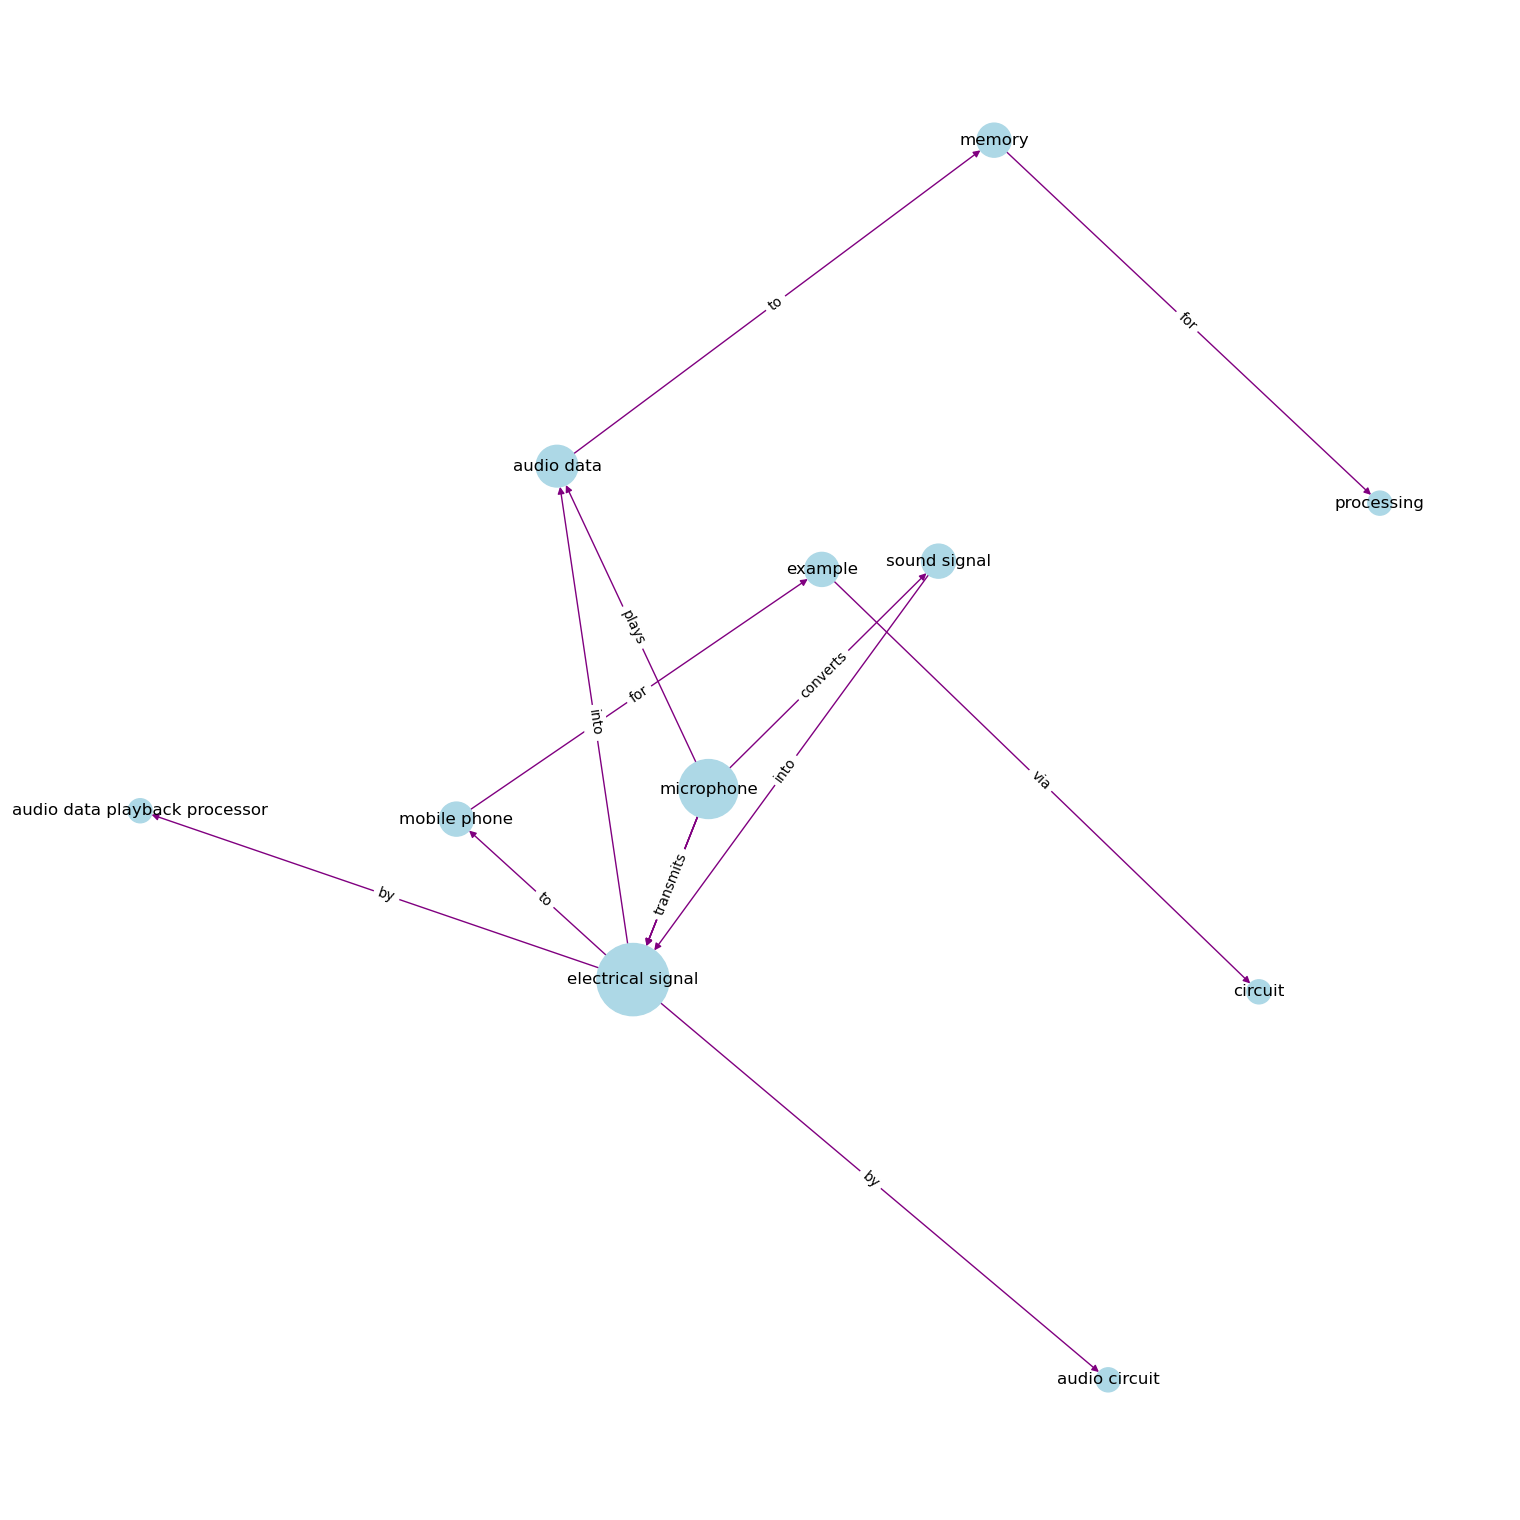

time: 493 ms (started: 2023-05-05 22:30:24 +00:00)


In [176]:
show_v3(sources,targets,predicates,ours_term)

### and the graph makes more sense

### let's try it out on the previous sentences to see if everything still works fine

### To do so, we put all our work until now in a function

In [177]:
def relation_extraction(text,no_duplicate=False,display=True,graph=False,nc=False,new_nc=False,re=False):
    doc_coref = nlp_coref(text) # neuralcoref for coreference resolution 
    if doc_coref._.has_coref : # if it found coreference clusters
        text_coref = doc_coref._.coref_resolved # replace them in the text
    else :
        text_coref = text
    doc = nlp(text_coref) # spacy for relation extraction
    # displacy.render(doc, style="dep") # not working with the old version of spacy we use (because of neuralcoref)
    noun_chunks,  noun_chunks_groups = get_noun_chunks_v5(text_coref,ours_term)
    new_noun_chunks, new_noun_chunks_groups = clean_noun_chunks_v3(noun_chunks_groups, remove_list, exclude_list)
    predicates, sources, targets = get_predicates_between_noun_chunks_v3(doc, new_noun_chunks_groups)


    # concatenate the two lists
    combined_list = new_noun_chunks + predicates

    # sort the combined list based on the 'start' attribute
    sorted_list = sorted(combined_list, key=lambda x: x['start'])
    
    # For better render purpose
    if no_duplicate:
        # create an empty set to keep track of unique items
        seen_items = set()

        # create a new list to hold the unique, sorted items
        unique_sorted_list = []

        # loop through the sorted list and add unique items to the new list
        for item in sorted_list:
            item_tuple = (item['start'], item['end'], item['label'], item['text'])
            if item_tuple not in seen_items:
                seen_items.add(item_tuple)
                unique_sorted_list.append(item)
                
        sorted_list = unique_sorted_list

    if display:
        displacy.render({'text': text_coref, 'ents': sorted_list,'title': None, "settings": {}}, style='ent', manual=True, jupyter=True, options={'colors': {"PRED": funkycolor,"TT":"#85C1E9"}})
    if graph:
        show_v3(sources,targets,predicates,ours_term)
    if nc:
        print("\n list of noun chunks groups : \n")
        for g in noun_chunks_groups:
            print(g)
        print("\n\n")
    if new_nc:
        print("\n list of filtered noun chunks groups : \n")
        for g in new_noun_chunks_groups:
            print(g)
        print("\n\n")
    if re:
        print("\n list of relations between noun chunks : \n")
        for pr,s,t in zip(predicates,sources,targets):
            print(s," | ",pr["text"]," | ",t)

time: 3.43 ms (started: 2023-05-05 22:30:27 +00:00)


In [178]:
text = "the mobile phone and may be omitted as necessary without changing the essence of the disclosure."
relation_extraction(text,re=True)


 list of relations between noun chunks : 

mobile phone  |  without changing  |  essence
essence  |  of  |  disclosure
time: 1.02 s (started: 2023-05-05 22:30:27 +00:00)


In [179]:
text = "An audio circuit 960, a speaker 961, and a microphone 962 may provide an audio interface between a user and a mobile phone."
relation_extraction(text,re=True)


 list of relations between noun chunks : 

audio circuit  |  provide  |  audio interface
speaker  |  provide  |  audio interface
microphone  |  provide  |  audio interface
audio interface  |  between  |  user
audio interface  |  between  |  mobile phone
time: 1.07 s (started: 2023-05-05 22:30:29 +00:00)


In [180]:
text = "The audio circuit 960 may transmit the received audio data converted electrical signal to the speaker 961, and convert the audio signal from the speaker 961 to a sound signal for playback."
relation_extraction(text,re=True,new_nc=True,no_duplicate=True)


 list of filtered noun chunks groups : 

[{'start': 4, 'end': 17, 'label': 'TT', 'text': 'audio circuit'}]
[{'start': 48, 'end': 58, 'label': 'TT', 'text': 'audio data'}]
[{'start': 69, 'end': 86, 'label': 'TT', 'text': 'electrical signal'}]
[{'start': 94, 'end': 101, 'label': 'TT', 'text': 'speaker'}]
[]
[{'start': 4, 'end': 17, 'label': 'TT', 'text': 'audio circuit'}]
[{'start': 123, 'end': 135, 'label': 'TT', 'text': 'audio signal'}]
[{'start': 145, 'end': 152, 'label': 'TT', 'text': 'speaker'}]
[{'start': 166, 'end': 178, 'label': 'TT', 'text': 'sound signal'}]
[{'start': 183, 'end': 191, 'label': 'NC', 'text': 'playback'}]




 list of relations between noun chunks : 

audio circuit  |  converted  |  audio data
audio data  |  converted  |  electrical signal
electrical signal  |  to  |  speaker
audio circuit  |  convert  |  audio signal
audio signal  |  from  |  speaker
speaker  |  to  |  sound signal
sound signal  |  for  |  playback
time: 1.06 s (started: 2023-05-05 22:30:31 +00

### we can see that it's still not perfect since the first relation should be "transmit" and not "converted" but this issue has always been here

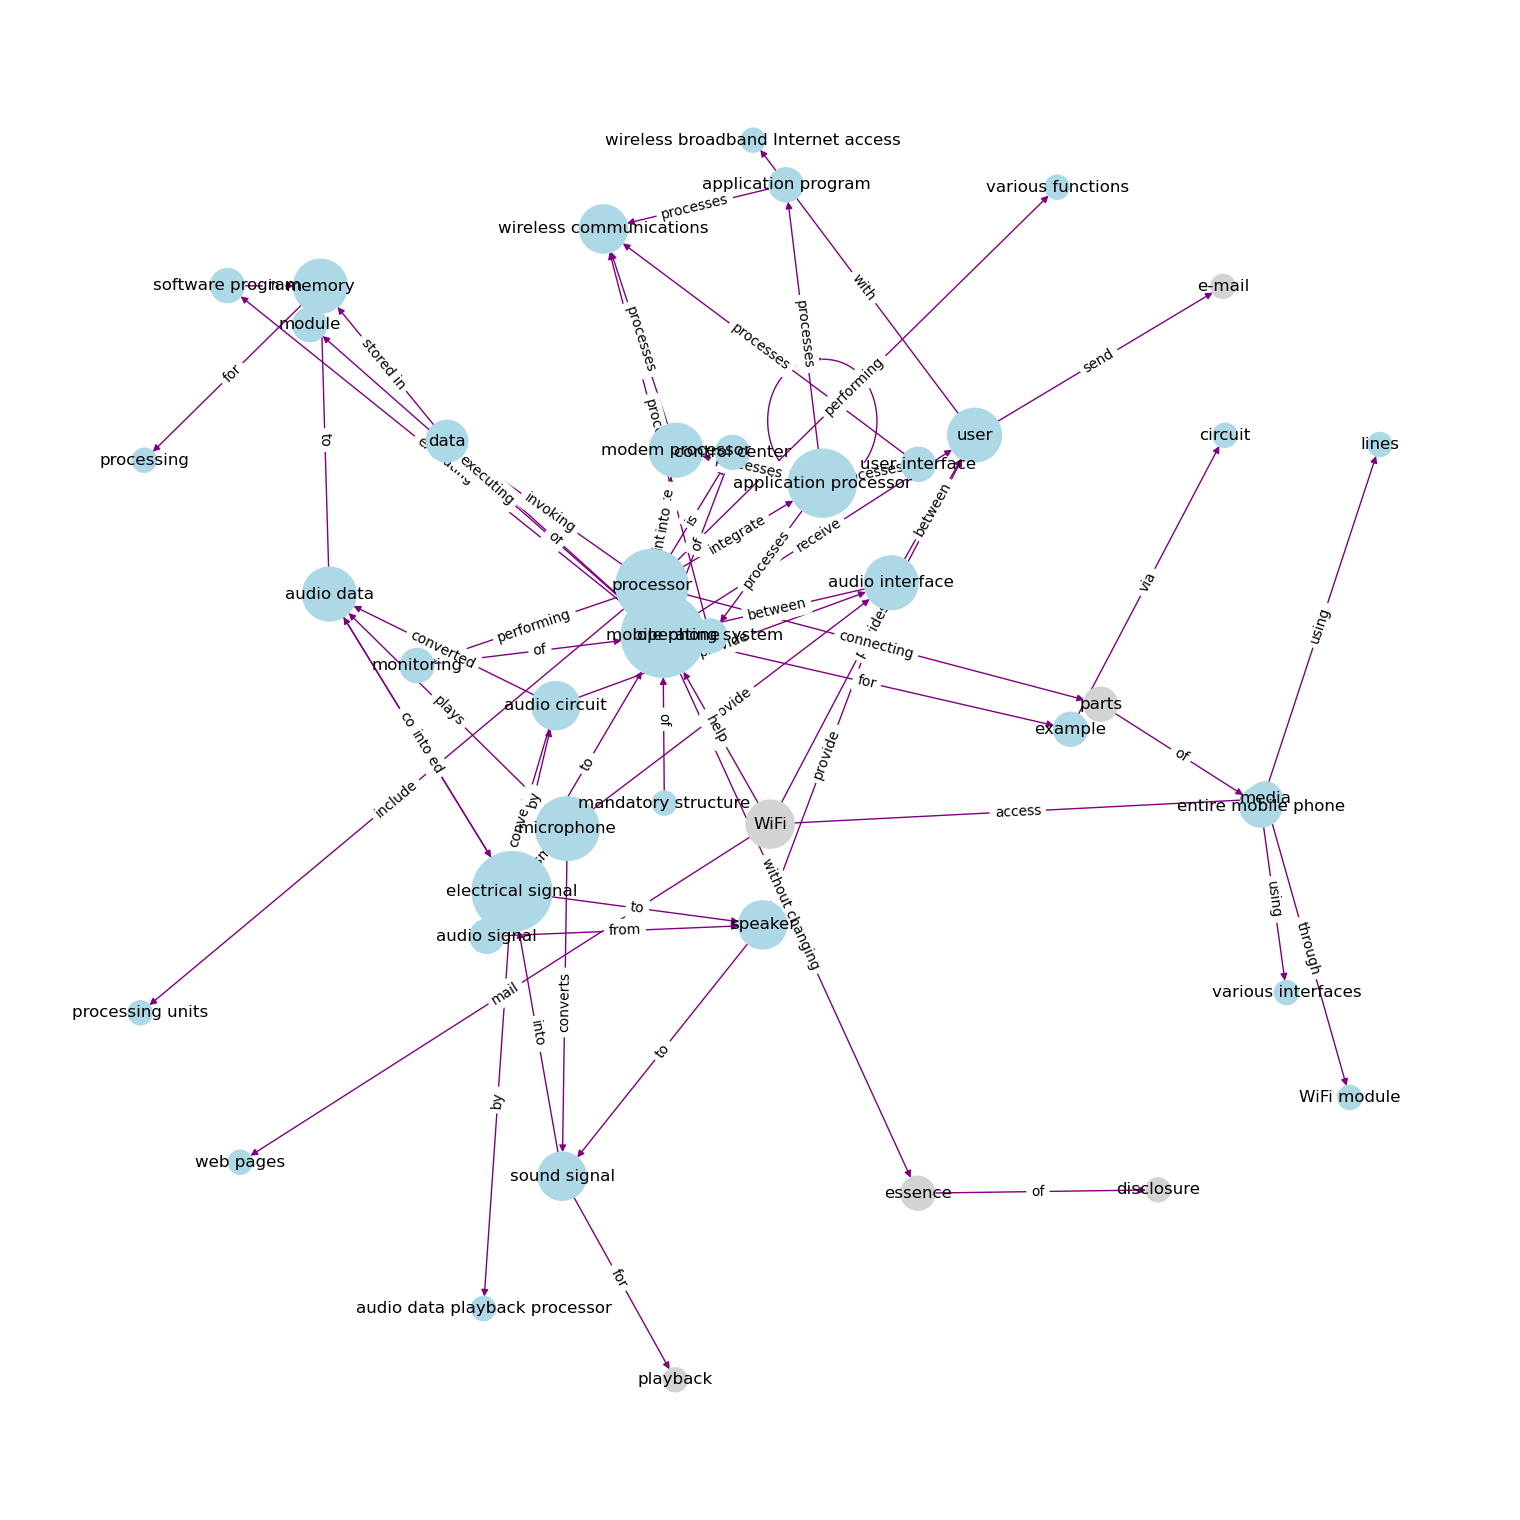

time: 4.94 s (started: 2023-05-05 22:30:33 +00:00)


In [181]:
text = "An audio circuit 960, a speaker 961, and a microphone 962 may provide an audio interface between a user and a mobile phone. The audio circuit 960 may transmit the received audio data converted electrical signal to the speaker 961, and convert the audio signal from the speaker 961 to a sound signal for playback. On the other hand, the microphone 962 converts the collected sound signal into an electrical signal, receives it by the audio circuit 960, converts it into audio data, processes it by the audio data playback processor 980, transmits it to another mobile phone, for example, via the RF circuit 910, or plays the audio data to the memory 920 for further processing. \
WiFi belongs to a short-range wireless transmission technology, and the mobile phone can help the user receive and send e-mail, browse web pages, access streaming media, and the like through the WiFi module 970, which provides the user with wireless broadband Internet access. Although FIG. 7 shows the WiFi module 970, it is understood that it does not belong to the mandatory structure of the mobile phone and may be omitted as necessary without changing the essence of the disclosure. \
The processor 980 is the control center of the mobile phone, connecting the parts of the entire mobile phone using various interfaces and lines, performing various functions and processing data of the mobile phone by running or executing a software program and/or module stored in the memory 920, and invoking data stored in the memory 920, thereby performing overall monitoring of the mobile phone. Optionally, processor 980 may include one or more processing units. Preferably, the processor 980 may integrate an application processor and a modem processor, where the application processor mainly processes an operating system, a user interface, an application program, and the like, and the modem processor mainly processes wireless communications. It is understood that the above-described modem processor may also not be integrated into the processor 980."
relation_extraction(text,no_duplicate=True,graph=True)

### We still have issues like "mail" being a predicate but overall this looks better 

## Now time to test it for real on a never seen patent text sample !!

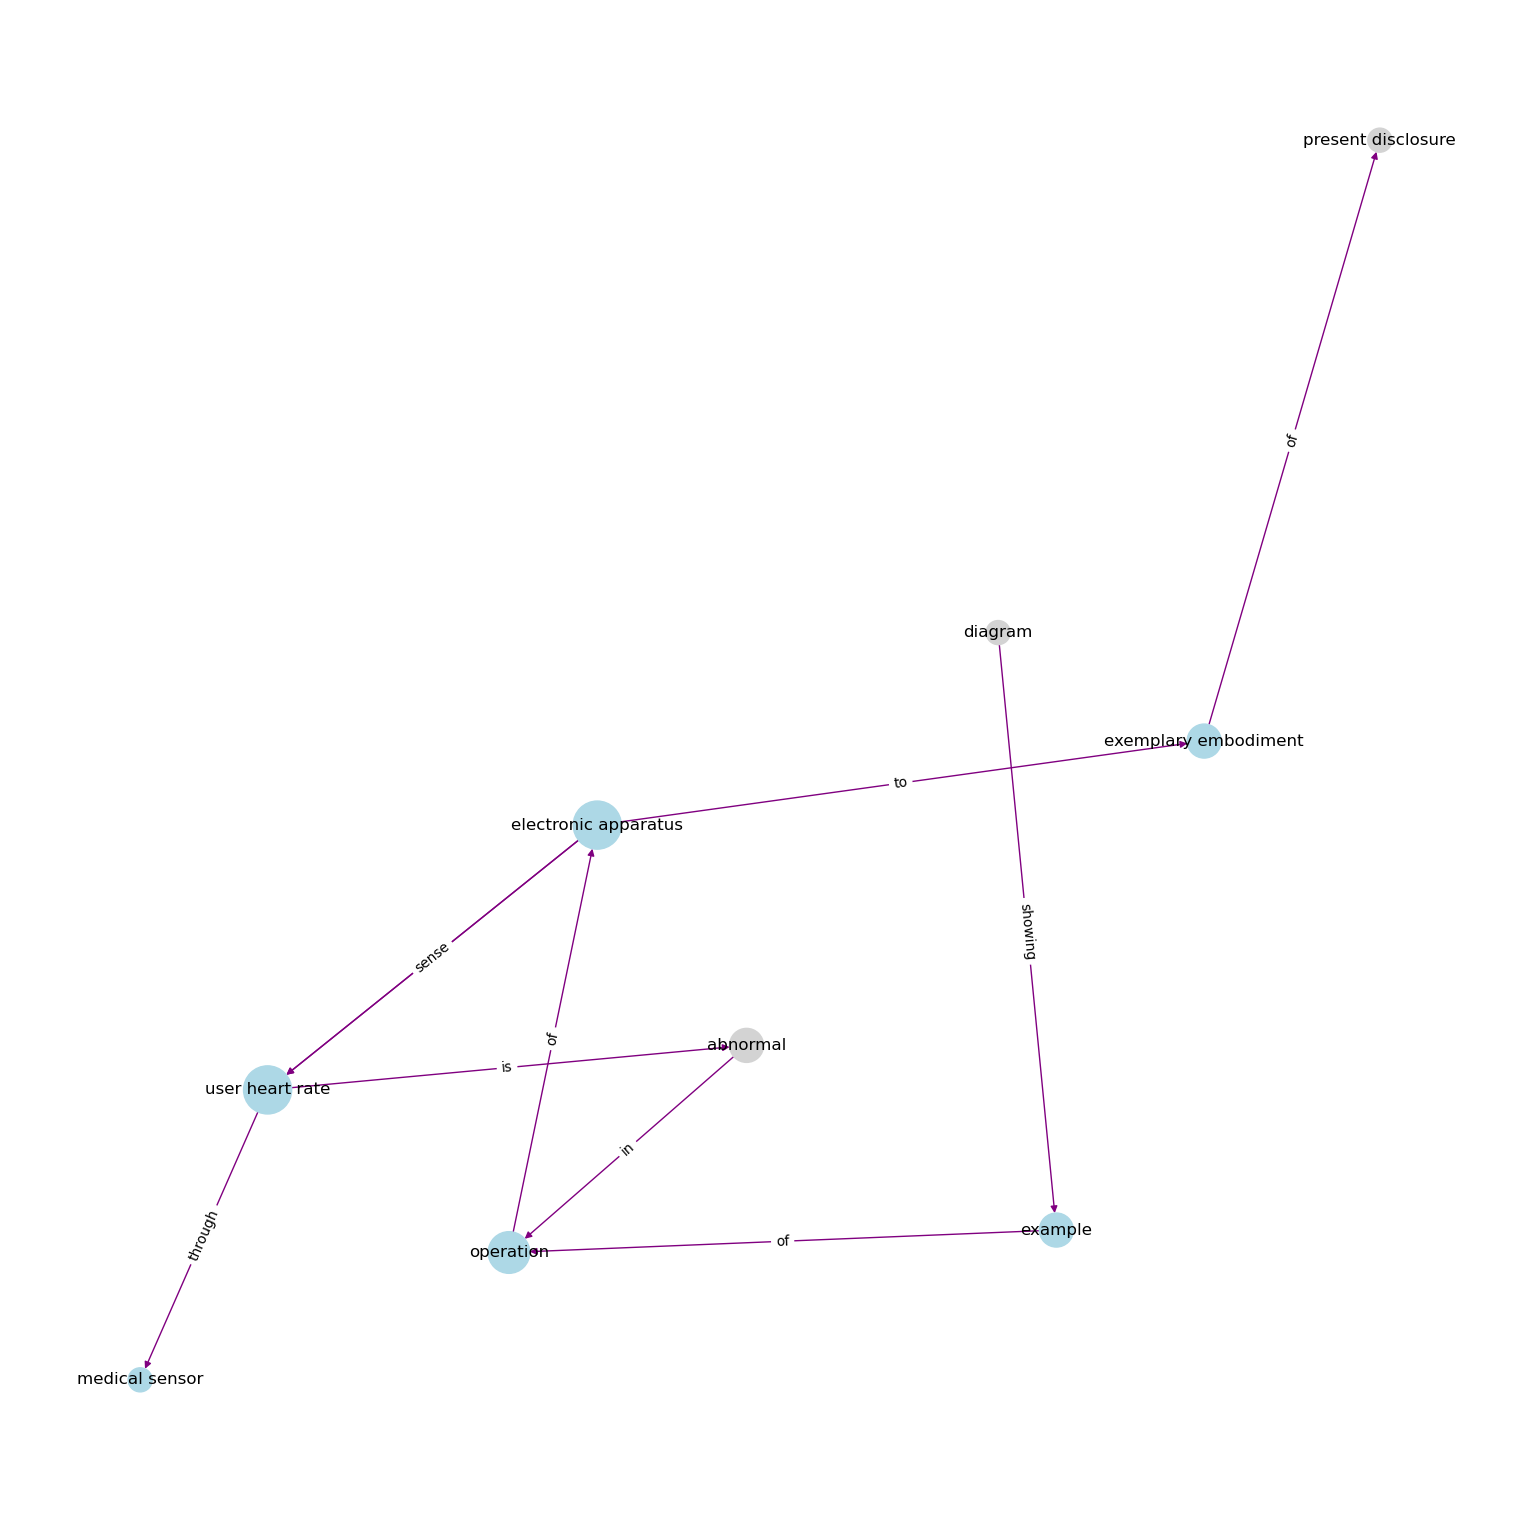

time: 1.75 s (started: 2023-05-05 22:30:40 +00:00)


In [182]:
text = "FIG. 7 is a diagram showing an example of an operation of the electronic apparatus 301 according to another exemplary embodiment of the present disclosure.Referring to FIG. 7, the electronic apparatus 301 may detect that a user heart rate is abnormal during driving in operation 701. The electronic apparatus 301 may sense the user heart rate through the medical sensor."
relation_extraction(text,no_duplicate=True,graph=True)

### we could have better predicates obviously but it would not be easy to detect when we can extend the predicate without going too far , between "process used for monitoring" and "use process for example" we would rather get "for" then risking having "use for" as a predicate between process and example

### But overall the graph is quite good ("example" shouldn't be a Technical term but it's from the extraction of gold corpus that is not good enough)

### The truth is that we have based our noun chunks extraction on a single patent but there is patents where we could have detect them in another way

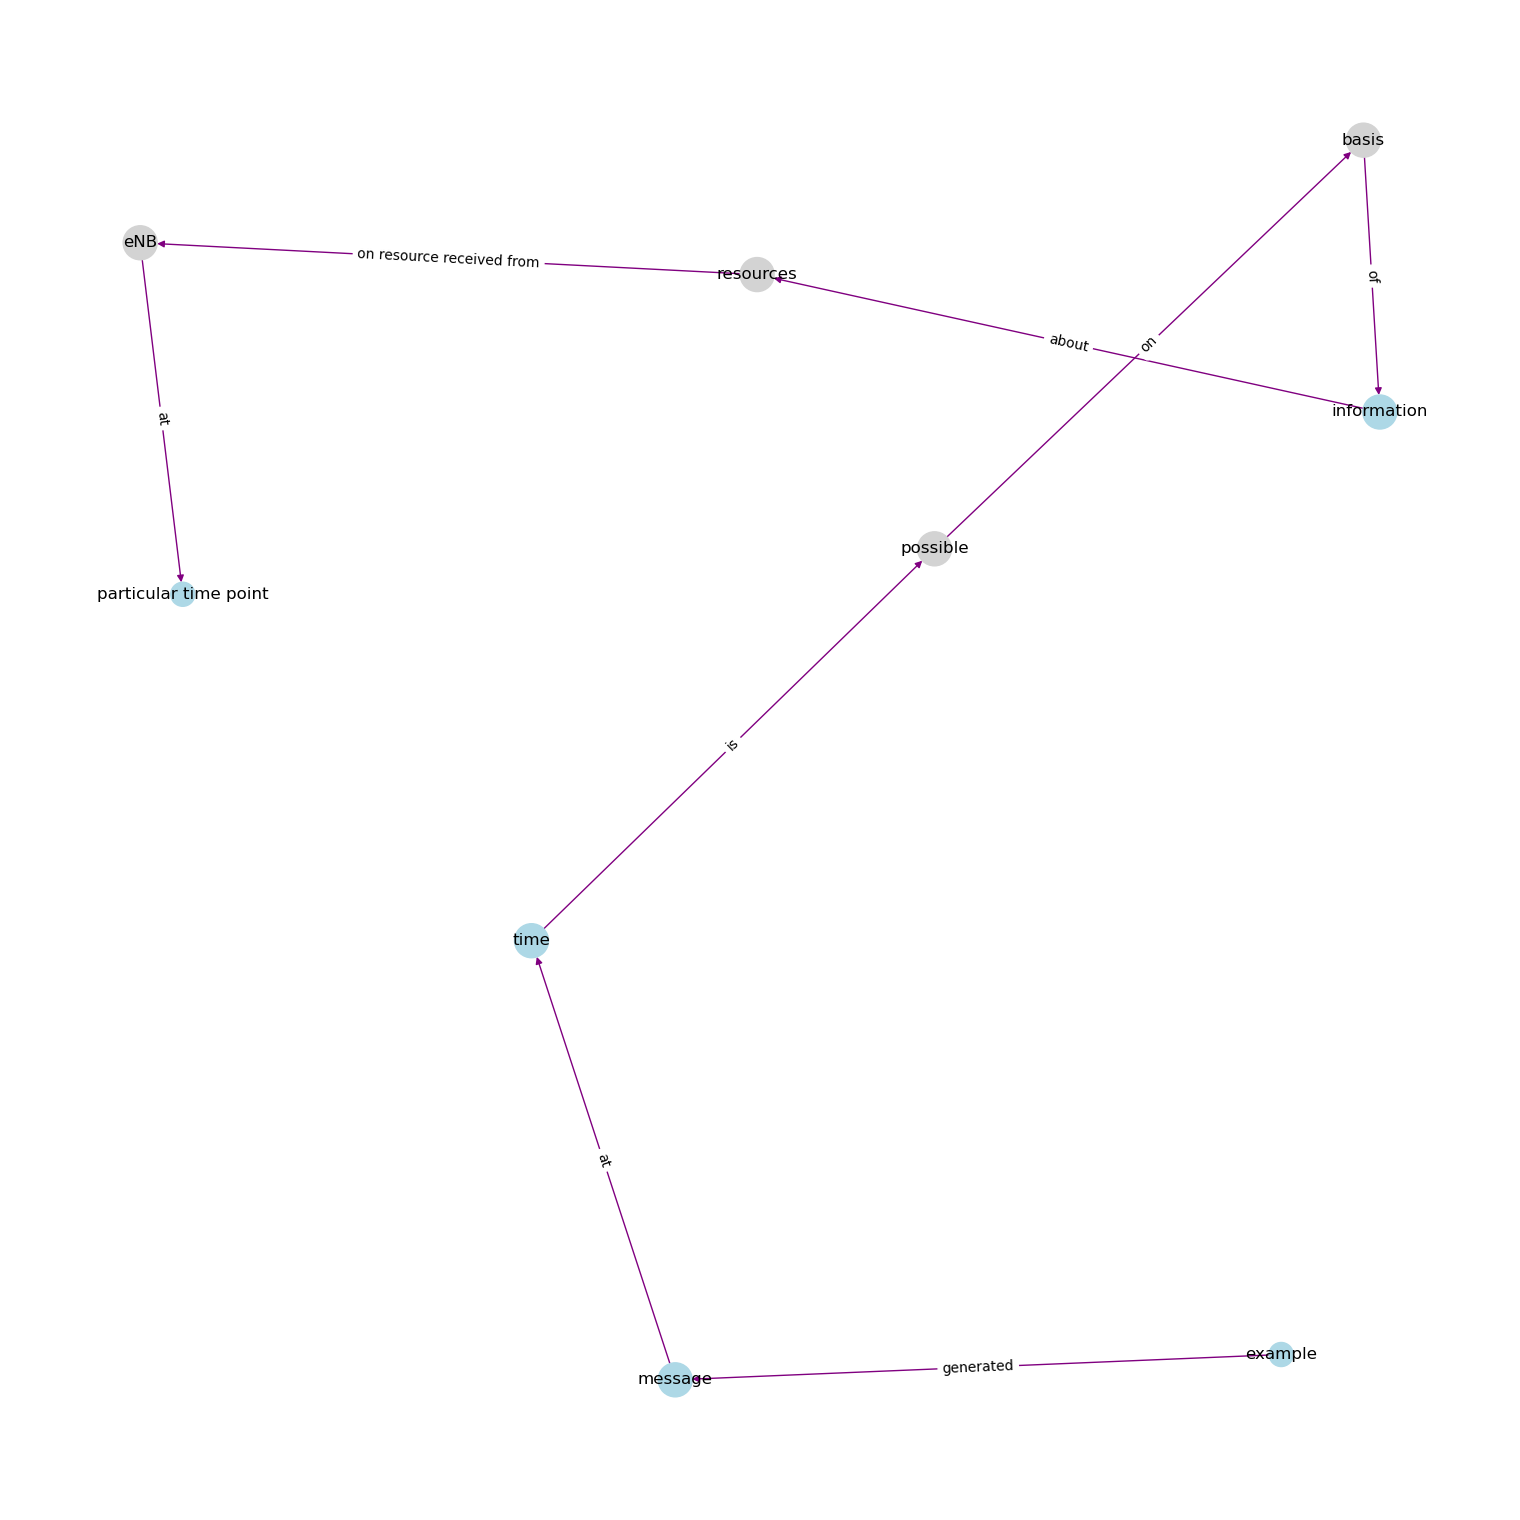

time: 1.6 s (started: 2023-05-05 22:30:44 +00:00)


In [183]:
text = "Here, in one example, the UE#X which has generated a message at time (T-X) determines whether it is possible (for the UE#X) to transmit its message on the 'N-th SPS resource' on the basis of the 'information about the occupied resources on the N-th SPS resource' received from an eNB at a particular time point before the 'N-th SPS resource'."
relation_extraction(text,no_duplicate=True,graph=True)

### First we should allow fully uppercase noun chunk like "UE#X" which is easy to change but also we could add the detection of terms between " ' " but this is a pretty rare case of patents so not worth implementing here

### let's quickly redifine the cleaning by deleting the constraint on the upper case words

In [184]:
def clean_noun_chunks_v3(noun_chunks_groups, remove_list=[], exclude_list=[]):
    new_noun_chunks = []
    new_noun_chunks_groups = []
    for i in range(len(noun_chunks_groups)):
        new_noun_chunks_group = []
        for chunk in noun_chunks_groups[i]: # get rid of the noun_chunks
            # who have an exclude word
            exclude_list += ['that', 'which','FIG', 'FIGS','FIG.','such']
            if any(token in exclude_list for token in chunk["text"].split()):
                continue
            # who have a fully upper case word   
            # if any(token.isupper() for token in chunk["text"].split()):
                # continue

            filtered_tokens = [
                token for token in chunk["text"].split()
                if token not in remove_list ]

            if not filtered_tokens:
                continue

            chunk_text = ' '.join(token for token in filtered_tokens)
            # chunk_text = chunk_text.replace('"', '').replace("'", "")

            distance = 0
            for token in chunk["text"].split():
                if token in remove_list:
                    distance += len(token)+1
                else :
                    break


            start_char = chunk["start"] + distance
            end_char = start_char + len(chunk_text)

            new_noun_chunks.append({
                'start': start_char,
                'end': end_char,
                'label': chunk["label"],
                'text': chunk_text
            })
            new_noun_chunks_group.append({
                'start': start_char,
                'end': end_char,
                'label': chunk["label"],
                'text': chunk_text
            })
        if new_noun_chunks_group != [] or noun_chunks_groups[i] == []:
            new_noun_chunks_groups.append(new_noun_chunks_group)
        
    # clear the empty groups
    # new_noun_chunks_groups = [c for c in new_noun_chunks_groups if c != []]
    
    return new_noun_chunks, new_noun_chunks_groups

time: 2.88 ms (started: 2023-05-05 22:30:47 +00:00)


### and retest it on another sample with fully upper case noun

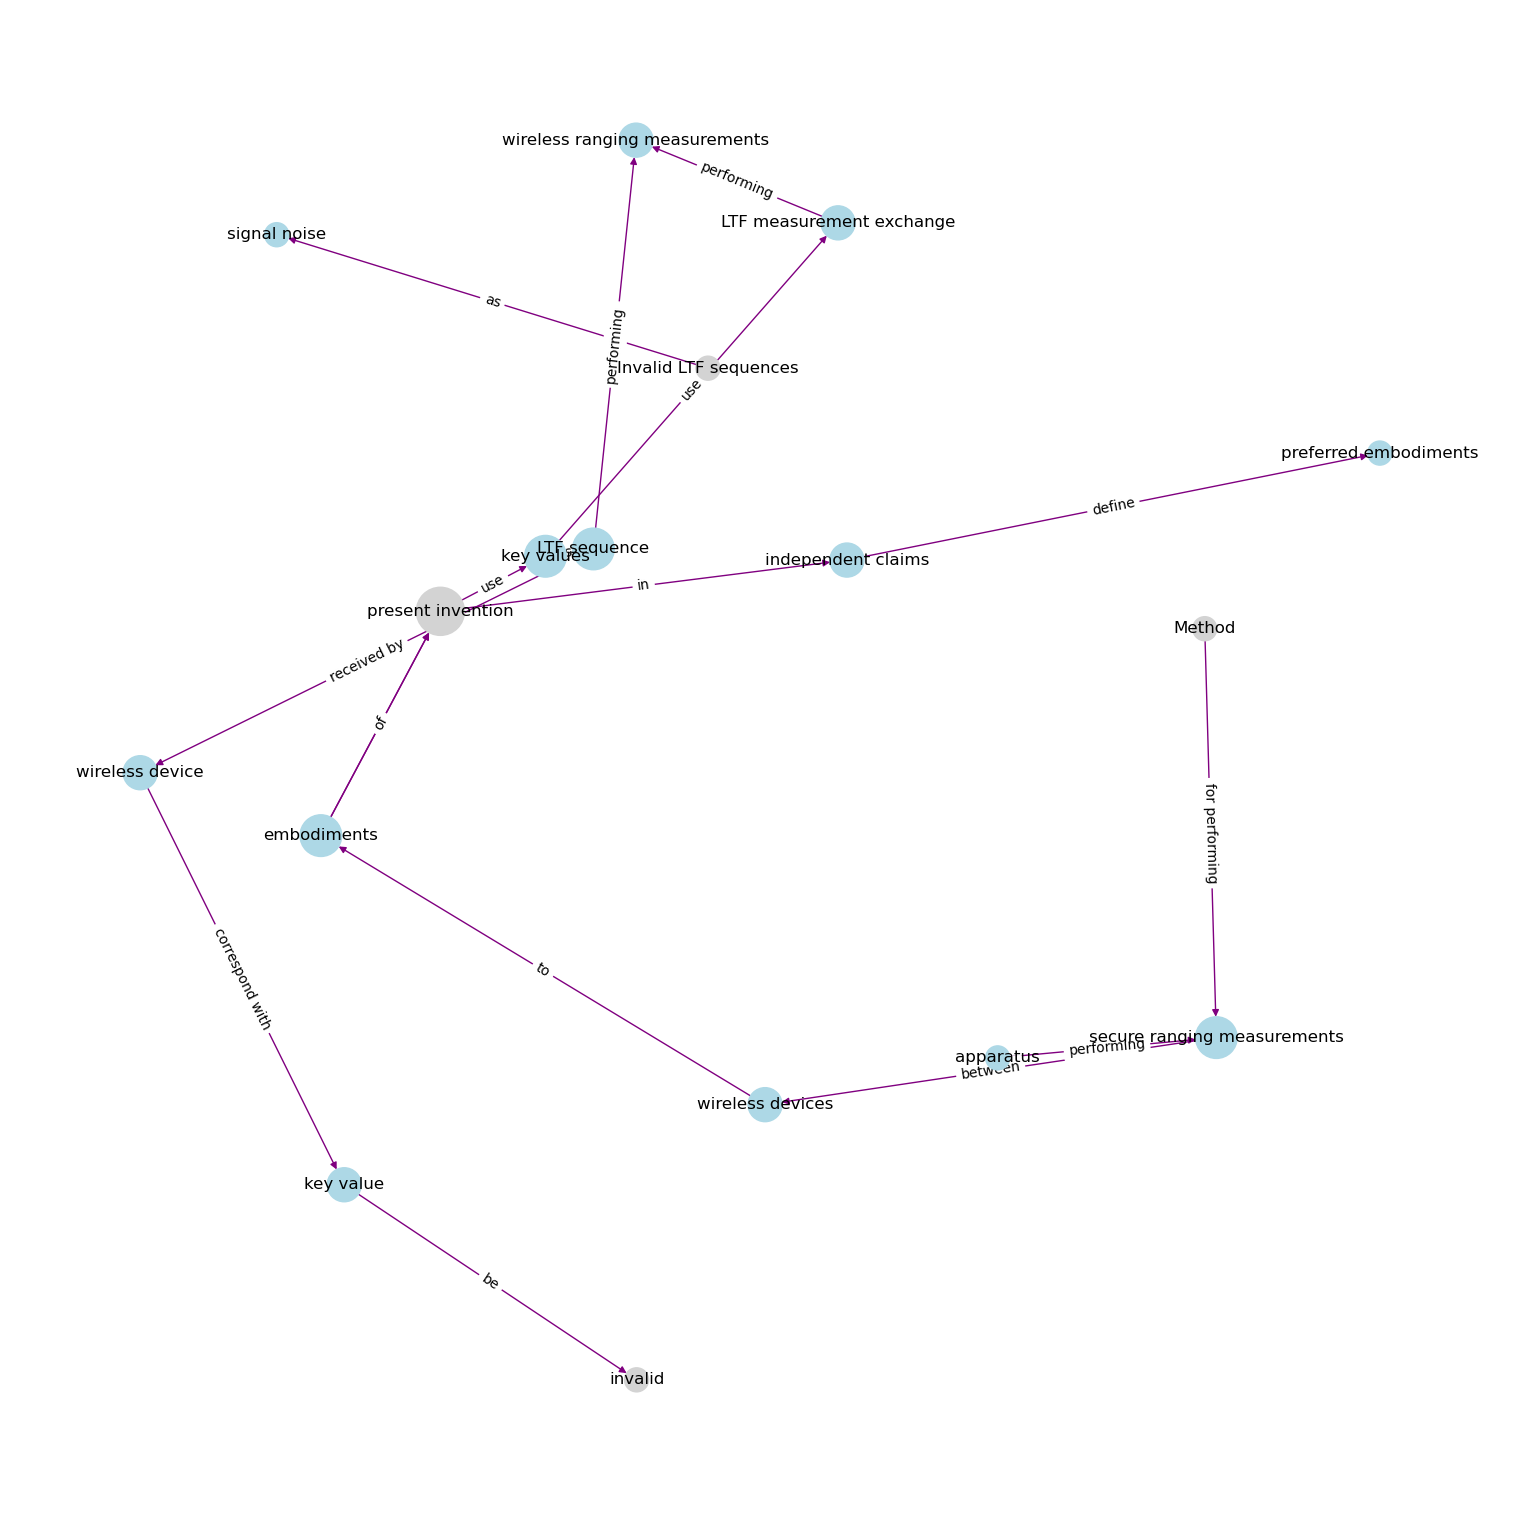

time: 2.39 s (started: 2023-05-05 22:30:48 +00:00)


In [185]:
text = "Method and apparatus for performing secure ranging measurements between wireless devices are disclosed herein according to embodiments of the present invention and are defined in the independent claims. The dependent claims define preferred embodiments thereof. The described embodiments use key values to indicate which LTF sequence (e.g., LTF measurement exchange) to use for performing wireless ranging measurements. A LTF sequence that is received by a wireless device that does not correspond with the associated key value is determined to be invalid. Invalid LTF sequences may be disregarded as signal noise."
relation_extraction(text,no_duplicate=True,graph=True)

### Not too bad !! again we could expect better predicates but hard to implement

## In the end, we end up with a rule-based relation extractor useable only on our patent texts 